In [ ]:
from google.colab import drive
import os, sys
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Imports

In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import datetime

import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import holidays

from prophet import Prophet
import math
from sklearn.metrics import mean_squared_error

from typing import Optional, Any, Tuple, List

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

import warnings
warnings.filterwarnings("ignore")

# Preprocessing functions

In [ ]:
def read_processed_data() -> pd.DataFrame:
  df = pd.read_csv('/content/drive/MyDrive/master_thesis_data/new/preprocessed/preprocessed_data.csv')
  df.drop(columns=[
    'Unnamed: 0', 'date', 'Hour', 'gasPriceSmall',
       'gasPriceMedium', 'electricityPriceSmall', 'electricityPriceMedium',
       'electricityPriceLarge', 'electricityPriceXL'], inplace=True)
  df['datetime'] = pd.to_datetime(df['datetime'])
  df.drop_duplicates(subset=['datetime'], keep='first', inplace=True)

  return df


def reindex_winter_years(year, month):
  """
  Index the winters, e.g. dec 2009 - jan and feb 2010 are winter 2, etc.
  If month == 12:
  the index is the year (e.g. 2009) + 1 (because it belongs to winter 2010) - 2008 (to get the counting from 1...)
  Else:
  the index is the year - 2008.
  """
  return year + 1 - 2008 if month == 12 else year - 2008


def set_train_test_indices(df):
  max_winter_idx = df['winterIndex'].max()
  train_test_indices = []

  for i in range(1, max_winter_idx, 1):
    train = [i for i in range(1, i + 1, 1)]
    test = i + 1
    train_test_indices.append([train, test])

  return train_test_indices


def find_numerical_columns(df: pd.DataFrame) -> list:
  """Find the numerical columns (int or float) in the given df."""
  return df.select_dtypes(include=['int64', 'float64']).columns.tolist()


def clear_outliers(
    df: pd.DataFrame,
    numerical_columns: list,

  ) -> pd.DataFrame:
  """
  Use IQR to detect the outliers.
  Next, set them to nan.
  """
  df_train = df[df['train'] == True]
  df_test = df[df['test'] == True]
  df_numerical_columns = df_train[numerical_columns]

  q1 = df_numerical_columns.quantile(0.25)
  q3 = df_numerical_columns.quantile(0.75)

  IQR = q3 - q1

  lower_bound = q1 - 1.5 * IQR
  upper_bound = q3 + 1.5 * IQR

  for col in numerical_columns:
    outliers = (df_train[col] < lower_bound[col]) | (df_train[col] > upper_bound[col])
    df_train.loc[outliers, col] = pd.NA

  df_merged = pd.concat([df_train, df_test])
  # df_merged.reset_index(inplace=True, drop=True)
  return df_merged


def shift_data(
    df: pd.DataFrame,
    n_days_lag: int,
    known_features_list: List
  ) -> pd.DataFrame:
  """Shift the predictors in the dataset,
  except for y and ds and the features that are known beforehand."""

  all_columns = list(df.columns)
  all_columns.remove('datetime')

  df_lag = df.copy()
  lag = n_days_lag * 24

  df_lag.sort_values('datetime', inplace=True)

  for i in all_columns:
    if i not in known_features_list:
      df_lag[f"{i}-{n_days_lag}days"] = df_lag[i].shift(lag)
      if (i != 'loadConsumption'):
        df_lag.drop(columns=[i], inplace=True)

  df_lag[f"loadConsumption-{n_days_lag}days-24h"] = df_lag["loadConsumption"].shift(lag + 24)
  df_lag[f"loadConsumption-{n_days_lag}days-7days"] = df_lag["loadConsumption"].shift(lag + (24*7))
  df_lag[f"loadConsumption-{n_days_lag}days-12m"] = df_lag["loadConsumption"].shift(lag + (24*365))

  df_lag = df_lag.iloc[lag + (24*365):] # filter on this lag because from here on we have all data again
  df_lag.reset_index(inplace=True, drop=True)

  return df_lag


def split_train_val_test(
    df: pd.DataFrame,
  ) -> Tuple[pd.DataFrame, pd.DataFrame]:
  """Split the df into train/val and test data."""
  df['datetime'] = pd.to_datetime(df['datetime'])
  df_train_val = df[df['train'] == True]
  df_test = df[df['test'] == True]

  df_train_val.reset_index(inplace=True, drop=True)
  df_test.reset_index(inplace=True, drop=True)

  return (df_train_val, df_test)


def replace_null_with_imputed_value(df, col):
  df[col] = df.apply(lambda row: row[col] if pd.notnull(row[col]) else row[f'{col}_imputed'], axis=1)
  df.drop(columns=[f'{col}_imputed'], inplace=True)

  return df


def rename_col(df, col, renamed_col):
  df_tmp = df[['datetime', col]]
  df_tmp.rename(columns={col:renamed_col}, inplace=True)

  return df_tmp


def impute_load_consumption_columns(df, col, imputer):
  """
  Impute the col i with the fitted imputer.
  Merge back to the df.
  """
  df_tmp = rename_col(df, col=col, renamed_col='loadConsumption')
  df_tmp['loadConsumption_imputed'] = imputer.transform(df[['loadConsumption']])
  df_tmp = replace_null_with_imputed_value(df_tmp, col='loadConsumption')
  df_tmp.rename(columns={'loadConsumption':col}, inplace=True)
  df.drop(columns=[col], inplace=True)
  df = df.merge(df_tmp, on = 'datetime', how = 'left')

  return df


def impute_numerical_columns(
    df_train_val: pd.DataFrame,
    df_test: pd.DataFrame,
    numerical_columns: List,
    n_days_lag: int,
    known_features_list: List
  ) -> Tuple[pd.DataFrame, pd.DataFrame, List]:
  numerical_columns_lagged = [f"{i}-{n_days_lag}days" if i not in known_features_list else i for i in numerical_columns]

  # impute load consumption with fit transform
  imputer = IterativeImputer(max_iter=10, random_state=0)
  df_train_val['loadConsumption_imputed'] = imputer.fit_transform(df_train_val[['loadConsumption']])
  df_train_val = replace_null_with_imputed_value(df_train_val, col='loadConsumption')

  # also impute load consumption in test with just transform
  df_test['loadConsumption_imputed'] = imputer.transform(df_test[['loadConsumption']])
  df_test = replace_null_with_imputed_value(df_test, col='loadConsumption')

  #tmp rename column to be able to use the transform from loadConsumption
  load_consumption_columns = [
      f'loadConsumption-{n_days_lag}days',
      f'loadConsumption-{n_days_lag}days-24h',
      f'loadConsumption-{n_days_lag}days-7days',
      f"loadConsumption-{n_days_lag}days-12m"
  ]
  for i in load_consumption_columns:
    df_train_val = impute_load_consumption_columns(df=df_train_val, col=i, imputer=imputer)
    df_test = impute_load_consumption_columns(df=df_test, col=i, imputer=imputer)

  for i in numerical_columns_lagged:
    if i not in load_consumption_columns:
      imputer = IterativeImputer(max_iter=10, random_state=0)
      df_train_val[f'{i}_imputed'] = imputer.fit_transform(df_train_val[[i]])
      df_train_val = replace_null_with_imputed_value(df_train_val, col=i)

      df_test[f'{i}_imputed'] = imputer.transform(df_test[[i]])
      df_test = replace_null_with_imputed_value(df_test, col=i)

  return df_train_val, df_test, numerical_columns_lagged


# Run and save preprocessing

In [ ]:
def preprocess_and_save(known_features_list: list, n_days_lag: int, rerun: bool):
  df = read_processed_data()
  df['winterIndex'] = df[['Year', 'Month']].apply(lambda x: reindex_winter_years(x.Year, x.Month), axis=1)
  df.drop(columns=['Year', 'Month'], inplace=True)
  train_test_indices = set_train_test_indices(df)
  numerical_columns = find_numerical_columns(df)

  if rerun:
    fold = 1
    for train_indices, test_index in train_test_indices:
      print(train_indices, test_index)
      df_tmp = df.copy()

      df_tmp['train'] = df_tmp['winterIndex'].apply(lambda x: True if x in train_indices else False)
      df_tmp['test'] = df_tmp['winterIndex'].apply(lambda x: True if x == test_index else False)

      df_tmp = clear_outliers(df_tmp, numerical_columns)

      df_lag = shift_data(df_tmp, n_days_lag, known_features_list=known_features_list)

      df_train_val, df_test = split_train_val_test(df_lag)

      if len(df_train_val) > 0:
        df_train_val, df_test, numerical_columns_lagged = impute_numerical_columns(
          df_train_val=df_train_val,
          df_test=df_test,
          numerical_columns=numerical_columns,
          n_days_lag=n_days_lag,
          known_features_list=known_features_list
        )

        df_train_val.to_csv(f'/content/drive/MyDrive/master_thesis_data/train_val_test_data/train_val_fold{fold}.csv')
        df_test.to_csv(f'/content/drive/MyDrive/master_thesis_data/train_val_test_data/test_fold{fold}.csv')

      fold += 1

  return train_test_indices, numerical_columns

# Set parameters

In [ ]:
known_features_list = ['winterIndex', 'train', 'test']
n_days_lag=60

train_test_indices, numerical_columns = preprocess_and_save(known_features_list, n_days_lag, rerun=False)

numerical_columns_lagged = [f"{i}-{n_days_lag}days" for i in numerical_columns if i != 'winterIndex']
n_predictors = 5
alpha = 0.05
use_all_predictors = True
include_price_bool = False
include_climate_change_bool = False
use_no_predictors = False
huang = True
tan = False

In [ ]:
numerical_columns

['loadConsumption',
 'dailyPrecipitation',
 'dailyMeanTemperature',
 'dailyMeanWindspeed',
 'NAO',
 'renewableEnergyRatio',
 'avgGasPrice',
 'avgElectricityPrice',
 'nat',
 'sic',
 'geopotential',
 'winterIndex']

In [ ]:
train_test_indices

[[[1], 2],
 [[1, 2], 3],
 [[1, 2, 3], 4],
 [[1, 2, 3, 4], 5],
 [[1, 2, 3, 4, 5], 6],
 [[1, 2, 3, 4, 5, 6], 7],
 [[1, 2, 3, 4, 5, 6, 7], 8],
 [[1, 2, 3, 4, 5, 6, 7, 8], 9],
 [[1, 2, 3, 4, 5, 6, 7, 8, 9], 10],
 [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 11]]

# Prophet

In [ ]:
def prepare_data_for_prophet(
    df: pd.DataFrame,
    predictors_list: list,
    use_all_predictors: bool,
    use_no_predictors: bool,
    n_days_lag: int,
    ) -> pd.DataFrame:
  """Select the predictors from the df and rename date to ds and load to y."""

  if use_all_predictors:
    print("All predictors are used")
    df_prophet = df.copy()

  if use_no_predictors:
    print("No predictors are used")
    cols_to_select = predictors_list.copy()
    cols_to_select.append('datetime')
    cols_to_select.append('loadConsumption')
    df_prophet = df[cols_to_select]

  df_prophet.rename(columns={'datetime':'ds', 'loadConsumption':'y'}, inplace=True)

  return df_prophet


def initialize_prophet(
    regressors: list,
    ):
    """
    Initialize prophet. Either with specified seasonalities or default.
    Add regressors if any are entered.
    """
    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True,
    )

    if len(regressors) > 0:
        for regressor in regressors:
            model.add_regressor(regressor)

    return model


def combine_prophet_predictions_and_target(prophet_forecast, df_subset, prophet_columns_to_select, predictors_to_select):
  """
  Combine the results from Prophet with the target LoadConsumption.
  """
  df_subset['ds'] = pd.to_datetime(df_subset['ds'], format='%Y-%m-%d %H:%M:%S')
  new_predictors_to_select = predictors_to_select + ['y', 'ds'] #, 'seasonal', 'trend']
  df_subset = df_subset[new_predictors_to_select]
  prophet_forecast = prophet_forecast[prophet_columns_to_select]

  df_prophet = prophet_forecast.merge(df_subset, on='ds', how='left')
  df_prophet.rename(columns={'y':'loadConsumption'}, inplace=True)

  return df_prophet

In [ ]:
def reload_data(fold: int):
  df_train_val = pd.read_csv(f'/content/drive/MyDrive/master_thesis_data/train_val_test_data/train_val_fold{fold}.csv').drop(columns=['Unnamed: 0'])
  df_test = pd.read_csv(f'/content/drive/MyDrive/master_thesis_data/train_val_test_data/test_fold{fold}.csv').drop(columns=['Unnamed: 0'])

  return df_train_val, df_test


def predictor_selection(
    df_train_val: pd.DataFrame,
    numerical_columns_lagged: list,
    n_predictors: int,
    alpha: float,
    n_days_lag: int,
    use_all_predictors: bool,
    use_no_predictors: bool,
    include_climate_change_bool: bool,
    include_price_bool: bool,
    known_features_list: list):

  if use_all_predictors:
    predictors_list = list(df_train_val.columns)
    predictors_list.remove('datetime')
    predictors_list.remove('loadConsumption')
    if include_price_bool:
      predictors_list.remove(f'avgGasPrice-{n_days_lag}days')
      predictors_list.remove(f'avgElectricityPrice-{n_days_lag}days')
    if include_climate_change_bool:
      predictors_list.remove(f'dailyPrecipitation-{n_days_lag}days')
      predictors_list.remove(f'dailyMeanTemperature-{n_days_lag}days')
      predictors_list.remove(f'dailyMeanWindspeed-{n_days_lag}days')
      predictors_list.remove(f'NAO-{n_days_lag}days')
      predictors_list.remove(f'nat-{n_days_lag}days')
      predictors_list.remove(f'sic-{n_days_lag}days')
      predictors_list.remove(f'geopotential-{n_days_lag}days')

  else:
    predictors_list = [
      f'loadConsumption-{n_days_lag}days',
      f"loadConsumption-{n_days_lag}days-24h",
      f"loadConsumption-{n_days_lag}days-7days",
      f"loadConsumption-{n_days_lag}days-12m"
    ]

    if include_price_bool:
      price_columns=[
      f'avgGasPrice-{n_days_lag}days',
      f'avgElectricityPrice-{n_days_lag}days',
      ]

      predictors_list = predictors_list + price_columns
    if include_climate_change_bool:
      climate_change_columns=[
      f'dailyPrecipitation-{n_days_lag}days',
      f'dailyMeanTemperature-{n_days_lag}days',
      f'dailyMeanWindspeed-{n_days_lag}days',
      f'NAO-{n_days_lag}days',
      f'nat-{n_days_lag}days',
      f'sic-{n_days_lag}days',
      f'geopotential-{n_days_lag}days'
      ]

      predictors_list = predictors_list + climate_change_columns

  predictors_list = list(set(predictors_list))

  return predictors_list


In [ ]:
def run_prophet(
      df_train_val: pd.DataFrame,
      df_test: pd.DataFrame,
      predictors_list: list,
      use_all_predictors: bool,
      use_no_predictors: bool,
      n_days_lag: bool
    ):

  df_train_prophet = prepare_data_for_prophet(
      df=df_train_val,
      predictors_list=predictors_list,
      use_all_predictors=use_all_predictors,
      use_no_predictors=use_no_predictors,
      n_days_lag=n_days_lag
  )

  df_test_prophet = prepare_data_for_prophet(
      df=df_test,
      predictors_list=predictors_list,
      use_all_predictors=use_all_predictors,
      use_no_predictors=use_no_predictors,
      n_days_lag=n_days_lag
  )

  model = initialize_prophet(regressors=predictors_list)
  model.fit(df_train_prophet)
  predictions_train_validation = model.predict(df_train_prophet)
  predictions_wintertime = model.predict(df_test_prophet)

  df_train_lstm = combine_prophet_predictions_and_target(
    prophet_forecast=predictions_train_validation,
    df_subset=df_train_prophet,
    prophet_columns_to_select=['yhat', 'ds', 'trend', 'daily', 'weekly', 'yearly'],
    predictors_to_select=predictors_list
  )

  df_test_lstm = combine_prophet_predictions_and_target(
    prophet_forecast=predictions_wintertime,
    df_subset=df_test_prophet,
    prophet_columns_to_select=['yhat', 'ds', 'trend', 'daily', 'weekly', 'yearly'],
    predictors_to_select=predictors_list
  )

  return df_train_lstm, df_test_lstm


# Save individual prophet forecasts

In [ ]:
def save_prophet_forecasts(
    numerical_columns_lagged: list,
    n_predictors: int,
    alpha: float,
    use_all_predictors: bool,
    include_price_bool: bool,
    include_climate_change_bool: bool,
    use_no_predictors: bool,
    train_test_indices: list,
    folder_name: str,
    n_days_lag: int):

    for fold in range(3, 11, 1):
        print(f"FOLD {fold}")
        df_train_val, df_test  = reload_data(fold)
        predictors_list = predictor_selection(
            df_train_val,
            numerical_columns_lagged,
            n_predictors,
            alpha,
            n_days_lag,
            use_all_predictors,
            use_no_predictors,
            include_climate_change_bool,
            include_price_bool,
            known_features_list
        )

        df_train_lstm, df_test_lstm = run_prophet(
            df_train_val,
            df_test,
            predictors_list,
            use_all_predictors,
            use_no_predictors,
            n_days_lag
        )

        df_train_lstm.to_csv(f'/content/drive/MyDrive/master_thesis_data/prophet_forecasts/{folder_name}/train/fold{fold}.csv')
        df_test_lstm.to_csv(f'/content/drive/MyDrive/master_thesis_data/prophet_forecasts/{folder_name}/test/fold{fold}.csv')


### All predictors

In [ ]:
save_prophet_forecasts(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=True,
    use_no_predictors=False,
    include_price_bool=False,
    include_climate_change_bool=False,
    train_test_indices=train_test_indices,
    folder_name = 'all_predictors'
)

FOLD 2
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/3kg6i4lu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/td57dfzk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64657', 'data', 'file=/tmp/tmplw_4c67n/3kg6i4lu.json', 'init=/tmp/tmplw_4c67n/td57dfzk.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelzwqdklp7/prophet_model-20240610200638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:06:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:06:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 3
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/l80idh7_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/3yfw7s_y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73834', 'data', 'file=/tmp/tmplw_4c67n/l80idh7_.json', 'init=/tmp/tmplw_4c67n/3yfw7s_y.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelyxc46dpa/prophet_model-20240610200647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:06:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:06:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 4
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/h47re8bd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/jop2l6ci.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17074', 'data', 'file=/tmp/tmplw_4c67n/h47re8bd.json', 'init=/tmp/tmplw_4c67n/jop2l6ci.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelcb2itn9w/prophet_model-20240610200711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:07:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:07:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 5
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/m1ne1vfs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/b3k4qld_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56086', 'data', 'file=/tmp/tmplw_4c67n/m1ne1vfs.json', 'init=/tmp/tmplw_4c67n/b3k4qld_.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelikuo_gb1/prophet_model-20240610200802.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:08:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:09:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 6
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/y4f61yet.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/m78afpq5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44944', 'data', 'file=/tmp/tmplw_4c67n/y4f61yet.json', 'init=/tmp/tmplw_4c67n/m78afpq5.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelajcgm60e/prophet_model-20240610201020.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:10:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:11:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 7
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/swxqld09.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/_cpsr78y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44628', 'data', 'file=/tmp/tmplw_4c67n/swxqld09.json', 'init=/tmp/tmplw_4c67n/_cpsr78y.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelc2ihuas9/prophet_model-20240610201229.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:12:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:14:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 8
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/qujkjvu2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/2zohe9y1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98865', 'data', 'file=/tmp/tmplw_4c67n/qujkjvu2.json', 'init=/tmp/tmplw_4c67n/2zohe9y1.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_model9qq69cjs/prophet_model-20240610201519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:15:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:18:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 9
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/_l_vma3h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/ff64qons.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16500', 'data', 'file=/tmp/tmplw_4c67n/_l_vma3h.json', 'init=/tmp/tmplw_4c67n/ff64qons.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelpwpkyca9/prophet_model-20240610201903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:19:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:21:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 10
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/_dcc4coc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/nbnecaax.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38398', 'data', 'file=/tmp/tmplw_4c67n/_dcc4coc.json', 'init=/tmp/tmplw_4c67n/nbnecaax.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelglvx4n1l/prophet_model-20240610202228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:22:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:24:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### No predictors

In [ ]:
save_prophet_forecasts(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=False,
    use_no_predictors=True,
    include_price_bool=False,
    include_climate_change_bool=False,
    train_test_indices=train_test_indices,
    folder_name='no_predictors'
)

DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/udj6dw27.json


FOLD 2
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/uatd0qeg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22586', 'data', 'file=/tmp/tmplw_4c67n/udj6dw27.json', 'init=/tmp/tmplw_4c67n/uatd0qeg.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelmtnanbjm/prophet_model-20240610202437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:24:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:24:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 3
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/czc9q8if.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/96yr7c_6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56582', 'data', 'file=/tmp/tmplw_4c67n/czc9q8if.json', 'init=/tmp/tmplw_4c67n/96yr7c_6.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelrlzdbqms/prophet_model-20240610202445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:24:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:24:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 4
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/sqct76uh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/0rytyl35.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88806', 'data', 'file=/tmp/tmplw_4c67n/sqct76uh.json', 'init=/tmp/tmplw_4c67n/0rytyl35.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelz5v821lt/prophet_model-20240610202500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 5
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/o8x14315.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/avm4cyv3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11361', 'data', 'file=/tmp/tmplw_4c67n/o8x14315.json', 'init=/tmp/tmplw_4c67n/avm4cyv3.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modeljp_jrst9/prophet_model-20240610202543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:26:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 6
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/nmty16_4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/xhz285rl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45016', 'data', 'file=/tmp/tmplw_4c67n/nmty16_4.json', 'init=/tmp/tmplw_4c67n/xhz285rl.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_model6rex1e2v/prophet_model-20240610202704.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:27:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:27:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 7
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/6x675f7x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/7r56s3gf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53024', 'data', 'file=/tmp/tmplw_4c67n/6x675f7x.json', 'init=/tmp/tmplw_4c67n/7r56s3gf.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelx74le2da/prophet_model-20240610202812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:28:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:29:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 8
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/svug6vm7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/7lfzw149.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49545', 'data', 'file=/tmp/tmplw_4c67n/svug6vm7.json', 'init=/tmp/tmplw_4c67n/7lfzw149.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelrrwuvk5t/prophet_model-20240610202956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:29:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:30:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 9
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/9gmxvvk_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/uzdzr0jn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92772', 'data', 'file=/tmp/tmplw_4c67n/9gmxvvk_.json', 'init=/tmp/tmplw_4c67n/uzdzr0jn.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelz3_95zcq/prophet_model-20240610203121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:31:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:33:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 10
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/iuzqaohs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/9gk9u2gd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25960', 'data', 'file=/tmp/tmplw_4c67n/iuzqaohs.json', 'init=/tmp/tmplw_4c67n/9gk9u2gd.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_model58f14n97/prophet_model-20240610203336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:33:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:35:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### All predictors - price

In [ ]:
save_prophet_forecasts(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=True,
    use_no_predictors=False,
    include_price_bool=True,
    include_climate_change_bool=False,
    train_test_indices=train_test_indices,
    folder_name='all_predictors_price'
)

FOLD 2
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/knxyami9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/f0_che07.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24328', 'data', 'file=/tmp/tmplw_4c67n/knxyami9.json', 'init=/tmp/tmplw_4c67n/f0_che07.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelx000qt6z/prophet_model-20240610203519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:35:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:35:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 3
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/5tnxvgof.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/4cmsgtl_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73597', 'data', 'file=/tmp/tmplw_4c67n/5tnxvgof.json', 'init=/tmp/tmplw_4c67n/4cmsgtl_.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modeloiu5lkfi/prophet_model-20240610203527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:35:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:35:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 4
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/n5yyiuhp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/a8o3ywuu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13388', 'data', 'file=/tmp/tmplw_4c67n/n5yyiuhp.json', 'init=/tmp/tmplw_4c67n/a8o3ywuu.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelbf8r5j6o/prophet_model-20240610203548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:35:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:36:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 5
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/dzzuolqs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/zt4i4vnx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13832', 'data', 'file=/tmp/tmplw_4c67n/dzzuolqs.json', 'init=/tmp/tmplw_4c67n/zt4i4vnx.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelaat2mwps/prophet_model-20240610203629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:36:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:37:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 6
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/jszsjyfp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/ygjqiiq7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32710', 'data', 'file=/tmp/tmplw_4c67n/jszsjyfp.json', 'init=/tmp/tmplw_4c67n/ygjqiiq7.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_model4f9qr14i/prophet_model-20240610203749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:37:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:39:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 7
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/5rhpv6wy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/qpa4x1af.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95266', 'data', 'file=/tmp/tmplw_4c67n/5rhpv6wy.json', 'init=/tmp/tmplw_4c67n/qpa4x1af.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelqqsgjwpp/prophet_model-20240610203947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:39:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:41:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 8
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/audn4w96.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/sxqmtuun.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1840', 'data', 'file=/tmp/tmplw_4c67n/audn4w96.json', 'init=/tmp/tmplw_4c67n/sxqmtuun.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_model8nnynkez/prophet_model-20240610204133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:41:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:43:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 9
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/_q9v3nnx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/_m1wo363.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90801', 'data', 'file=/tmp/tmplw_4c67n/_q9v3nnx.json', 'init=/tmp/tmplw_4c67n/_m1wo363.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modeler4ilcwc/prophet_model-20240610204400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:44:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:46:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 10
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/z0ptk66t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/cgki3h_r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55685', 'data', 'file=/tmp/tmplw_4c67n/z0ptk66t.json', 'init=/tmp/tmplw_4c67n/cgki3h_r.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelkq4b_9w1/prophet_model-20240610204629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:46:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:48:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### No predictors + price

In [ ]:
save_prophet_forecasts(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=False,
    use_no_predictors=True,
    include_price_bool=True,
    include_climate_change_bool=False,
    train_test_indices=train_test_indices,
    folder_name='no_predictors_price'
)

DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/yih25d3f.json


FOLD 2
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/e20523z1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37954', 'data', 'file=/tmp/tmplw_4c67n/yih25d3f.json', 'init=/tmp/tmplw_4c67n/e20523z1.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_model5dvjd7v0/prophet_model-20240610204853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:48:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:48:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/_9495pqq.json


FOLD 3
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/i7dh_3_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84634', 'data', 'file=/tmp/tmplw_4c67n/_9495pqq.json', 'init=/tmp/tmplw_4c67n/i7dh_3_k.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelewkl5mx7/prophet_model-20240610204901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:49:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:49:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 4
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/in1_i_f9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/s7afz6rz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97136', 'data', 'file=/tmp/tmplw_4c67n/in1_i_f9.json', 'init=/tmp/tmplw_4c67n/s7afz6rz.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelcozdrrdr/prophet_model-20240610204916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:49:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:49:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 5
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/_7y715rv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/cckebvh0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90841', 'data', 'file=/tmp/tmplw_4c67n/_7y715rv.json', 'init=/tmp/tmplw_4c67n/cckebvh0.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_model9d9ityq6/prophet_model-20240610204951.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:49:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:50:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 6
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/uv00ow5m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/i_ne7rab.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7089', 'data', 'file=/tmp/tmplw_4c67n/uv00ow5m.json', 'init=/tmp/tmplw_4c67n/i_ne7rab.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_model7f5lqzn5/prophet_model-20240610205054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:50:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:52:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 7
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/uvsklnwn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/a2wz616z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32818', 'data', 'file=/tmp/tmplw_4c67n/uvsklnwn.json', 'init=/tmp/tmplw_4c67n/a2wz616z.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modeldfulhmhe/prophet_model-20240610205220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:52:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:53:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 8
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/9s_nzv05.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/k9_aobnl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68410', 'data', 'file=/tmp/tmplw_4c67n/9s_nzv05.json', 'init=/tmp/tmplw_4c67n/k9_aobnl.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelh5tc2tkh/prophet_model-20240610205357.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:53:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:55:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 9
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/lim5sl1t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/ctwhhzy9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73414', 'data', 'file=/tmp/tmplw_4c67n/lim5sl1t.json', 'init=/tmp/tmplw_4c67n/ctwhhzy9.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelrytzb4cy/prophet_model-20240610205543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:55:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:57:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 10
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/rpca34vm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/_7u9elgr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8100', 'data', 'file=/tmp/tmplw_4c67n/rpca34vm.json', 'init=/tmp/tmplw_4c67n/_7u9elgr.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelh57mlz5q/prophet_model-20240610205751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:57:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:59:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### All predictors - climate change

In [ ]:
save_prophet_forecasts(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=True,
    use_no_predictors=False,
    include_price_bool=False,
    include_climate_change_bool=True,
    train_test_indices=train_test_indices,
    folder_name='all_predictors_climate_change'
)

DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/rwlwxrct.json


FOLD 2
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/pqg2ahn6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22348', 'data', 'file=/tmp/tmplw_4c67n/rwlwxrct.json', 'init=/tmp/tmplw_4c67n/pqg2ahn6.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_model4_v3b8oe/prophet_model-20240610211042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:10:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:10:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 3
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/hg9hywmc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/88ypqcyh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48629', 'data', 'file=/tmp/tmplw_4c67n/hg9hywmc.json', 'init=/tmp/tmplw_4c67n/88ypqcyh.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelyu22005u/prophet_model-20240610211050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:10:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:10:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 4
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/ytt30tgf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/ti512_0j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29563', 'data', 'file=/tmp/tmplw_4c67n/ytt30tgf.json', 'init=/tmp/tmplw_4c67n/ti512_0j.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_model027zcuo8/prophet_model-20240610211117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:11:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:11:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 5
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/omrf3mf6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/k21znzav.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96094', 'data', 'file=/tmp/tmplw_4c67n/omrf3mf6.json', 'init=/tmp/tmplw_4c67n/k21znzav.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_model_4ftma3f/prophet_model-20240610211158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:11:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:13:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 6
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/9xjkvbnb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/two0mmii.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97048', 'data', 'file=/tmp/tmplw_4c67n/9xjkvbnb.json', 'init=/tmp/tmplw_4c67n/two0mmii.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelg8uwvi1j/prophet_model-20240610211335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:13:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:14:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 7
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/_i9trio1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/dryezgkk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31282', 'data', 'file=/tmp/tmplw_4c67n/_i9trio1.json', 'init=/tmp/tmplw_4c67n/dryezgkk.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelcb1xn8a1/prophet_model-20240610211507.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:15:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:16:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 8
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/jr01ru0c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/jdgq8cdp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1094', 'data', 'file=/tmp/tmplw_4c67n/jr01ru0c.json', 'init=/tmp/tmplw_4c67n/jdgq8cdp.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelerjhg6pq/prophet_model-20240610211702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:17:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:18:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 9
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/ytzib382.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/pn92xyts.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35704', 'data', 'file=/tmp/tmplw_4c67n/ytzib382.json', 'init=/tmp/tmplw_4c67n/pn92xyts.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelgwzk08cl/prophet_model-20240610211907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:19:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:20:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 10
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/49gdznuw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/v8pnv0dc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93399', 'data', 'file=/tmp/tmplw_4c67n/49gdznuw.json', 'init=/tmp/tmplw_4c67n/v8pnv0dc.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelz81hi9i7/prophet_model-20240610212053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:20:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:22:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### No predictors + climate change

In [ ]:
save_prophet_forecasts(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=True,
    use_no_predictors=False,
    include_price_bool=False,
    include_climate_change_bool=True,
    train_test_indices=train_test_indices,
    folder_name='no_predictors_climate_change'

)

FOLD 2


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/nmeljb7_.json


All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/8wgua1az.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78869', 'data', 'file=/tmp/tmplw_4c67n/nmeljb7_.json', 'init=/tmp/tmplw_4c67n/8wgua1az.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelhxzyk5i8/prophet_model-20240610214346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:43:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:43:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 3
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/mr4h_2a4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/axe9hon5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66687', 'data', 'file=/tmp/tmplw_4c67n/mr4h_2a4.json', 'init=/tmp/tmplw_4c67n/axe9hon5.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelhz1d307v/prophet_model-20240610214407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:44:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:44:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 4
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/1va9xkpk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/c4c9gyjn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84884', 'data', 'file=/tmp/tmplw_4c67n/1va9xkpk.json', 'init=/tmp/tmplw_4c67n/c4c9gyjn.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modeldlyq47gh/prophet_model-20240610214423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:44:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:44:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 5
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/nrhn4wl3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/agf7jpdt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56192', 'data', 'file=/tmp/tmplw_4c67n/nrhn4wl3.json', 'init=/tmp/tmplw_4c67n/agf7jpdt.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modeljsu79dbr/prophet_model-20240610214503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:45:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:46:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 6
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/5tb7v40n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/1aunnlg8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82559', 'data', 'file=/tmp/tmplw_4c67n/5tb7v40n.json', 'init=/tmp/tmplw_4c67n/1aunnlg8.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelask4wpp_/prophet_model-20240610214640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:46:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:47:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 7
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/io_qg_at.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/zegu03ca.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21299', 'data', 'file=/tmp/tmplw_4c67n/io_qg_at.json', 'init=/tmp/tmplw_4c67n/zegu03ca.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelh0067zvi/prophet_model-20240610214810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:48:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:49:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 8
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/b6qf_1q2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/1z2c2yem.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59521', 'data', 'file=/tmp/tmplw_4c67n/b6qf_1q2.json', 'init=/tmp/tmplw_4c67n/1z2c2yem.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelp5mtnuvj/prophet_model-20240610215007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:50:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:51:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 9
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/52736t4b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/tqitxt19.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87783', 'data', 'file=/tmp/tmplw_4c67n/52736t4b.json', 'init=/tmp/tmplw_4c67n/tqitxt19.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_modelkhb54l1r/prophet_model-20240610215220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:52:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:53:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


FOLD 10
All predictors are used
All predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/loh6yqps.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw_4c67n/eqxgp0bv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17806', 'data', 'file=/tmp/tmplw_4c67n/loh6yqps.json', 'init=/tmp/tmplw_4c67n/eqxgp0bv.json', 'output', 'file=/tmp/tmplw_4c67n/prophet_model8mmt_vjm/prophet_model-20240610215411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:54:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:56:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


# LSTM

In [ ]:
def choose_model_setup(huang: bool, tan: bool, train_X):
  if huang:
    model = Sequential()
    model.add(InputLayer(input_shape=(train_X.shape[1], train_X.shape[2]), name='Input_Layer'))
    model.add(LSTM(30, activation='relu', return_sequences=True, name='LSTM_layer_1'))
    model.add(LSTM(90, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
  if tan:
    model = Sequential()
    model.add(InputLayer(input_shape=(train_X.shape[1], train_X.shape[2]), name='Input_Layer'))
    model.add(LSTM(30, activation='sigmoid', return_sequences=True, name='LSTM_Layer_1'))
    model.add(Dropout(rate=0.2, name='Dropout_Layer_0.2'))
    model.add(LSTM(60, activation='tanh', name='LSTM_Layer_2'))
    model.add(Dropout(rate=0.3, name='Dropout_Layer_0.3'))
    model.add(Dense(1, activation='linear', name='Dense_Layer'))
    model.compile(optimizer='rmsprop', loss='mse')
  return model


def fit_model(model, train_X, train_y, test_X, test_y, epochs, batch_size):
  """
  Fit model and show plot of training process.
  """
  callback = EarlyStopping(monitor='val_loss',patience=3, start_from_epoch=8, min_delta=0.0001)
  history = model.fit(
      train_X,
      train_y,
      epochs=epochs,
      batch_size=batch_size,
      validation_data=(test_X, test_y),
      verbose=2,
      shuffle=False,
      callbacks=[callback]
  )

  # plot history
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()

  return model

def inverse_transform_predictions(scaler, data, colName, colNames):
  dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
  dummy[colName] = data
  dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
  return dummy[colName].values


def predict(model, test_X, scaler, df):
  """Make predictions and inverse them to scale them back"""

  yhat = model.predict(test_X)
  yhat_inversed = inverse_transform_predictions(scaler=scaler, data=yhat, colName='loadConsumption_scaled', colNames=df.columns)

  return yhat, yhat_inversed

def evaluate_predictions(test_y, yhat_inversed, scaler, df):
  test_y_inversed = inverse_transform_predictions(scaler=scaler, data=test_y, colName='loadConsumption_scaled', colNames=df.columns)

  mape = np.mean(np.abs((test_y_inversed - yhat_inversed) / test_y_inversed)) * 100
  rmse = np.sqrt(mean_squared_error(test_y_inversed, yhat_inversed))
  corr_test, p_value_test = pearsonr(test_y_inversed, yhat_inversed)
  print(f'MAPE: {mape}')
  print(f'RMSE: {rmse}')
  print(f'Correlation {corr_test} with p-value {p_value_test}')

  return mape, rmse, corr_test, p_value_test, test_y_inversed


def evaluate_wintertime_predictions(df_test, test_y_inversed, yhat_inversed):
  df_test['test_y'] = test_y_inversed
  df_test['forecasted_y'] = yhat_inversed
  df_test['month'] = df_test['ds'].dt.month

  df_winter_test = df_test[df_test['month'].isin([1, 2, 12])]
  actual = df_winter_test['test_y'].values
  forecast = df_winter_test['forecasted_y'].values

  mape = np.mean(np.abs((actual - forecast) / actual)) * 100
  rmse = np.sqrt(mean_squared_error(actual, forecast))
  corr_test, p_value_test = pearsonr(actual, forecast)

  return rmse, mape, corr_test, df_winter_test


def print_evaluation(
    rmse_list,
    mape_list,
    corr_list,
    wintertime_rmse_list,
    wintertime_mape_list,
    wintertime_corr_list):
  avg_rmse = round(sum(rmse_list) / len(rmse_list), 2)
  avg_corr = round(sum(corr_list) / len(corr_list), 2)
  avg_mape = round(sum(mape_list) / len(mape_list), 2)
  avg_rmse_wintertime = round(sum(wintertime_rmse_list) / len(wintertime_rmse_list), 2)
  avg_corr_wintertime = round(sum(wintertime_corr_list) / len(wintertime_corr_list), 2)
  avg_mape_wintertime = round(sum(wintertime_mape_list) / len(wintertime_mape_list), 2)

  print("AVG")
  print('----------------------------------')
  print(f"{avg_rmse} & {avg_mape} & {avg_corr} & {avg_rmse_wintertime} & {avg_mape_wintertime} & {avg_corr_wintertime} ")
  print('----------------------------------')
  print("GENERAL FOLDS")
  print('----------------------------------')
  for i in range(len(rmse_list)):
    print(f"{round(rmse_list[i], 2)} & {round(mape_list[i], 2)} & {round(corr_list[i], 2)}")
  print('----------------------------------')
  print("WINTERTIME FOLDS")
  print('----------------------------------')
  for i in range(len(wintertime_rmse_list)):
    print(f"{round(wintertime_rmse_list[i], 2)} & {round(wintertime_mape_list[i], 2)} & {round(wintertime_corr_list[i], 2)}")



def run_lstm(
    df_train_lstm: pd.DataFrame,
    df_test_lstm: pd.DataFrame,
    huang: bool,
    tan: bool):

  # sort values and set index
  df_train_lstm = df_train_lstm.sort_values(by='ds')
  df_train_lstm.set_index('ds', inplace=True)
  df_test = df_test_lstm.sort_values(by='ds')
  df_test.set_index('ds', inplace=True)

  # min max scaler
  scaler = MinMaxScaler(feature_range=(0, 1))
  train_scaled = scaler.fit_transform(df_train_lstm)
  df_train_scaled = pd.DataFrame(train_scaled, columns=[i + "_scaled" for i in df_train_lstm.columns])

  df_test = df_test[df_train_lstm.columns]
  test_scaled = scaler.transform(df_test)
  df_test_scaled = pd.DataFrame(test_scaled, columns=[i + "_scaled" for i in df_test.columns])

  # reorder columns
  cols_ordered = list(df_train_scaled)
  cols_ordered.remove('loadConsumption_scaled')
  cols_ordered.append('loadConsumption_scaled')
  df_train_scaled = df_train_scaled[cols_ordered]
  df_test_scaled = df_test_scaled[cols_ordered]

  # split into X and y
  train_values = df_train_scaled.values
  test_values = df_test_scaled.values

  train_X, train_y = train_values[:, :-1], train_values[:, -1]
  test_X, test_y = test_values[:, :-1], test_values[:, -1]

  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

  print(len(train_X), len(test_X))
  print("shape", train_X.shape[1], train_X.shape[2])

  # fit, predict and evaluate
  model = choose_model_setup(huang, tan, train_X)
  model = fit_model(model, train_X, train_y, test_X, test_y, epochs=50, batch_size=128)
  yhat, yhat_inversed = predict(model, test_X, scaler, df=df_train_scaled)
  mape, rmse, corr_test, p_value, test_y_inversed = evaluate_predictions(test_y, yhat_inversed, scaler, df_train_scaled)
  rmse_wintertime, mape_wintertime, pcc_wintertime, df_winter_test = evaluate_wintertime_predictions(df_test_lstm, test_y_inversed, yhat_inversed)

  return rmse, mape, corr_test, rmse_wintertime, mape_wintertime, pcc_wintertime, df_winter_test

# Run in CV

In [ ]:
def run_cv(
    numerical_columns_lagged: list,
    n_predictors: int,
    alpha: float,
    use_all_predictors: bool,
    include_price_bool: bool,
    include_climate_change_bool: bool,
    use_no_predictors: bool,
    huang: bool,
    tan: bool,
    train_test_indices: list,
    folder_name: str):

    fold = 3
    rmse_list = []
    corr_list = []
    mape_list = []

    wintertime_rmse_list = []
    wintertime_corr_list = []
    wintertime_mape_list = []

    for fold in range (3, 11, 1):
      if fold <= 10:
        print(f"FOLD {fold}")
        df_train_val, df_test  = reload_data(fold)
        predictors_list = predictor_selection(
            df_train_val,
            numerical_columns_lagged,
            n_predictors,
            alpha,
            n_days_lag,
            use_all_predictors,
            use_no_predictors,
            include_climate_change_bool,
            include_price_bool,
            known_features_list
        )

        df_train_lstm, df_test_lstm = run_prophet(
            df_train_val,
            df_test,
            predictors_list,
            use_all_predictors,
            use_no_predictors,
            n_days_lag
        )

        df_train_lstm = pd.read_csv(f'/content/drive/MyDrive/master_thesis_data/prophet_forecasts/{folder_name}/train/fold{fold}.csv').drop(columns=['Unnamed: 0'])
        df_test_lstm = pd.read_csv(f'/content/drive/MyDrive/master_thesis_data/prophet_forecasts/{folder_name}/test/fold{fold}.csv').drop(columns=['Unnamed: 0'])

        if use_all_predictors:
          df_train_lstm.drop(columns=['winterIndex', 'train', 'test'], inplace=True)
          df_test_lstm.drop(columns=['winterIndex', 'train', 'test'], inplace=True)

        df_train_lstm['ds'] = pd.to_datetime(df_train_lstm['ds'])
        df_test_lstm['ds'] = pd.to_datetime(df_test_lstm['ds'])

        rmse, mape, corr_test, rmse_wintertime, mape_wintertime, pcc_wintertime, df_winter_test = run_lstm(df_train_lstm, df_test_lstm, huang, tan)
        rmse_list.append(rmse)
        mape_list.append(mape)
        corr_list.append(corr_test)
        wintertime_rmse_list.append(rmse_wintertime)
        wintertime_mape_list.append(mape_wintertime)
        wintertime_corr_list.append(pcc_wintertime)

        fold += 1
        print('---------------')

    print_evaluation(
        rmse_list=rmse_list,
        mape_list=mape_list,
        corr_list=corr_list,
        wintertime_rmse_list=wintertime_rmse_list,
        wintertime_mape_list=wintertime_mape_list,
        wintertime_corr_list=wintertime_corr_list
    )

    return rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list

# Huang

### All predictors

15333 8783
shape 1 19
Epoch 1/50
120/120 - 5s - loss: 0.0519 - val_loss: 0.0225 - 5s/epoch - 44ms/step
Epoch 2/50
120/120 - 1s - loss: 0.0135 - val_loss: 0.0103 - 761ms/epoch - 6ms/step
Epoch 3/50
120/120 - 1s - loss: 0.0096 - val_loss: 0.0114 - 799ms/epoch - 7ms/step
Epoch 4/50
120/120 - 1s - loss: 0.0089 - val_loss: 0.0157 - 938ms/epoch - 8ms/step
Epoch 5/50
120/120 - 1s - loss: 0.0097 - val_loss: 0.0214 - 1s/epoch - 11ms/step
Epoch 6/50
120/120 - 1s - loss: 0.0105 - val_loss: 0.0291 - 1s/epoch - 11ms/step
Epoch 7/50
120/120 - 1s - loss: 0.0111 - val_loss: 0.0357 - 1s/epoch - 12ms/step
Epoch 8/50
120/120 - 1s - loss: 0.0108 - val_loss: 0.0308 - 1s/epoch - 9ms/step
Epoch 9/50
120/120 - 1s - loss: 0.0090 - val_loss: 0.0185 - 921ms/epoch - 8ms/step
Epoch 10/50
120/120 - 1s - loss: 0.0067 - val_loss: 0.0099 - 909ms/epoch - 8ms/step
Epoch 11/50
120/120 - 1s - loss: 0.0063 - val_loss: 0.0101 - 777ms/epoch - 6ms/step
Epoch 12/50
120/120 - 1s - loss: 0.0085 - val_loss: 0.0188 - 797ms/epoch -

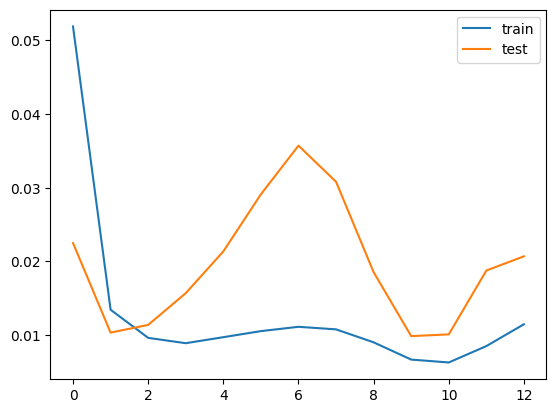

275/275 [==============================] - 1s 2ms/step
MAPE: 10.983883270321613
RMSE: 1478.7406347521407
Correlation 0.9261399650944598 with p-value 0.0
---------------
24116 8759
shape 1 19
Epoch 1/50
189/189 - 4s - loss: 0.0428 - val_loss: 0.0133 - 4s/epoch - 21ms/step
Epoch 2/50
189/189 - 1s - loss: 0.0090 - val_loss: 0.0085 - 1s/epoch - 6ms/step
Epoch 3/50
189/189 - 1s - loss: 0.0063 - val_loss: 0.0082 - 1s/epoch - 7ms/step
Epoch 4/50
189/189 - 1s - loss: 0.0059 - val_loss: 0.0092 - 1s/epoch - 7ms/step
Epoch 5/50
189/189 - 1s - loss: 0.0059 - val_loss: 0.0128 - 1s/epoch - 8ms/step
Epoch 6/50
189/189 - 2s - loss: 0.0064 - val_loss: 0.0227 - 2s/epoch - 10ms/step
Epoch 7/50
189/189 - 3s - loss: 0.0074 - val_loss: 0.0407 - 3s/epoch - 15ms/step
Epoch 8/50
189/189 - 1s - loss: 0.0088 - val_loss: 0.0644 - 1s/epoch - 6ms/step
Epoch 9/50
189/189 - 1s - loss: 0.0108 - val_loss: 0.0851 - 1s/epoch - 6ms/step
Epoch 10/50
189/189 - 1s - loss: 0.0126 - val_loss: 0.0901 - 1s/epoch - 7ms/step
Epoch

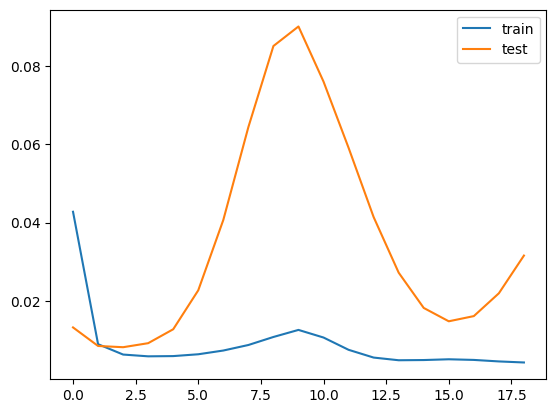

274/274 [==============================] - 2s 3ms/step
MAPE: 12.372487978636988
RMSE: 1878.1829537063543
Correlation 0.9321783289902988 with p-value 0.0
---------------
32875 8759
shape 1 19
Epoch 1/50
257/257 - 4s - loss: 0.0313 - val_loss: 0.0092 - 4s/epoch - 17ms/step
Epoch 2/50
257/257 - 1s - loss: 0.0080 - val_loss: 0.0085 - 1s/epoch - 6ms/step
Epoch 3/50
257/257 - 2s - loss: 0.0089 - val_loss: 0.0318 - 2s/epoch - 6ms/step
Epoch 4/50
257/257 - 3s - loss: 0.0135 - val_loss: 0.0610 - 3s/epoch - 10ms/step
Epoch 5/50
257/257 - 3s - loss: 0.0143 - val_loss: 0.0469 - 3s/epoch - 10ms/step
Epoch 6/50
257/257 - 1s - loss: 0.0096 - val_loss: 0.0311 - 1s/epoch - 6ms/step
Epoch 7/50
257/257 - 2s - loss: 0.0064 - val_loss: 0.0190 - 2s/epoch - 10ms/step
Epoch 8/50
257/257 - 1s - loss: 0.0063 - val_loss: 0.0159 - 1s/epoch - 6ms/step
Epoch 9/50
257/257 - 1s - loss: 0.0072 - val_loss: 0.0202 - 1s/epoch - 6ms/step
Epoch 10/50
257/257 - 2s - loss: 0.0069 - val_loss: 0.0106 - 2s/epoch - 6ms/step
Epoc

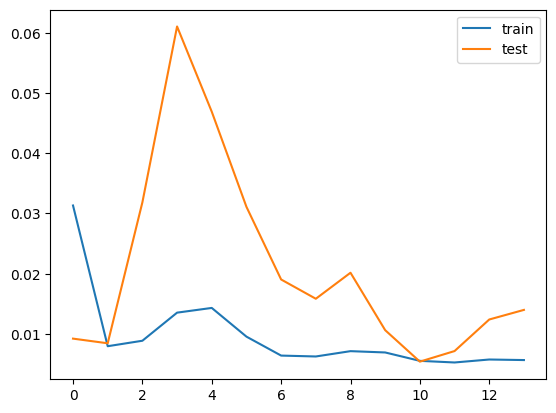

274/274 [==============================] - 1s 2ms/step
MAPE: 7.8150023603889345
RMSE: 1258.0617265588703
Correlation 0.9508275587542556 with p-value 0.0
---------------
41634 8759
shape 1 19
Epoch 1/50
326/326 - 5s - loss: 0.0256 - val_loss: 0.0143 - 5s/epoch - 17ms/step
Epoch 2/50
326/326 - 3s - loss: 0.0064 - val_loss: 0.0091 - 3s/epoch - 10ms/step
Epoch 3/50
326/326 - 2s - loss: 0.0054 - val_loss: 0.0093 - 2s/epoch - 6ms/step
Epoch 4/50
326/326 - 2s - loss: 0.0055 - val_loss: 0.0211 - 2s/epoch - 5ms/step
Epoch 5/50
326/326 - 2s - loss: 0.0064 - val_loss: 0.0412 - 2s/epoch - 5ms/step
Epoch 6/50
326/326 - 2s - loss: 0.0073 - val_loss: 0.0546 - 2s/epoch - 6ms/step
Epoch 7/50
326/326 - 2s - loss: 0.0071 - val_loss: 0.0528 - 2s/epoch - 6ms/step
Epoch 8/50
326/326 - 3s - loss: 0.0062 - val_loss: 0.0334 - 3s/epoch - 9ms/step
Epoch 9/50
326/326 - 3s - loss: 0.0068 - val_loss: 0.0142 - 3s/epoch - 9ms/step
Epoch 10/50
326/326 - 2s - loss: 0.0077 - val_loss: 0.0089 - 2s/epoch - 5ms/step
Epoch 

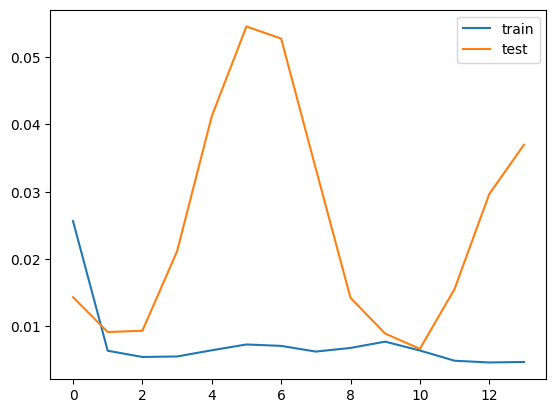

274/274 [==============================] - 1s 3ms/step
MAPE: 13.943570452755665
RMSE: 2044.2441152462168
Correlation 0.896804477587259 with p-value 0.0
---------------
50393 8784
shape 1 19
Epoch 1/50
394/394 - 6s - loss: 0.0255 - val_loss: 0.0247 - 6s/epoch - 14ms/step
Epoch 2/50
394/394 - 2s - loss: 0.0082 - val_loss: 0.0154 - 2s/epoch - 6ms/step
Epoch 3/50
394/394 - 2s - loss: 0.0091 - val_loss: 0.0569 - 2s/epoch - 6ms/step
Epoch 4/50
394/394 - 3s - loss: 0.0157 - val_loss: 0.0569 - 3s/epoch - 7ms/step
Epoch 5/50
394/394 - 4s - loss: 0.0106 - val_loss: 0.0126 - 4s/epoch - 9ms/step
Epoch 6/50
394/394 - 3s - loss: 0.0071 - val_loss: 0.0428 - 3s/epoch - 8ms/step
Epoch 7/50
394/394 - 2s - loss: 0.0068 - val_loss: 0.0214 - 2s/epoch - 6ms/step
Epoch 8/50
394/394 - 2s - loss: 0.0051 - val_loss: 0.0123 - 2s/epoch - 6ms/step
Epoch 9/50
394/394 - 2s - loss: 0.0049 - val_loss: 0.0118 - 2s/epoch - 6ms/step
Epoch 10/50
394/394 - 4s - loss: 0.0048 - val_loss: 0.0103 - 4s/epoch - 9ms/step
Epoch 11

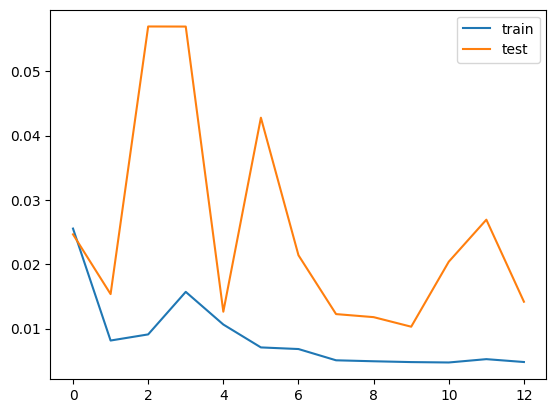

275/275 [==============================] - 1s 2ms/step
MAPE: 7.969526417780629
RMSE: 1266.6306579249092
Correlation 0.815520514928614 with p-value 0.0
---------------
59177 8760
shape 1 19
Epoch 1/50
463/463 - 5s - loss: 0.0263 - val_loss: 0.0151 - 5s/epoch - 12ms/step
Epoch 2/50
463/463 - 3s - loss: 0.0081 - val_loss: 0.0280 - 3s/epoch - 7ms/step
Epoch 3/50
463/463 - 4s - loss: 0.0100 - val_loss: 0.0619 - 4s/epoch - 8ms/step
Epoch 4/50
463/463 - 3s - loss: 0.0127 - val_loss: 0.0394 - 3s/epoch - 6ms/step
Epoch 5/50
463/463 - 2s - loss: 0.0090 - val_loss: 0.0109 - 2s/epoch - 5ms/step
Epoch 6/50
463/463 - 3s - loss: 0.0078 - val_loss: 0.0352 - 3s/epoch - 6ms/step
Epoch 7/50
463/463 - 3s - loss: 0.0075 - val_loss: 0.0114 - 3s/epoch - 6ms/step
Epoch 8/50
463/463 - 4s - loss: 0.0052 - val_loss: 0.0121 - 4s/epoch - 9ms/step
Epoch 9/50
463/463 - 3s - loss: 0.0051 - val_loss: 0.0127 - 3s/epoch - 6ms/step
Epoch 10/50
463/463 - 2s - loss: 0.0052 - val_loss: 0.0095 - 2s/epoch - 5ms/step
Epoch 11/

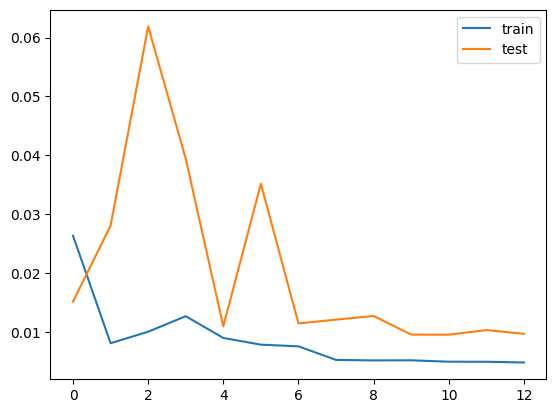

274/274 [==============================] - 1s 2ms/step
MAPE: 6.315457859954698
RMSE: 1045.5700831485244
Correlation 0.8642813133763056 with p-value 0.0
---------------
67937 8760
shape 1 19
Epoch 1/50
531/531 - 6s - loss: 0.0190 - val_loss: 0.0499 - 6s/epoch - 11ms/step
Epoch 2/50
531/531 - 4s - loss: 0.0080 - val_loss: 0.0196 - 4s/epoch - 7ms/step
Epoch 3/50
531/531 - 4s - loss: 0.0062 - val_loss: 0.0105 - 4s/epoch - 7ms/step
Epoch 4/50
531/531 - 3s - loss: 0.0056 - val_loss: 0.0091 - 3s/epoch - 6ms/step
Epoch 5/50
531/531 - 3s - loss: 0.0058 - val_loss: 0.0101 - 3s/epoch - 5ms/step
Epoch 6/50
531/531 - 3s - loss: 0.0057 - val_loss: 0.0104 - 3s/epoch - 6ms/step
Epoch 7/50
531/531 - 5s - loss: 0.0056 - val_loss: 0.0088 - 5s/epoch - 9ms/step
Epoch 8/50
531/531 - 3s - loss: 0.0053 - val_loss: 0.0073 - 3s/epoch - 5ms/step
Epoch 9/50
531/531 - 3s - loss: 0.0050 - val_loss: 0.0101 - 3s/epoch - 6ms/step
Epoch 10/50
531/531 - 3s - loss: 0.0051 - val_loss: 0.0160 - 3s/epoch - 5ms/step
Epoch 11

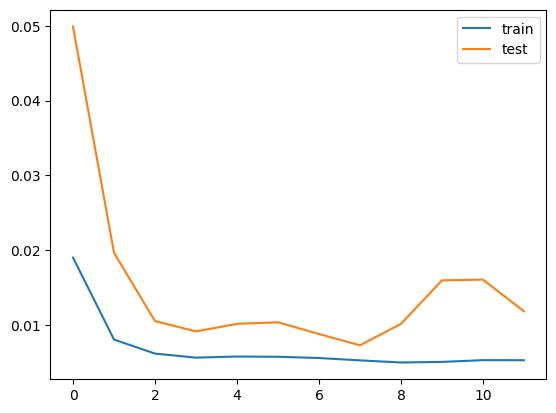

274/274 [==============================] - 1s 2ms/step
MAPE: 7.5856095128226455
RMSE: 1192.9244816619214
Correlation 0.8374998632165545 with p-value 0.0
---------------
76697 3622
shape 1 19
Epoch 1/50
600/600 - 8s - loss: 0.0169 - val_loss: 0.0162 - 8s/epoch - 13ms/step
Epoch 2/50
600/600 - 3s - loss: 0.0061 - val_loss: 0.0070 - 3s/epoch - 5ms/step
Epoch 3/50
600/600 - 3s - loss: 0.0056 - val_loss: 0.0165 - 3s/epoch - 5ms/step
Epoch 4/50
600/600 - 3s - loss: 0.0063 - val_loss: 0.0273 - 3s/epoch - 5ms/step
Epoch 5/50
600/600 - 5s - loss: 0.0064 - val_loss: 0.0161 - 5s/epoch - 8ms/step
Epoch 6/50
600/600 - 3s - loss: 0.0058 - val_loss: 0.0102 - 3s/epoch - 5ms/step
Epoch 7/50
600/600 - 3s - loss: 0.0060 - val_loss: 0.0440 - 3s/epoch - 5ms/step
Epoch 8/50
600/600 - 3s - loss: 0.0063 - val_loss: 0.0144 - 3s/epoch - 5ms/step
Epoch 9/50
600/600 - 4s - loss: 0.0054 - val_loss: 0.0098 - 4s/epoch - 7ms/step
Epoch 10/50
600/600 - 4s - loss: 0.0049 - val_loss: 0.0084 - 4s/epoch - 6ms/step
Epoch 1

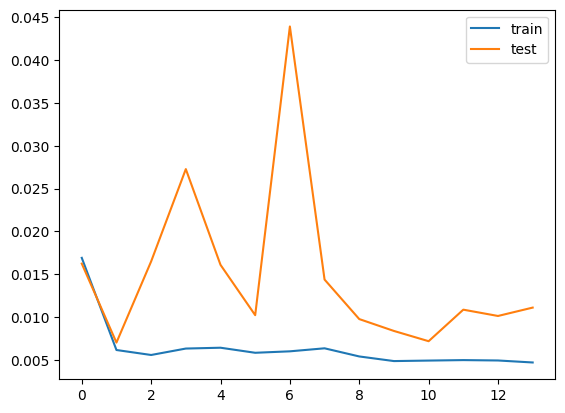

114/114 [==============================] - 1s 2ms/step
MAPE: 7.207704525780153
RMSE: 1172.863385964611
Correlation 0.8613947475879847 with p-value 0.0
---------------
AVG
----------------------------------
1417.15 & 9.27 & 0.89 & 1248.63 & 7.32 & 0.92 
----------------------------------
GENERAL FOLDS
----------------------------------
1478.74 & 10.98 & 0.93
1878.18 & 12.37 & 0.93
1258.06 & 7.82 & 0.95
2044.24 & 13.94 & 0.9
1266.63 & 7.97 & 0.82
1045.57 & 6.32 & 0.86
1192.92 & 7.59 & 0.84
1172.86 & 7.21 & 0.86
----------------------------------
WINTERTIME FOLDS
----------------------------------
1054.2 & 7.13 & 0.95
2211.39 & 13.59 & 0.9
1269.56 & 7.23 & 0.94
1501.63 & 9.28 & 0.93
1109.64 & 5.89 & 0.9
948.57 & 5.08 & 0.92
971.95 & 5.3 & 0.9
922.14 & 5.05 & 0.91


In [ ]:
rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list = run_cv(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=True,
    use_no_predictors=False,
    include_price_bool=False,
    include_climate_change_bool=False,
    huang=True,
    tan=False,
    train_test_indices=train_test_indices,
    folder_name='all_predictors'
)

### No predictors

15333 8783
shape 1 9
Epoch 1/50
120/120 - 3s - loss: 0.0608 - val_loss: 0.0196 - 3s/epoch - 29ms/step
Epoch 2/50
120/120 - 1s - loss: 0.0098 - val_loss: 0.0131 - 663ms/epoch - 6ms/step
Epoch 3/50
120/120 - 1s - loss: 0.0058 - val_loss: 0.0109 - 843ms/epoch - 7ms/step
Epoch 4/50
120/120 - 1s - loss: 0.0051 - val_loss: 0.0088 - 688ms/epoch - 6ms/step
Epoch 5/50
120/120 - 1s - loss: 0.0047 - val_loss: 0.0074 - 688ms/epoch - 6ms/step
Epoch 6/50
120/120 - 1s - loss: 0.0045 - val_loss: 0.0065 - 685ms/epoch - 6ms/step
Epoch 7/50
120/120 - 1s - loss: 0.0044 - val_loss: 0.0059 - 947ms/epoch - 8ms/step
Epoch 8/50
120/120 - 1s - loss: 0.0043 - val_loss: 0.0054 - 1s/epoch - 10ms/step
Epoch 9/50
120/120 - 1s - loss: 0.0042 - val_loss: 0.0052 - 1s/epoch - 11ms/step
Epoch 10/50
120/120 - 1s - loss: 0.0041 - val_loss: 0.0050 - 1s/epoch - 11ms/step
Epoch 11/50
120/120 - 1s - loss: 0.0040 - val_loss: 0.0049 - 880ms/epoch - 7ms/step
Epoch 12/50
120/120 - 1s - loss: 0.0039 - val_loss: 0.0048 - 716ms/epoch

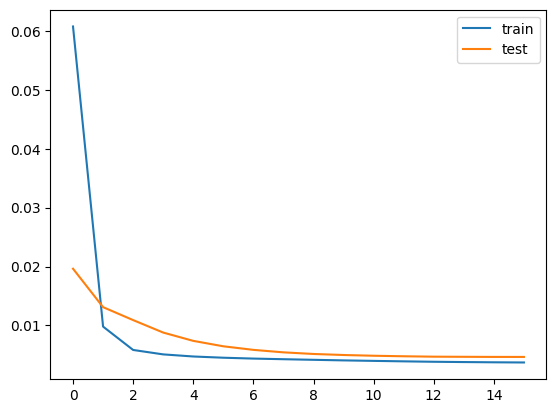

275/275 [==============================] - 1s 2ms/step
MAPE: 4.407747377044151
RMSE: 701.1721580436717
Correlation 0.956592374357023 with p-value 0.0
---------------
24116 8759
shape 1 9
Epoch 1/50
189/189 - 4s - loss: 0.0417 - val_loss: 0.0142 - 4s/epoch - 20ms/step
Epoch 2/50
189/189 - 2s - loss: 0.0096 - val_loss: 0.0093 - 2s/epoch - 9ms/step
Epoch 3/50
189/189 - 2s - loss: 0.0063 - val_loss: 0.0081 - 2s/epoch - 10ms/step
Epoch 4/50
189/189 - 2s - loss: 0.0052 - val_loss: 0.0081 - 2s/epoch - 10ms/step
Epoch 5/50
189/189 - 1s - loss: 0.0048 - val_loss: 0.0083 - 1s/epoch - 5ms/step
Epoch 6/50
189/189 - 1s - loss: 0.0046 - val_loss: 0.0085 - 1s/epoch - 6ms/step
Epoch 7/50
189/189 - 1s - loss: 0.0044 - val_loss: 0.0087 - 1s/epoch - 6ms/step
Epoch 8/50
189/189 - 1s - loss: 0.0043 - val_loss: 0.0089 - 1s/epoch - 6ms/step
Epoch 9/50
189/189 - 1s - loss: 0.0042 - val_loss: 0.0091 - 1s/epoch - 6ms/step
Epoch 10/50
189/189 - 1s - loss: 0.0041 - val_loss: 0.0095 - 1s/epoch - 5ms/step
Epoch 11/

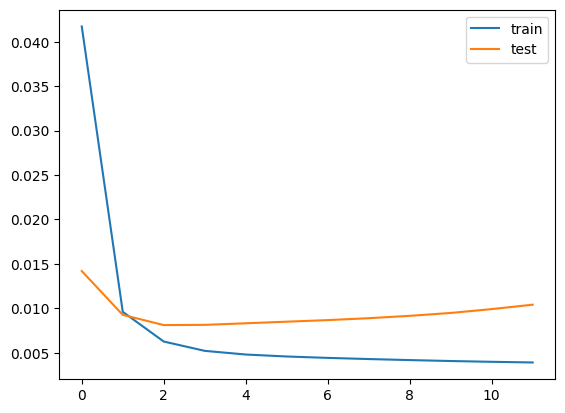

274/274 [==============================] - 1s 2ms/step
MAPE: 6.8228739262753555
RMSE: 1077.4829548622024
Correlation 0.9435478380316421 with p-value 0.0
---------------
32875 8759
shape 1 9
Epoch 1/50
257/257 - 5s - loss: 0.0348 - val_loss: 0.0139 - 5s/epoch - 20ms/step
Epoch 2/50
257/257 - 1s - loss: 0.0069 - val_loss: 0.0097 - 1s/epoch - 5ms/step
Epoch 3/50
257/257 - 1s - loss: 0.0053 - val_loss: 0.0077 - 1s/epoch - 5ms/step
Epoch 4/50
257/257 - 1s - loss: 0.0048 - val_loss: 0.0065 - 1s/epoch - 5ms/step
Epoch 5/50
257/257 - 1s - loss: 0.0046 - val_loss: 0.0057 - 1s/epoch - 6ms/step
Epoch 6/50
257/257 - 1s - loss: 0.0045 - val_loss: 0.0051 - 1s/epoch - 5ms/step
Epoch 7/50
257/257 - 2s - loss: 0.0044 - val_loss: 0.0046 - 2s/epoch - 7ms/step
Epoch 8/50
257/257 - 2s - loss: 0.0043 - val_loss: 0.0043 - 2s/epoch - 9ms/step
Epoch 9/50
257/257 - 2s - loss: 0.0042 - val_loss: 0.0041 - 2s/epoch - 7ms/step
Epoch 10/50
257/257 - 1s - loss: 0.0041 - val_loss: 0.0040 - 1s/epoch - 5ms/step
Epoch 11

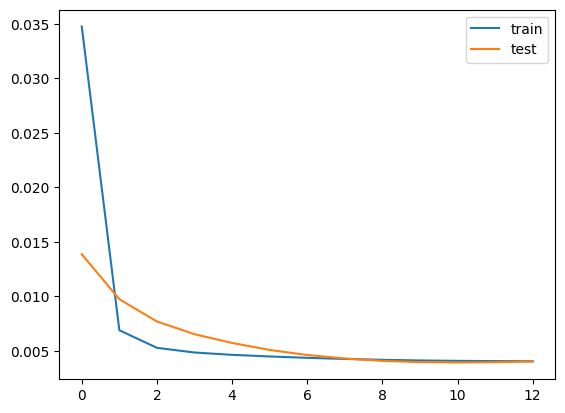

274/274 [==============================] - 1s 2ms/step
MAPE: 3.9679553941818915
RMSE: 674.9134296225611
Correlation 0.9583026774118149 with p-value 0.0
---------------
41634 8759
shape 1 9
Epoch 1/50
326/326 - 8s - loss: 0.0333 - val_loss: 0.0106 - 8s/epoch - 24ms/step
Epoch 2/50
326/326 - 2s - loss: 0.0069 - val_loss: 0.0092 - 2s/epoch - 6ms/step
Epoch 3/50
326/326 - 2s - loss: 0.0055 - val_loss: 0.0071 - 2s/epoch - 6ms/step
Epoch 4/50
326/326 - 2s - loss: 0.0050 - val_loss: 0.0060 - 2s/epoch - 6ms/step
Epoch 5/50
326/326 - 2s - loss: 0.0048 - val_loss: 0.0053 - 2s/epoch - 6ms/step
Epoch 6/50
326/326 - 2s - loss: 0.0046 - val_loss: 0.0049 - 2s/epoch - 6ms/step
Epoch 7/50
326/326 - 3s - loss: 0.0045 - val_loss: 0.0046 - 3s/epoch - 9ms/step
Epoch 8/50
326/326 - 2s - loss: 0.0045 - val_loss: 0.0044 - 2s/epoch - 7ms/step
Epoch 9/50
326/326 - 2s - loss: 0.0044 - val_loss: 0.0043 - 2s/epoch - 6ms/step
Epoch 10/50
326/326 - 2s - loss: 0.0044 - val_loss: 0.0043 - 2s/epoch - 6ms/step
Epoch 11/

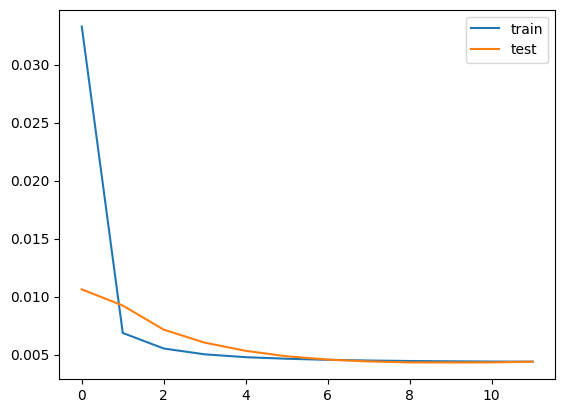

274/274 [==============================] - 1s 3ms/step
MAPE: 4.300579897077935
RMSE: 704.002390606536
Correlation 0.9557284181882385 with p-value 0.0
---------------
50393 8784
shape 1 9
Epoch 1/50
394/394 - 6s - loss: 0.0252 - val_loss: 0.0155 - 6s/epoch - 15ms/step
Epoch 2/50
394/394 - 2s - loss: 0.0054 - val_loss: 0.0147 - 2s/epoch - 6ms/step
Epoch 3/50
394/394 - 2s - loss: 0.0048 - val_loss: 0.0144 - 2s/epoch - 5ms/step
Epoch 4/50
394/394 - 2s - loss: 0.0046 - val_loss: 0.0141 - 2s/epoch - 6ms/step
Epoch 5/50
394/394 - 3s - loss: 0.0044 - val_loss: 0.0138 - 3s/epoch - 8ms/step
Epoch 6/50
394/394 - 3s - loss: 0.0043 - val_loss: 0.0135 - 3s/epoch - 8ms/step
Epoch 7/50
394/394 - 2s - loss: 0.0042 - val_loss: 0.0133 - 2s/epoch - 5ms/step
Epoch 8/50
394/394 - 2s - loss: 0.0041 - val_loss: 0.0131 - 2s/epoch - 5ms/step
Epoch 9/50
394/394 - 2s - loss: 0.0040 - val_loss: 0.0131 - 2s/epoch - 5ms/step
Epoch 10/50
394/394 - 2s - loss: 0.0040 - val_loss: 0.0131 - 2s/epoch - 5ms/step
Epoch 11/50

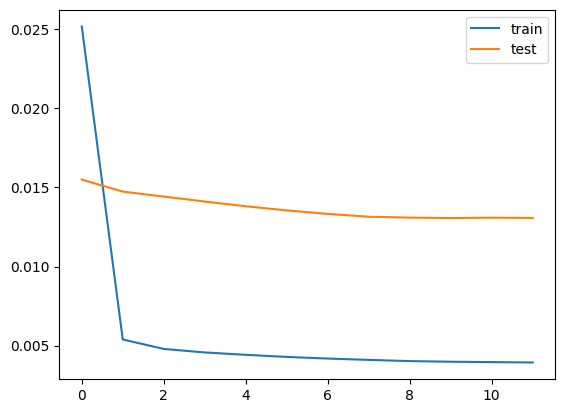

275/275 [==============================] - 1s 3ms/step
MAPE: 7.779143736695753
RMSE: 1215.82720924955
Correlation 0.855956815277805 with p-value 0.0
---------------
59177 8760
shape 1 9
Epoch 1/50
463/463 - 5s - loss: 0.0238 - val_loss: 0.0200 - 5s/epoch - 11ms/step
Epoch 2/50
463/463 - 2s - loss: 0.0073 - val_loss: 0.0173 - 2s/epoch - 5ms/step
Epoch 3/50
463/463 - 2s - loss: 0.0058 - val_loss: 0.0132 - 2s/epoch - 5ms/step
Epoch 4/50
463/463 - 4s - loss: 0.0053 - val_loss: 0.0115 - 4s/epoch - 9ms/step
Epoch 5/50
463/463 - 3s - loss: 0.0051 - val_loss: 0.0105 - 3s/epoch - 5ms/step
Epoch 6/50
463/463 - 2s - loss: 0.0049 - val_loss: 0.0099 - 2s/epoch - 5ms/step
Epoch 7/50
463/463 - 2s - loss: 0.0049 - val_loss: 0.0095 - 2s/epoch - 5ms/step
Epoch 8/50
463/463 - 2s - loss: 0.0048 - val_loss: 0.0090 - 2s/epoch - 5ms/step
Epoch 9/50
463/463 - 3s - loss: 0.0048 - val_loss: 0.0088 - 3s/epoch - 7ms/step
Epoch 10/50
463/463 - 4s - loss: 0.0047 - val_loss: 0.0086 - 4s/epoch - 8ms/step
Epoch 11/50


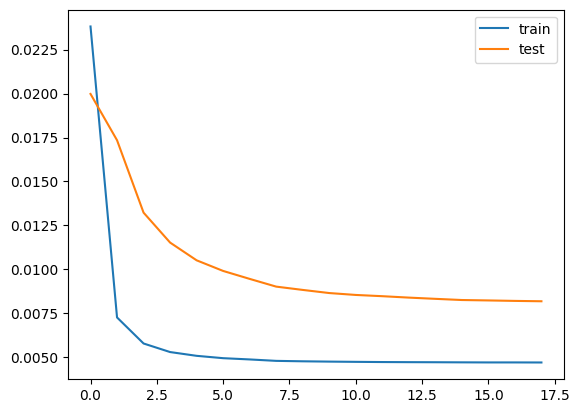

274/274 [==============================] - 1s 2ms/step
MAPE: 5.802022691734354
RMSE: 962.0060103509587
Correlation 0.8864613804409871 with p-value 0.0
---------------
67937 8760
shape 1 9
Epoch 1/50
531/531 - 5s - loss: 0.0231 - val_loss: 0.0090 - 5s/epoch - 10ms/step
Epoch 2/50
531/531 - 4s - loss: 0.0054 - val_loss: 0.0083 - 4s/epoch - 7ms/step
Epoch 3/50
531/531 - 3s - loss: 0.0050 - val_loss: 0.0081 - 3s/epoch - 6ms/step
Epoch 4/50
531/531 - 2s - loss: 0.0049 - val_loss: 0.0080 - 2s/epoch - 5ms/step
Epoch 5/50
531/531 - 3s - loss: 0.0049 - val_loss: 0.0079 - 3s/epoch - 5ms/step
Epoch 6/50
531/531 - 2s - loss: 0.0048 - val_loss: 0.0079 - 2s/epoch - 5ms/step
Epoch 7/50
531/531 - 4s - loss: 0.0047 - val_loss: 0.0078 - 4s/epoch - 7ms/step
Epoch 8/50
531/531 - 4s - loss: 0.0047 - val_loss: 0.0078 - 4s/epoch - 7ms/step
Epoch 9/50
531/531 - 3s - loss: 0.0046 - val_loss: 0.0077 - 3s/epoch - 5ms/step
Epoch 10/50
531/531 - 3s - loss: 0.0046 - val_loss: 0.0077 - 3s/epoch - 5ms/step
Epoch 11/5

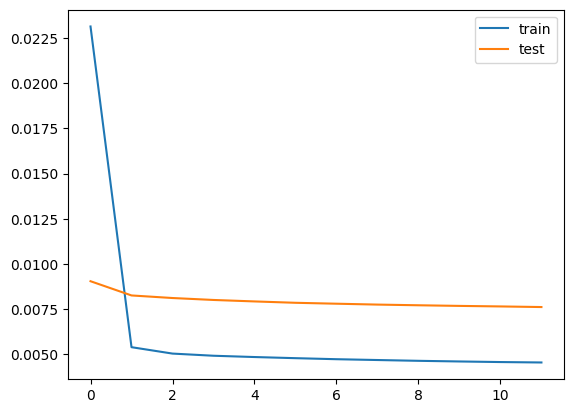

274/274 [==============================] - 1s 3ms/step
MAPE: 5.531606110421331
RMSE: 957.6280771407428
Correlation 0.8738309798518799 with p-value 0.0
---------------
76697 3622
shape 1 9
Epoch 1/50
600/600 - 5s - loss: 0.0174 - val_loss: 0.0098 - 5s/epoch - 9ms/step
Epoch 2/50
600/600 - 3s - loss: 0.0055 - val_loss: 0.0084 - 3s/epoch - 4ms/step
Epoch 3/50
600/600 - 4s - loss: 0.0052 - val_loss: 0.0081 - 4s/epoch - 6ms/step
Epoch 4/50
600/600 - 4s - loss: 0.0051 - val_loss: 0.0080 - 4s/epoch - 6ms/step
Epoch 5/50
600/600 - 3s - loss: 0.0050 - val_loss: 0.0080 - 3s/epoch - 5ms/step
Epoch 6/50
600/600 - 3s - loss: 0.0050 - val_loss: 0.0079 - 3s/epoch - 4ms/step
Epoch 7/50
600/600 - 3s - loss: 0.0050 - val_loss: 0.0079 - 3s/epoch - 4ms/step
Epoch 8/50
600/600 - 5s - loss: 0.0049 - val_loss: 0.0080 - 5s/epoch - 8ms/step
Epoch 9/50
600/600 - 3s - loss: 0.0049 - val_loss: 0.0080 - 3s/epoch - 5ms/step
Epoch 10/50
600/600 - 3s - loss: 0.0049 - val_loss: 0.0080 - 3s/epoch - 4ms/step
Epoch 11/50

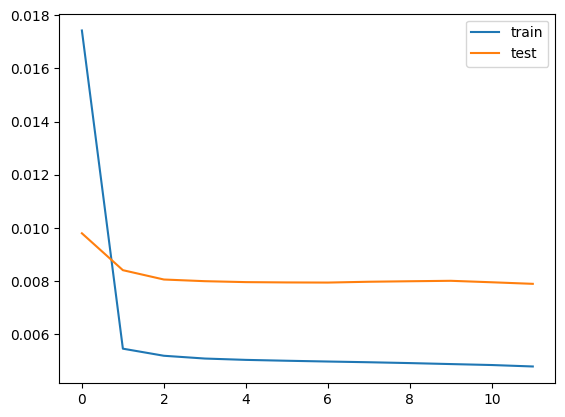

114/114 [==============================] - 1s 3ms/step
MAPE: 5.748596030478264
RMSE: 988.7170334794052
Correlation 0.9026102930210698 with p-value 0.0
---------------
AVG
----------------------------------
910.22 & 5.55 & 0.92 & 934.13 & 5.23 & 0.93 
----------------------------------
GENERAL FOLDS
----------------------------------
701.172 & 4.408 & 0.957
1077.483 & 6.823 & 0.944
674.913 & 3.968 & 0.958
704.002 & 4.301 & 0.956
1215.827 & 7.779 & 0.856
962.006 & 5.802 & 0.886
957.628 & 5.532 & 0.874
988.717 & 5.749 & 0.903
----------------------------------
WINTERTIME FOLDS
----------------------------------
824.559 & 4.908 & 0.948
1291.111 & 7.466 & 0.914
847.091 & 4.493 & 0.949
853.974 & 4.639 & 0.944
956.52 & 5.494 & 0.912
838.501 & 4.967 & 0.933
938.356 & 4.956 & 0.905
922.922 & 4.94 & 0.907


In [ ]:
rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list = run_cv(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=False,
    use_no_predictors=True,
    include_price_bool=False,
    include_climate_change_bool=False,
    huang=True,
    tan=False,
    train_test_indices=train_test_indices,
    folder_name='no_predictors'
)

# Tan

### All predictors

15333 8783
shape 1 19
Epoch 1/50
120/120 - 5s - loss: 0.0541 - val_loss: 0.0527 - 5s/epoch - 38ms/step
Epoch 2/50
120/120 - 1s - loss: 0.0381 - val_loss: 0.0341 - 752ms/epoch - 6ms/step
Epoch 3/50
120/120 - 1s - loss: 0.0294 - val_loss: 0.0224 - 767ms/epoch - 6ms/step
Epoch 4/50
120/120 - 1s - loss: 0.0245 - val_loss: 0.0170 - 869ms/epoch - 7ms/step
Epoch 5/50
120/120 - 1s - loss: 0.0219 - val_loss: 0.0151 - 875ms/epoch - 7ms/step
Epoch 6/50
120/120 - 1s - loss: 0.0194 - val_loss: 0.0145 - 1s/epoch - 10ms/step
Epoch 7/50
120/120 - 1s - loss: 0.0179 - val_loss: 0.0138 - 1s/epoch - 10ms/step
Epoch 8/50
120/120 - 1s - loss: 0.0170 - val_loss: 0.0138 - 1s/epoch - 10ms/step
Epoch 9/50
120/120 - 1s - loss: 0.0156 - val_loss: 0.0126 - 1s/epoch - 10ms/step
Epoch 10/50
120/120 - 1s - loss: 0.0154 - val_loss: 0.0123 - 744ms/epoch - 6ms/step
Epoch 11/50
120/120 - 1s - loss: 0.0148 - val_loss: 0.0126 - 750ms/epoch - 6ms/step
Epoch 12/50
120/120 - 1s - loss: 0.0142 - val_loss: 0.0129 - 890ms/epoch 

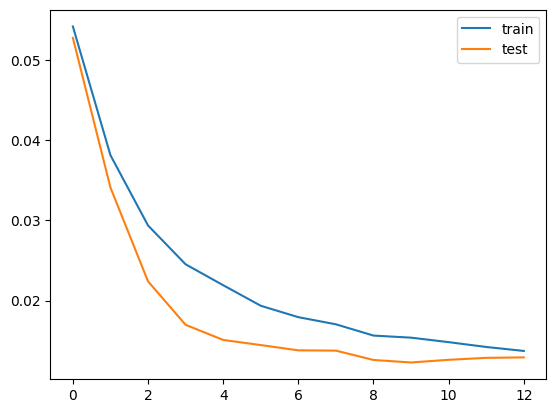

275/275 [==============================] - 2s 3ms/step
MAPE: 8.152336892608393
RMSE: 1168.6031785251378
Correlation 0.8903456741098416 with p-value 0.0
---------------
24116 8759
shape 1 19
Epoch 1/50
189/189 - 11s - loss: 0.0492 - val_loss: 0.0384 - 11s/epoch - 57ms/step
Epoch 2/50
189/189 - 2s - loss: 0.0336 - val_loss: 0.0224 - 2s/epoch - 11ms/step
Epoch 3/50
189/189 - 2s - loss: 0.0246 - val_loss: 0.0167 - 2s/epoch - 10ms/step
Epoch 4/50
189/189 - 2s - loss: 0.0205 - val_loss: 0.0145 - 2s/epoch - 8ms/step
Epoch 5/50
189/189 - 2s - loss: 0.0177 - val_loss: 0.0139 - 2s/epoch - 8ms/step
Epoch 6/50
189/189 - 1s - loss: 0.0159 - val_loss: 0.0137 - 1s/epoch - 8ms/step
Epoch 7/50
189/189 - 1s - loss: 0.0144 - val_loss: 0.0131 - 1s/epoch - 8ms/step
Epoch 8/50
189/189 - 2s - loss: 0.0134 - val_loss: 0.0172 - 2s/epoch - 8ms/step
Epoch 9/50
189/189 - 2s - loss: 0.0125 - val_loss: 0.0149 - 2s/epoch - 8ms/step
Epoch 10/50
189/189 - 2s - loss: 0.0120 - val_loss: 0.0160 - 2s/epoch - 10ms/step
Epo

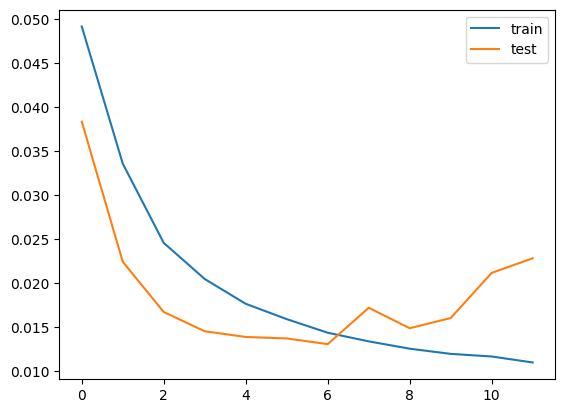

274/274 [==============================] - 1s 3ms/step
MAPE: 9.910180666934544
RMSE: 1596.4240513053294
Correlation 0.9031578659109039 with p-value 0.0
---------------
32875 8759
shape 1 19
Epoch 1/50
257/257 - 7s - loss: 0.0427 - val_loss: 0.0424 - 7s/epoch - 28ms/step
Epoch 2/50
257/257 - 2s - loss: 0.0262 - val_loss: 0.0289 - 2s/epoch - 7ms/step
Epoch 3/50
257/257 - 2s - loss: 0.0200 - val_loss: 0.0273 - 2s/epoch - 7ms/step
Epoch 4/50
257/257 - 2s - loss: 0.0168 - val_loss: 0.0236 - 2s/epoch - 7ms/step
Epoch 5/50
257/257 - 2s - loss: 0.0155 - val_loss: 0.0243 - 2s/epoch - 7ms/step
Epoch 6/50
257/257 - 3s - loss: 0.0141 - val_loss: 0.0208 - 3s/epoch - 10ms/step
Epoch 7/50
257/257 - 3s - loss: 0.0134 - val_loss: 0.0218 - 3s/epoch - 10ms/step
Epoch 8/50
257/257 - 2s - loss: 0.0129 - val_loss: 0.0203 - 2s/epoch - 7ms/step
Epoch 9/50
257/257 - 2s - loss: 0.0125 - val_loss: 0.0190 - 2s/epoch - 7ms/step
Epoch 10/50
257/257 - 2s - loss: 0.0119 - val_loss: 0.0193 - 2s/epoch - 7ms/step
Epoch 

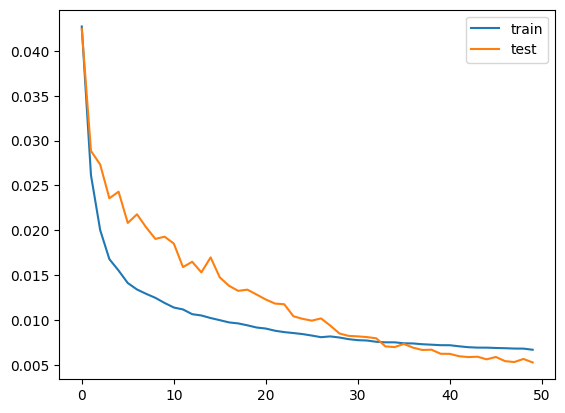

274/274 [==============================] - 1s 2ms/step
MAPE: 4.553134029655924
RMSE: 770.7968329066113
Correlation 0.9459088655296192 with p-value 0.0
---------------
41634 8759
shape 1 19
Epoch 1/50
326/326 - 6s - loss: 0.0428 - val_loss: 0.0185 - 6s/epoch - 19ms/step
Epoch 2/50
326/326 - 3s - loss: 0.0240 - val_loss: 0.0146 - 3s/epoch - 10ms/step
Epoch 3/50
326/326 - 2s - loss: 0.0180 - val_loss: 0.0135 - 2s/epoch - 7ms/step
Epoch 4/50
326/326 - 2s - loss: 0.0153 - val_loss: 0.0160 - 2s/epoch - 7ms/step
Epoch 5/50
326/326 - 2s - loss: 0.0138 - val_loss: 0.0160 - 2s/epoch - 7ms/step
Epoch 6/50
326/326 - 2s - loss: 0.0126 - val_loss: 0.0195 - 2s/epoch - 7ms/step
Epoch 7/50
326/326 - 3s - loss: 0.0120 - val_loss: 0.0267 - 3s/epoch - 8ms/step
Epoch 8/50
326/326 - 3s - loss: 0.0112 - val_loss: 0.0283 - 3s/epoch - 10ms/step
Epoch 9/50
326/326 - 2s - loss: 0.0107 - val_loss: 0.0309 - 2s/epoch - 7ms/step
Epoch 10/50
326/326 - 2s - loss: 0.0104 - val_loss: 0.0312 - 2s/epoch - 7ms/step
Epoch 1

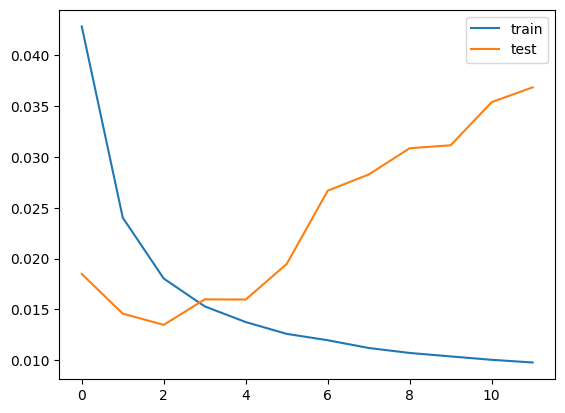

274/274 [==============================] - 1s 2ms/step
MAPE: 14.018822689853556
RMSE: 2041.1033333453165
Correlation 0.8772698836439727 with p-value 0.0
---------------
50393 8784
shape 1 19
Epoch 1/50
394/394 - 8s - loss: 0.0364 - val_loss: 0.0234 - 8s/epoch - 19ms/step
Epoch 2/50
394/394 - 2s - loss: 0.0197 - val_loss: 0.0242 - 2s/epoch - 6ms/step
Epoch 3/50
394/394 - 3s - loss: 0.0157 - val_loss: 0.0228 - 3s/epoch - 6ms/step
Epoch 4/50
394/394 - 2s - loss: 0.0137 - val_loss: 0.0274 - 2s/epoch - 6ms/step
Epoch 5/50
394/394 - 4s - loss: 0.0127 - val_loss: 0.0275 - 4s/epoch - 9ms/step
Epoch 6/50
394/394 - 3s - loss: 0.0118 - val_loss: 0.0290 - 3s/epoch - 7ms/step
Epoch 7/50
394/394 - 3s - loss: 0.0112 - val_loss: 0.0266 - 3s/epoch - 7ms/step
Epoch 8/50
394/394 - 2s - loss: 0.0106 - val_loss: 0.0274 - 2s/epoch - 6ms/step
Epoch 9/50
394/394 - 3s - loss: 0.0102 - val_loss: 0.0280 - 3s/epoch - 6ms/step
Epoch 10/50
394/394 - 3s - loss: 0.0098 - val_loss: 0.0273 - 3s/epoch - 9ms/step
Epoch 1

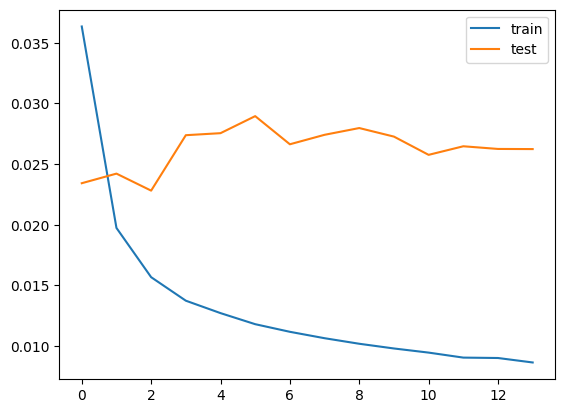

275/275 [==============================] - 2s 3ms/step
MAPE: 11.262865565734806
RMSE: 1722.6489454733091
Correlation 0.7093521041162927 with p-value 0.0
---------------
59177 8760
shape 1 19
Epoch 1/50
463/463 - 6s - loss: 0.0360 - val_loss: 0.0377 - 6s/epoch - 14ms/step
Epoch 2/50
463/463 - 3s - loss: 0.0192 - val_loss: 0.0249 - 3s/epoch - 6ms/step
Epoch 3/50
463/463 - 4s - loss: 0.0148 - val_loss: 0.0204 - 4s/epoch - 8ms/step
Epoch 4/50
463/463 - 3s - loss: 0.0130 - val_loss: 0.0166 - 3s/epoch - 7ms/step
Epoch 5/50
463/463 - 3s - loss: 0.0120 - val_loss: 0.0180 - 3s/epoch - 6ms/step
Epoch 6/50
463/463 - 3s - loss: 0.0113 - val_loss: 0.0146 - 3s/epoch - 6ms/step
Epoch 7/50
463/463 - 3s - loss: 0.0107 - val_loss: 0.0146 - 3s/epoch - 6ms/step
Epoch 8/50
463/463 - 4s - loss: 0.0103 - val_loss: 0.0133 - 4s/epoch - 9ms/step
Epoch 9/50
463/463 - 3s - loss: 0.0099 - val_loss: 0.0124 - 3s/epoch - 6ms/step
Epoch 10/50
463/463 - 3s - loss: 0.0095 - val_loss: 0.0120 - 3s/epoch - 6ms/step
Epoch 1

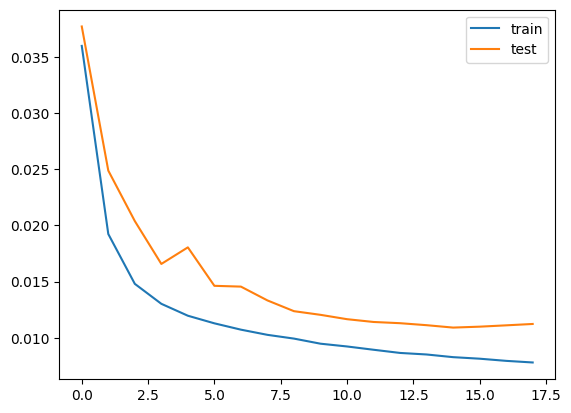

274/274 [==============================] - 1s 2ms/step
MAPE: 6.321845443786484
RMSE: 1126.8868696651937
Correlation 0.8514537348048995 with p-value 0.0
---------------
67937 8760
shape 1 19
Epoch 1/50
531/531 - 7s - loss: 0.0317 - val_loss: 0.0179 - 7s/epoch - 13ms/step
Epoch 2/50
531/531 - 4s - loss: 0.0161 - val_loss: 0.0131 - 4s/epoch - 8ms/step
Epoch 3/50
531/531 - 3s - loss: 0.0131 - val_loss: 0.0114 - 3s/epoch - 5ms/step
Epoch 4/50
531/531 - 3s - loss: 0.0117 - val_loss: 0.0106 - 3s/epoch - 5ms/step
Epoch 5/50
531/531 - 3s - loss: 0.0109 - val_loss: 0.0106 - 3s/epoch - 5ms/step
Epoch 6/50
531/531 - 4s - loss: 0.0103 - val_loss: 0.0108 - 4s/epoch - 7ms/step
Epoch 7/50
531/531 - 4s - loss: 0.0098 - val_loss: 0.0117 - 4s/epoch - 7ms/step
Epoch 8/50
531/531 - 3s - loss: 0.0094 - val_loss: 0.0126 - 3s/epoch - 5ms/step
Epoch 9/50
531/531 - 3s - loss: 0.0090 - val_loss: 0.0130 - 3s/epoch - 5ms/step
Epoch 10/50
531/531 - 3s - loss: 0.0086 - val_loss: 0.0139 - 3s/epoch - 5ms/step
Epoch 11

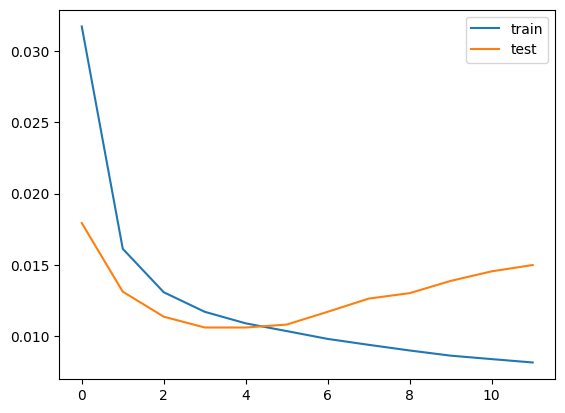

274/274 [==============================] - 1s 2ms/step
MAPE: 7.521831274818737
RMSE: 1342.9012198176717
Correlation 0.8471307663984912 with p-value 0.0
---------------
76697 3622
shape 1 19
Epoch 1/50
600/600 - 8s - loss: 0.0307 - val_loss: 0.0201 - 8s/epoch - 13ms/step
Epoch 2/50
600/600 - 4s - loss: 0.0164 - val_loss: 0.0138 - 4s/epoch - 6ms/step
Epoch 3/50
600/600 - 3s - loss: 0.0131 - val_loss: 0.0108 - 3s/epoch - 5ms/step
Epoch 4/50
600/600 - 3s - loss: 0.0118 - val_loss: 0.0100 - 3s/epoch - 5ms/step
Epoch 5/50
600/600 - 3s - loss: 0.0111 - val_loss: 0.0094 - 3s/epoch - 6ms/step
Epoch 6/50
600/600 - 5s - loss: 0.0106 - val_loss: 0.0092 - 5s/epoch - 8ms/step
Epoch 7/50
600/600 - 3s - loss: 0.0101 - val_loss: 0.0091 - 3s/epoch - 5ms/step
Epoch 8/50
600/600 - 3s - loss: 0.0097 - val_loss: 0.0098 - 3s/epoch - 5ms/step
Epoch 9/50
600/600 - 3s - loss: 0.0093 - val_loss: 0.0104 - 3s/epoch - 5ms/step
Epoch 10/50
600/600 - 5s - loss: 0.0090 - val_loss: 0.0111 - 5s/epoch - 8ms/step
Epoch 11

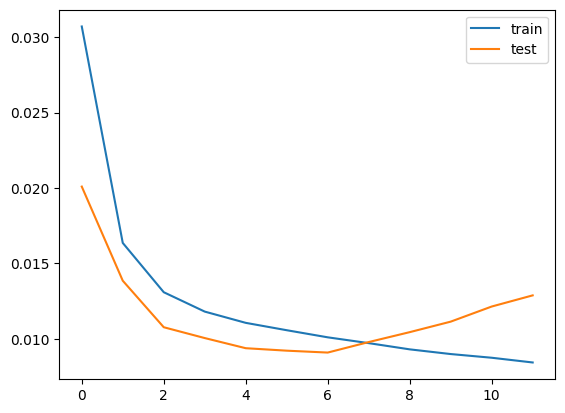

114/114 [==============================] - 1s 2ms/step
MAPE: 6.877910634625289
RMSE: 1262.9051092280138
Correlation 0.8722918702333412 with p-value 0.0
---------------
AVG
----------------------------------
1379.03 & 8.58 & 0.86 & 1366.5 & 7.63 & 0.9 
----------------------------------
GENERAL FOLDS
----------------------------------
1168.6 & 8.15 & 0.89
1596.42 & 9.91 & 0.9
770.8 & 4.55 & 0.95
2041.1 & 14.02 & 0.88
1722.65 & 11.26 & 0.71
1126.89 & 6.32 & 0.85
1342.9 & 7.52 & 0.85
1262.91 & 6.88 & 0.87
----------------------------------
WINTERTIME FOLDS
----------------------------------
1217.58 & 7.45 & 0.92
2026.11 & 11.99 & 0.85
935.21 & 4.9 & 0.94
1550.03 & 9.2 & 0.88
1525.65 & 8.16 & 0.87
1138.56 & 5.89 & 0.91
1413.26 & 7.59 & 0.9
1125.58 & 5.87 & 0.9


In [ ]:
rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list = run_cv(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=True,
    use_no_predictors=False,
    include_price_bool=False,
    include_climate_change_bool=False,
    huang=False,
    tan=True,
    train_test_indices=train_test_indices,
    folder_name='all_predictors'
)

### No predictors

15333 8783
shape 1 9
Epoch 1/50
120/120 - 5s - loss: 0.0520 - val_loss: 0.0518 - 5s/epoch - 38ms/step
Epoch 2/50
120/120 - 1s - loss: 0.0362 - val_loss: 0.0387 - 917ms/epoch - 8ms/step
Epoch 3/50
120/120 - 1s - loss: 0.0281 - val_loss: 0.0290 - 1s/epoch - 10ms/step
Epoch 4/50
120/120 - 1s - loss: 0.0238 - val_loss: 0.0257 - 1s/epoch - 10ms/step
Epoch 5/50
120/120 - 1s - loss: 0.0219 - val_loss: 0.0226 - 1s/epoch - 11ms/step
Epoch 6/50
120/120 - 1s - loss: 0.0193 - val_loss: 0.0231 - 928ms/epoch - 8ms/step
Epoch 7/50
120/120 - 1s - loss: 0.0183 - val_loss: 0.0240 - 868ms/epoch - 7ms/step
Epoch 8/50
120/120 - 1s - loss: 0.0173 - val_loss: 0.0224 - 881ms/epoch - 7ms/step
Epoch 9/50
120/120 - 1s - loss: 0.0161 - val_loss: 0.0251 - 745ms/epoch - 6ms/step
Epoch 10/50
120/120 - 1s - loss: 0.0156 - val_loss: 0.0234 - 741ms/epoch - 6ms/step
Epoch 11/50
120/120 - 1s - loss: 0.0152 - val_loss: 0.0234 - 720ms/epoch - 6ms/step
Epoch 12/50
120/120 - 1s - loss: 0.0149 - val_loss: 0.0277 - 738ms/epoch

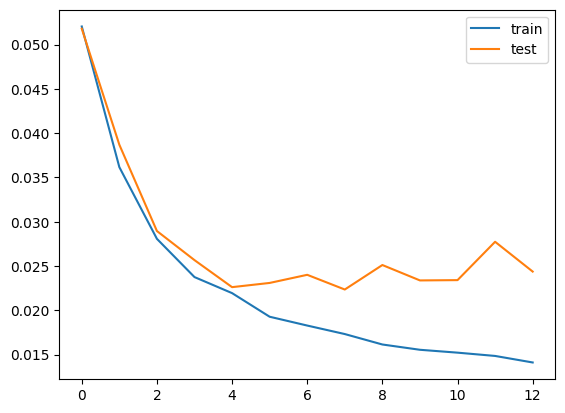

275/275 [==============================] - 1s 2ms/step
MAPE: 12.010388553751245
RMSE: 1604.7024150969405
Correlation 0.8740179283013229 with p-value 0.0
---------------
24116 8759
shape 1 9
Epoch 1/50
189/189 - 5s - loss: 0.0503 - val_loss: 0.0393 - 5s/epoch - 25ms/step
Epoch 2/50
189/189 - 1s - loss: 0.0330 - val_loss: 0.0275 - 1s/epoch - 6ms/step
Epoch 3/50
189/189 - 1s - loss: 0.0250 - val_loss: 0.0214 - 1s/epoch - 5ms/step
Epoch 4/50
189/189 - 2s - loss: 0.0210 - val_loss: 0.0212 - 2s/epoch - 9ms/step
Epoch 5/50
189/189 - 2s - loss: 0.0188 - val_loss: 0.0179 - 2s/epoch - 9ms/step
Epoch 6/50
189/189 - 2s - loss: 0.0170 - val_loss: 0.0183 - 2s/epoch - 9ms/step
Epoch 7/50
189/189 - 1s - loss: 0.0160 - val_loss: 0.0216 - 1s/epoch - 6ms/step
Epoch 8/50
189/189 - 1s - loss: 0.0150 - val_loss: 0.0196 - 1s/epoch - 6ms/step
Epoch 9/50
189/189 - 1s - loss: 0.0143 - val_loss: 0.0194 - 1s/epoch - 5ms/step
Epoch 10/50
189/189 - 1s - loss: 0.0137 - val_loss: 0.0195 - 1s/epoch - 5ms/step
Epoch 11

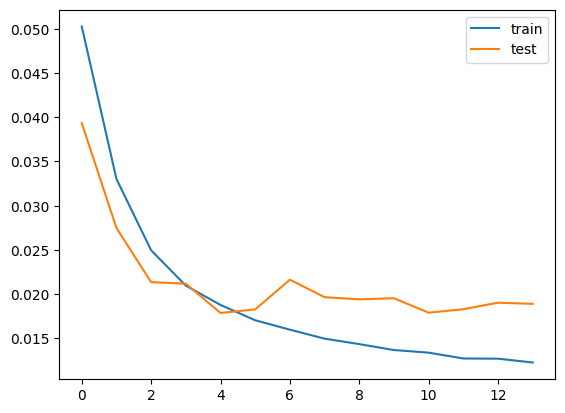

274/274 [==============================] - 1s 3ms/step
MAPE: 9.935931954281168
RMSE: 1452.2196523674734
Correlation 0.8593894398319972 with p-value 0.0
---------------
32875 8759
shape 1 9
Epoch 1/50
257/257 - 6s - loss: 0.0448 - val_loss: 0.0463 - 6s/epoch - 23ms/step
Epoch 2/50
257/257 - 2s - loss: 0.0279 - val_loss: 0.0327 - 2s/epoch - 6ms/step
Epoch 3/50
257/257 - 1s - loss: 0.0212 - val_loss: 0.0281 - 1s/epoch - 5ms/step
Epoch 4/50
257/257 - 1s - loss: 0.0182 - val_loss: 0.0272 - 1s/epoch - 5ms/step
Epoch 5/50
257/257 - 1s - loss: 0.0163 - val_loss: 0.0288 - 1s/epoch - 5ms/step
Epoch 6/50
257/257 - 2s - loss: 0.0150 - val_loss: 0.0274 - 2s/epoch - 6ms/step
Epoch 7/50
257/257 - 2s - loss: 0.0140 - val_loss: 0.0268 - 2s/epoch - 8ms/step
Epoch 8/50
257/257 - 2s - loss: 0.0133 - val_loss: 0.0269 - 2s/epoch - 8ms/step
Epoch 9/50
257/257 - 1s - loss: 0.0128 - val_loss: 0.0263 - 1s/epoch - 6ms/step
Epoch 10/50
257/257 - 1s - loss: 0.0122 - val_loss: 0.0269 - 1s/epoch - 6ms/step
Epoch 11/

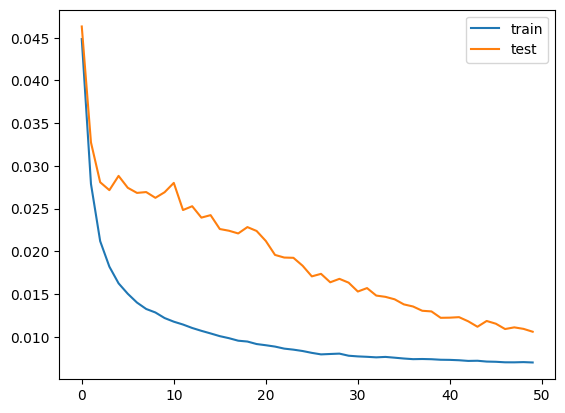

274/274 [==============================] - 1s 2ms/step
MAPE: 7.123837293577531
RMSE: 1094.2515755217103
Correlation 0.9319543116622429 with p-value 0.0
---------------
41634 8759
shape 1 9
Epoch 1/50
326/326 - 7s - loss: 0.0423 - val_loss: 0.0189 - 7s/epoch - 22ms/step
Epoch 2/50
326/326 - 2s - loss: 0.0243 - val_loss: 0.0131 - 2s/epoch - 6ms/step
Epoch 3/50
326/326 - 2s - loss: 0.0187 - val_loss: 0.0151 - 2s/epoch - 5ms/step
Epoch 4/50
326/326 - 2s - loss: 0.0161 - val_loss: 0.0150 - 2s/epoch - 5ms/step
Epoch 5/50
326/326 - 2s - loss: 0.0148 - val_loss: 0.0147 - 2s/epoch - 6ms/step
Epoch 6/50
326/326 - 2s - loss: 0.0137 - val_loss: 0.0164 - 2s/epoch - 6ms/step
Epoch 7/50
326/326 - 2s - loss: 0.0129 - val_loss: 0.0160 - 2s/epoch - 7ms/step
Epoch 8/50
326/326 - 3s - loss: 0.0124 - val_loss: 0.0165 - 3s/epoch - 8ms/step
Epoch 9/50
326/326 - 2s - loss: 0.0118 - val_loss: 0.0185 - 2s/epoch - 7ms/step
Epoch 10/50
326/326 - 2s - loss: 0.0115 - val_loss: 0.0205 - 2s/epoch - 6ms/step
Epoch 11/

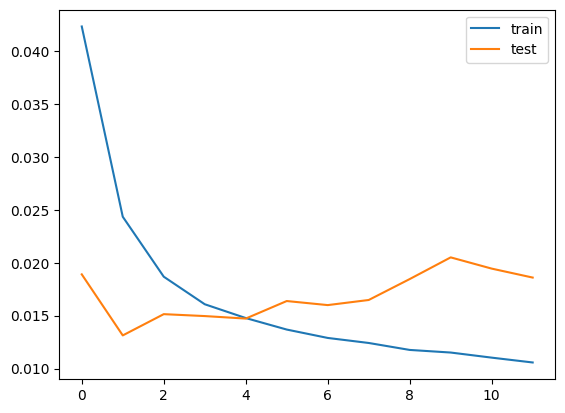

274/274 [==============================] - 1s 2ms/step
MAPE: 9.635400602399082
RMSE: 1450.0111563971925
Correlation 0.8590242818327353 with p-value 0.0
---------------
50393 8784
shape 1 9
Epoch 1/50
394/394 - 7s - loss: 0.0388 - val_loss: 0.0212 - 7s/epoch - 18ms/step
Epoch 2/50
394/394 - 2s - loss: 0.0219 - val_loss: 0.0201 - 2s/epoch - 6ms/step
Epoch 3/50
394/394 - 2s - loss: 0.0172 - val_loss: 0.0193 - 2s/epoch - 6ms/step
Epoch 4/50
394/394 - 2s - loss: 0.0150 - val_loss: 0.0229 - 2s/epoch - 6ms/step
Epoch 5/50
394/394 - 3s - loss: 0.0139 - val_loss: 0.0220 - 3s/epoch - 9ms/step
Epoch 6/50
394/394 - 3s - loss: 0.0130 - val_loss: 0.0243 - 3s/epoch - 7ms/step
Epoch 7/50
394/394 - 2s - loss: 0.0123 - val_loss: 0.0227 - 2s/epoch - 6ms/step
Epoch 8/50
394/394 - 2s - loss: 0.0118 - val_loss: 0.0221 - 2s/epoch - 6ms/step
Epoch 9/50
394/394 - 2s - loss: 0.0113 - val_loss: 0.0236 - 2s/epoch - 6ms/step
Epoch 10/50
394/394 - 2s - loss: 0.0109 - val_loss: 0.0236 - 2s/epoch - 6ms/step
Epoch 11/

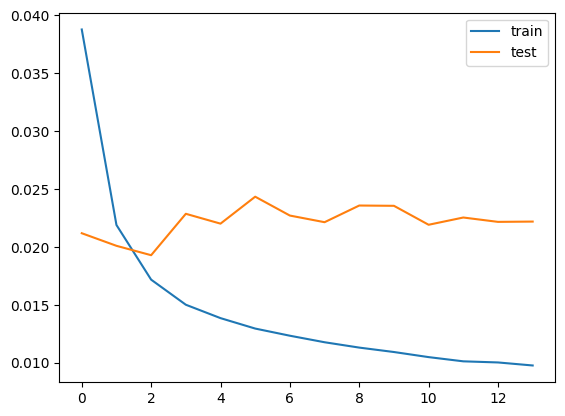

275/275 [==============================] - 2s 3ms/step
MAPE: 10.386283090053121
RMSE: 1584.5840265703973
Correlation 0.7590093780305165 with p-value 0.0
---------------
59177 8760
shape 1 9
Epoch 1/50
463/463 - 6s - loss: 0.0361 - val_loss: 0.0467 - 6s/epoch - 13ms/step
Epoch 2/50
463/463 - 3s - loss: 0.0196 - val_loss: 0.0358 - 3s/epoch - 6ms/step
Epoch 3/50
463/463 - 4s - loss: 0.0157 - val_loss: 0.0328 - 4s/epoch - 8ms/step
Epoch 4/50
463/463 - 3s - loss: 0.0142 - val_loss: 0.0324 - 3s/epoch - 6ms/step
Epoch 5/50
463/463 - 2s - loss: 0.0132 - val_loss: 0.0317 - 2s/epoch - 5ms/step
Epoch 6/50
463/463 - 2s - loss: 0.0124 - val_loss: 0.0279 - 2s/epoch - 5ms/step
Epoch 7/50
463/463 - 3s - loss: 0.0118 - val_loss: 0.0285 - 3s/epoch - 5ms/step
Epoch 8/50
463/463 - 3s - loss: 0.0112 - val_loss: 0.0255 - 3s/epoch - 7ms/step
Epoch 9/50
463/463 - 3s - loss: 0.0108 - val_loss: 0.0248 - 3s/epoch - 7ms/step
Epoch 10/50
463/463 - 2s - loss: 0.0103 - val_loss: 0.0241 - 2s/epoch - 5ms/step
Epoch 11

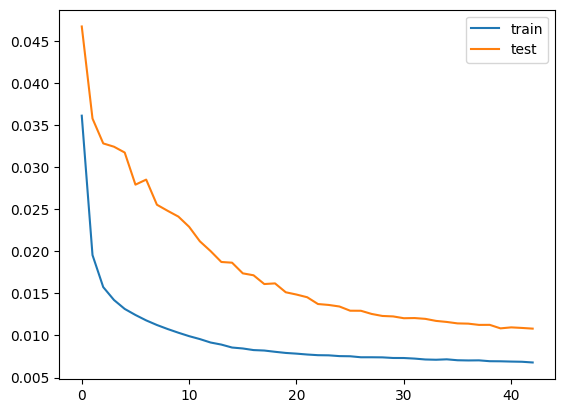

274/274 [==============================] - 1s 2ms/step
MAPE: 6.839071158757457
RMSE: 1105.9895297603707
Correlation 0.8500311199980183 with p-value 0.0
---------------
67937 8760
shape 1 9
Epoch 1/50
531/531 - 8s - loss: 0.0321 - val_loss: 0.0253 - 8s/epoch - 15ms/step
Epoch 2/50
531/531 - 3s - loss: 0.0180 - val_loss: 0.0244 - 3s/epoch - 5ms/step
Epoch 3/50
531/531 - 3s - loss: 0.0150 - val_loss: 0.0227 - 3s/epoch - 5ms/step
Epoch 4/50
531/531 - 3s - loss: 0.0136 - val_loss: 0.0226 - 3s/epoch - 6ms/step
Epoch 5/50
531/531 - 4s - loss: 0.0128 - val_loss: 0.0211 - 4s/epoch - 7ms/step
Epoch 6/50
531/531 - 3s - loss: 0.0121 - val_loss: 0.0217 - 3s/epoch - 5ms/step
Epoch 7/50
531/531 - 3s - loss: 0.0115 - val_loss: 0.0210 - 3s/epoch - 5ms/step
Epoch 8/50
531/531 - 3s - loss: 0.0110 - val_loss: 0.0191 - 3s/epoch - 5ms/step
Epoch 9/50
531/531 - 3s - loss: 0.0106 - val_loss: 0.0195 - 3s/epoch - 6ms/step
Epoch 10/50
531/531 - 4s - loss: 0.0102 - val_loss: 0.0182 - 4s/epoch - 8ms/step
Epoch 11/

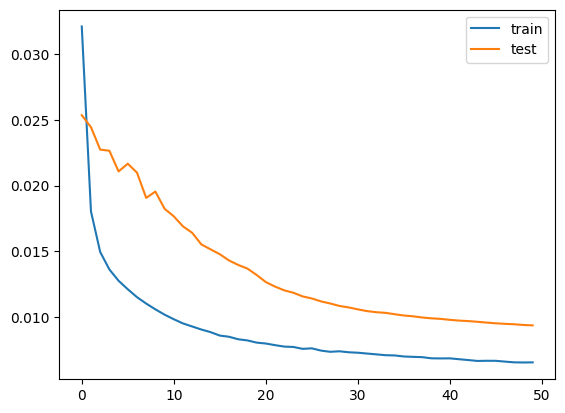

274/274 [==============================] - 1s 2ms/step
MAPE: 6.248524020869213
RMSE: 1063.1384164651631
Correlation 0.8419595458584003 with p-value 0.0
---------------
76697 3622
shape 1 9
Epoch 1/50
600/600 - 8s - loss: 0.0286 - val_loss: 0.0238 - 8s/epoch - 13ms/step
Epoch 2/50
600/600 - 3s - loss: 0.0159 - val_loss: 0.0210 - 3s/epoch - 5ms/step
Epoch 3/50
600/600 - 3s - loss: 0.0134 - val_loss: 0.0200 - 3s/epoch - 5ms/step
Epoch 4/50
600/600 - 3s - loss: 0.0124 - val_loss: 0.0198 - 3s/epoch - 5ms/step
Epoch 5/50
600/600 - 4s - loss: 0.0118 - val_loss: 0.0243 - 4s/epoch - 6ms/step
Epoch 6/50
600/600 - 4s - loss: 0.0113 - val_loss: 0.0198 - 4s/epoch - 6ms/step
Epoch 7/50
600/600 - 3s - loss: 0.0108 - val_loss: 0.0202 - 3s/epoch - 5ms/step
Epoch 8/50
600/600 - 3s - loss: 0.0104 - val_loss: 0.0200 - 3s/epoch - 5ms/step
Epoch 9/50
600/600 - 3s - loss: 0.0099 - val_loss: 0.0175 - 3s/epoch - 5ms/step
Epoch 10/50
600/600 - 4s - loss: 0.0096 - val_loss: 0.0168 - 4s/epoch - 7ms/step
Epoch 11/

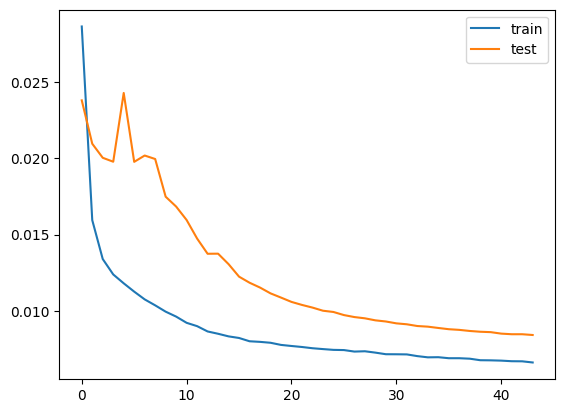

114/114 [==============================] - 1s 2ms/step
MAPE: 5.8055997716668015
RMSE: 1021.0976285221599
Correlation 0.87777670268491 with p-value 0.0
---------------
AVG
----------------------------------
1297.0 & 8.5 & 0.86 & 1060.95 & 6.07 & 0.91 
----------------------------------
GENERAL FOLDS
----------------------------------
1604.702 & 12.01 & 0.874
1452.22 & 9.936 & 0.859
1094.252 & 7.124 & 0.932
1450.011 & 9.635 & 0.859
1584.584 & 10.386 & 0.759
1105.99 & 6.839 & 0.85
1063.138 & 6.249 & 0.842
1021.098 & 5.806 & 0.878
----------------------------------
WINTERTIME FOLDS
----------------------------------
1157.998 & 7.704 & 0.915
1340.38 & 8.054 & 0.893
920.685 & 4.989 & 0.934
989.014 & 5.678 & 0.913
1045.812 & 6.05 & 0.885
930.094 & 4.991 & 0.923
1113.207 & 5.893 & 0.898
990.381 & 5.236 & 0.898


In [ ]:
rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list = run_cv(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=False,
    use_no_predictors=True,
    include_price_bool=False,
    include_climate_change_bool=False,
    huang=False,
    tan=True,
    train_test_indices=train_test_indices,
    folder_name='no_predictors'
    )

# With/without price

### Tan ALL

15333 8783
shape 1 17
Epoch 1/50
120/120 - 6s - loss: 0.0542 - val_loss: 0.0525 - 6s/epoch - 49ms/step
Epoch 2/50
120/120 - 1s - loss: 0.0400 - val_loss: 0.0377 - 1s/epoch - 11ms/step
Epoch 3/50
120/120 - 1s - loss: 0.0313 - val_loss: 0.0274 - 751ms/epoch - 6ms/step
Epoch 4/50
120/120 - 1s - loss: 0.0258 - val_loss: 0.0231 - 709ms/epoch - 6ms/step
Epoch 5/50
120/120 - 1s - loss: 0.0227 - val_loss: 0.0178 - 736ms/epoch - 6ms/step
Epoch 6/50
120/120 - 1s - loss: 0.0201 - val_loss: 0.0172 - 741ms/epoch - 6ms/step
Epoch 7/50
120/120 - 1s - loss: 0.0181 - val_loss: 0.0176 - 746ms/epoch - 6ms/step
Epoch 8/50
120/120 - 1s - loss: 0.0174 - val_loss: 0.0189 - 731ms/epoch - 6ms/step
Epoch 9/50
120/120 - 1s - loss: 0.0160 - val_loss: 0.0163 - 908ms/epoch - 8ms/step
Epoch 10/50
120/120 - 1s - loss: 0.0155 - val_loss: 0.0164 - 728ms/epoch - 6ms/step
Epoch 11/50
120/120 - 1s - loss: 0.0147 - val_loss: 0.0173 - 873ms/epoch - 7ms/step
Epoch 12/50
120/120 - 1s - loss: 0.0138 - val_loss: 0.0178 - 873ms/

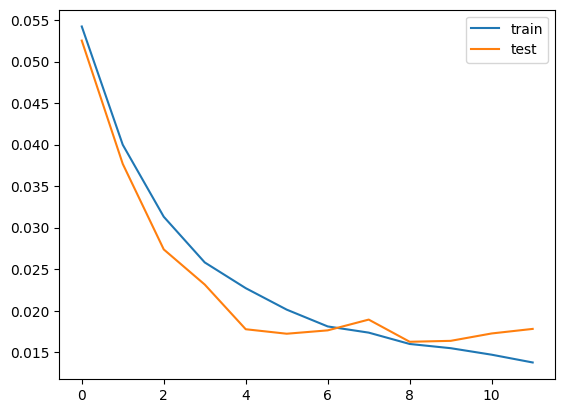

275/275 [==============================] - 1s 2ms/step
MAPE: 9.906626270381187
RMSE: 1371.6295971308884
Correlation 0.8728190049018993 with p-value 0.0
---------------
24116 8759
shape 1 17
Epoch 1/50
189/189 - 6s - loss: 0.0472 - val_loss: 0.0364 - 6s/epoch - 33ms/step
Epoch 2/50
189/189 - 1s - loss: 0.0302 - val_loss: 0.0203 - 1s/epoch - 6ms/step
Epoch 3/50
189/189 - 1s - loss: 0.0224 - val_loss: 0.0157 - 1s/epoch - 6ms/step
Epoch 4/50
189/189 - 1s - loss: 0.0190 - val_loss: 0.0142 - 1s/epoch - 6ms/step
Epoch 5/50
189/189 - 1s - loss: 0.0170 - val_loss: 0.0140 - 1s/epoch - 6ms/step
Epoch 6/50
189/189 - 1s - loss: 0.0154 - val_loss: 0.0135 - 1s/epoch - 6ms/step
Epoch 7/50
189/189 - 1s - loss: 0.0144 - val_loss: 0.0123 - 1s/epoch - 6ms/step
Epoch 8/50
189/189 - 1s - loss: 0.0135 - val_loss: 0.0134 - 1s/epoch - 6ms/step
Epoch 9/50
189/189 - 2s - loss: 0.0127 - val_loss: 0.0135 - 2s/epoch - 9ms/step
Epoch 10/50
189/189 - 2s - loss: 0.0122 - val_loss: 0.0131 - 2s/epoch - 9ms/step
Epoch 11

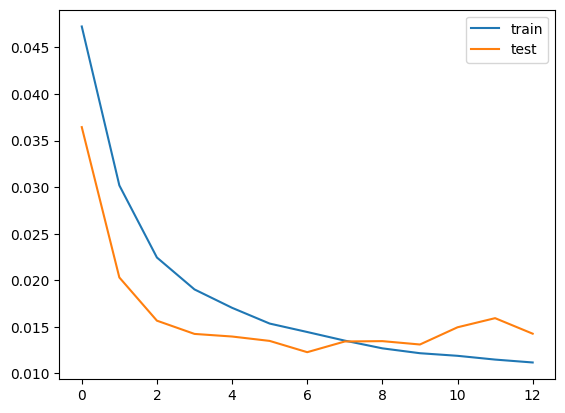

274/274 [==============================] - 1s 2ms/step
MAPE: 7.47560234146458
RMSE: 1261.962921546785
Correlation 0.8939907422466062 with p-value 0.0
---------------
32875 8759
shape 1 17
Epoch 1/50
257/257 - 5s - loss: 0.0462 - val_loss: 0.0402 - 5s/epoch - 19ms/step
Epoch 2/50
257/257 - 2s - loss: 0.0278 - val_loss: 0.0215 - 2s/epoch - 7ms/step
Epoch 3/50
257/257 - 2s - loss: 0.0209 - val_loss: 0.0179 - 2s/epoch - 9ms/step
Epoch 4/50
257/257 - 2s - loss: 0.0175 - val_loss: 0.0141 - 2s/epoch - 7ms/step
Epoch 5/50
257/257 - 1s - loss: 0.0154 - val_loss: 0.0136 - 1s/epoch - 5ms/step
Epoch 6/50
257/257 - 1s - loss: 0.0142 - val_loss: 0.0114 - 1s/epoch - 5ms/step
Epoch 7/50
257/257 - 1s - loss: 0.0133 - val_loss: 0.0104 - 1s/epoch - 6ms/step
Epoch 8/50
257/257 - 1s - loss: 0.0124 - val_loss: 0.0095 - 1s/epoch - 5ms/step
Epoch 9/50
257/257 - 1s - loss: 0.0121 - val_loss: 0.0083 - 1s/epoch - 5ms/step
Epoch 10/50
257/257 - 1s - loss: 0.0116 - val_loss: 0.0080 - 1s/epoch - 6ms/step
Epoch 11/5

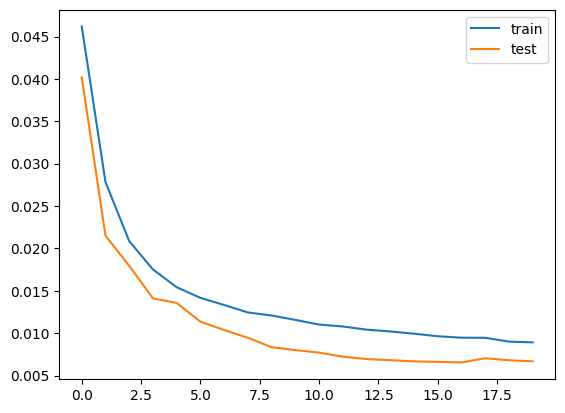

274/274 [==============================] - 1s 2ms/step
MAPE: 5.182727098974036
RMSE: 869.0735791060638
Correlation 0.9362179421881675 with p-value 0.0
---------------
41634 8759
shape 1 17
Epoch 1/50
326/326 - 7s - loss: 0.0417 - val_loss: 0.0164 - 7s/epoch - 21ms/step
Epoch 2/50
326/326 - 2s - loss: 0.0232 - val_loss: 0.0118 - 2s/epoch - 6ms/step
Epoch 3/50
326/326 - 2s - loss: 0.0181 - val_loss: 0.0097 - 2s/epoch - 5ms/step
Epoch 4/50
326/326 - 2s - loss: 0.0155 - val_loss: 0.0091 - 2s/epoch - 5ms/step
Epoch 5/50
326/326 - 2s - loss: 0.0139 - val_loss: 0.0098 - 2s/epoch - 5ms/step
Epoch 6/50
326/326 - 2s - loss: 0.0129 - val_loss: 0.0113 - 2s/epoch - 5ms/step
Epoch 7/50
326/326 - 2s - loss: 0.0121 - val_loss: 0.0121 - 2s/epoch - 7ms/step
Epoch 8/50
326/326 - 3s - loss: 0.0115 - val_loss: 0.0132 - 3s/epoch - 8ms/step
Epoch 9/50
326/326 - 2s - loss: 0.0110 - val_loss: 0.0129 - 2s/epoch - 6ms/step
Epoch 10/50
326/326 - 2s - loss: 0.0105 - val_loss: 0.0122 - 2s/epoch - 6ms/step
Epoch 11/

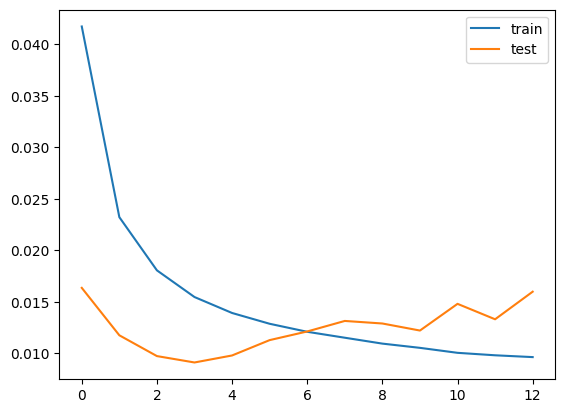

274/274 [==============================] - 2s 3ms/step
MAPE: 8.644984585946466
RMSE: 1344.7683229262234
Correlation 0.9115465931651962 with p-value 0.0
---------------
50393 8784
shape 1 17
Epoch 1/50
394/394 - 6s - loss: 0.0392 - val_loss: 0.0193 - 6s/epoch - 14ms/step
Epoch 2/50
394/394 - 2s - loss: 0.0213 - val_loss: 0.0158 - 2s/epoch - 5ms/step
Epoch 3/50
394/394 - 2s - loss: 0.0159 - val_loss: 0.0147 - 2s/epoch - 5ms/step
Epoch 4/50
394/394 - 3s - loss: 0.0138 - val_loss: 0.0155 - 3s/epoch - 8ms/step
Epoch 5/50
394/394 - 3s - loss: 0.0125 - val_loss: 0.0154 - 3s/epoch - 6ms/step
Epoch 6/50
394/394 - 2s - loss: 0.0115 - val_loss: 0.0151 - 2s/epoch - 5ms/step
Epoch 7/50
394/394 - 2s - loss: 0.0108 - val_loss: 0.0146 - 2s/epoch - 5ms/step
Epoch 8/50
394/394 - 2s - loss: 0.0103 - val_loss: 0.0147 - 2s/epoch - 6ms/step
Epoch 9/50
394/394 - 2s - loss: 0.0098 - val_loss: 0.0143 - 2s/epoch - 5ms/step
Epoch 10/50
394/394 - 3s - loss: 0.0094 - val_loss: 0.0141 - 3s/epoch - 7ms/step
Epoch 11

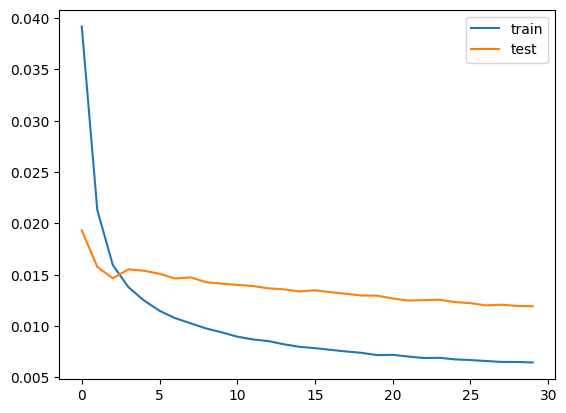

275/275 [==============================] - 1s 2ms/step
MAPE: 6.44068414407818
RMSE: 1161.7827211001684
Correlation 0.8387145343647835 with p-value 0.0
---------------
59177 8760
shape 1 17
Epoch 1/50
463/463 - 6s - loss: 0.0355 - val_loss: 0.0366 - 6s/epoch - 13ms/step
Epoch 2/50
463/463 - 2s - loss: 0.0193 - val_loss: 0.0239 - 2s/epoch - 5ms/step
Epoch 3/50
463/463 - 4s - loss: 0.0151 - val_loss: 0.0185 - 4s/epoch - 8ms/step
Epoch 4/50
463/463 - 2s - loss: 0.0133 - val_loss: 0.0158 - 2s/epoch - 5ms/step
Epoch 5/50
463/463 - 2s - loss: 0.0120 - val_loss: 0.0149 - 2s/epoch - 5ms/step
Epoch 6/50
463/463 - 2s - loss: 0.0113 - val_loss: 0.0127 - 2s/epoch - 5ms/step
Epoch 7/50
463/463 - 2s - loss: 0.0107 - val_loss: 0.0130 - 2s/epoch - 5ms/step
Epoch 8/50
463/463 - 3s - loss: 0.0102 - val_loss: 0.0119 - 3s/epoch - 7ms/step
Epoch 9/50
463/463 - 3s - loss: 0.0098 - val_loss: 0.0113 - 3s/epoch - 7ms/step
Epoch 10/50
463/463 - 2s - loss: 0.0094 - val_loss: 0.0111 - 2s/epoch - 5ms/step
Epoch 11/

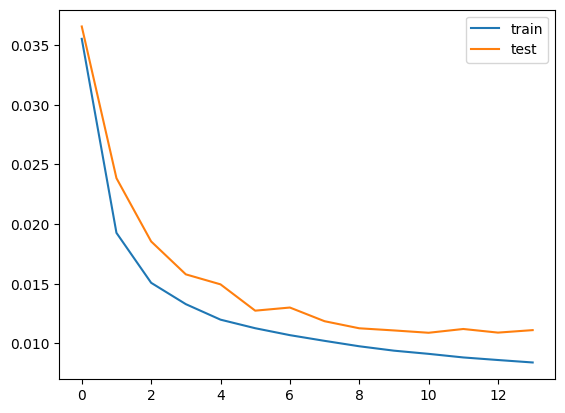

274/274 [==============================] - 1s 2ms/step
MAPE: 6.354233991741206
RMSE: 1121.0183055928776
Correlation 0.851063772541684 with p-value 0.0
---------------
67937 8760
shape 1 17
Epoch 1/50
531/531 - 6s - loss: 0.0325 - val_loss: 0.0198 - 6s/epoch - 12ms/step
Epoch 2/50
531/531 - 3s - loss: 0.0168 - val_loss: 0.0153 - 3s/epoch - 6ms/step
Epoch 3/50
531/531 - 4s - loss: 0.0135 - val_loss: 0.0139 - 4s/epoch - 7ms/step
Epoch 4/50
531/531 - 3s - loss: 0.0119 - val_loss: 0.0132 - 3s/epoch - 5ms/step
Epoch 5/50
531/531 - 3s - loss: 0.0112 - val_loss: 0.0125 - 3s/epoch - 5ms/step
Epoch 6/50
531/531 - 3s - loss: 0.0104 - val_loss: 0.0120 - 3s/epoch - 5ms/step
Epoch 7/50
531/531 - 4s - loss: 0.0100 - val_loss: 0.0117 - 4s/epoch - 7ms/step
Epoch 8/50
531/531 - 3s - loss: 0.0094 - val_loss: 0.0115 - 3s/epoch - 6ms/step
Epoch 9/50
531/531 - 3s - loss: 0.0090 - val_loss: 0.0113 - 3s/epoch - 5ms/step
Epoch 10/50
531/531 - 3s - loss: 0.0088 - val_loss: 0.0112 - 3s/epoch - 5ms/step
Epoch 11/

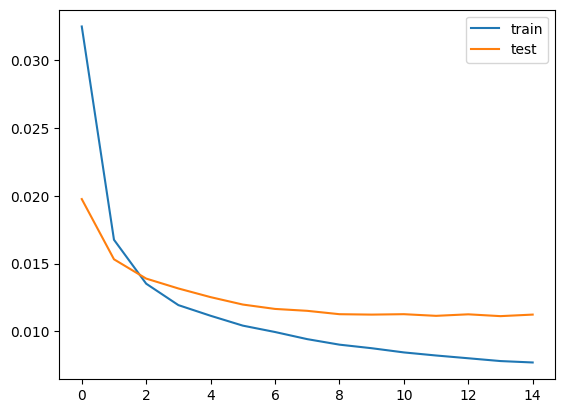

274/274 [==============================] - 1s 2ms/step
MAPE: 6.395416767715976
RMSE: 1163.1135495548592
Correlation 0.8415472751622555 with p-value 0.0
---------------
76697 3622
shape 1 17
Epoch 1/50
600/600 - 8s - loss: 0.0308 - val_loss: 0.0211 - 8s/epoch - 13ms/step
Epoch 2/50
600/600 - 3s - loss: 0.0164 - val_loss: 0.0186 - 3s/epoch - 5ms/step
Epoch 3/50
600/600 - 3s - loss: 0.0132 - val_loss: 0.0150 - 3s/epoch - 5ms/step
Epoch 4/50
600/600 - 4s - loss: 0.0118 - val_loss: 0.0143 - 4s/epoch - 6ms/step
Epoch 5/50
600/600 - 4s - loss: 0.0110 - val_loss: 0.0133 - 4s/epoch - 7ms/step
Epoch 6/50
600/600 - 3s - loss: 0.0105 - val_loss: 0.0121 - 3s/epoch - 5ms/step
Epoch 7/50
600/600 - 3s - loss: 0.0100 - val_loss: 0.0112 - 3s/epoch - 5ms/step
Epoch 8/50
600/600 - 3s - loss: 0.0096 - val_loss: 0.0103 - 3s/epoch - 5ms/step
Epoch 9/50
600/600 - 4s - loss: 0.0092 - val_loss: 0.0098 - 4s/epoch - 7ms/step
Epoch 10/50
600/600 - 3s - loss: 0.0088 - val_loss: 0.0096 - 3s/epoch - 5ms/step
Epoch 11

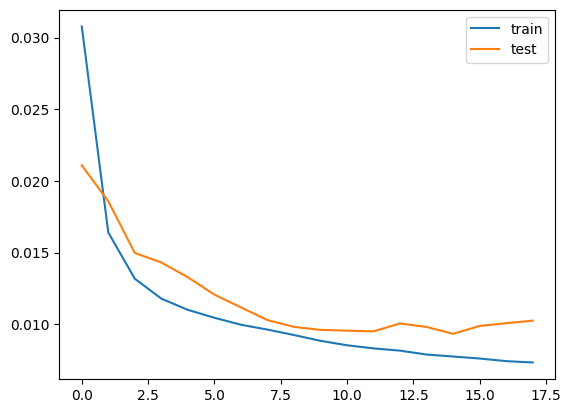

114/114 [==============================] - 1s 3ms/step
MAPE: 6.159102884074484
RMSE: 1126.8238030770808
Correlation 0.8944284170317129 with p-value 0.0
---------------
AVG
----------------------------------
1177.52 & 7.07 & 0.88 & 1342.1 & 7.52 & 0.9 
----------------------------------
GENERAL FOLDS
----------------------------------
1371.63 & 9.91 & 0.87
1261.96 & 7.48 & 0.89
869.07 & 5.18 & 0.94
1344.77 & 8.64 & 0.91
1161.78 & 6.44 & 0.84
1121.02 & 6.35 & 0.85
1163.11 & 6.4 & 0.84
1126.82 & 6.16 & 0.89
----------------------------------
WINTERTIME FOLDS
----------------------------------
1194.65 & 7.37 & 0.92
1823.61 & 10.83 & 0.85
1029.57 & 5.7 & 0.93
1630.06 & 9.62 & 0.87
1339.48 & 7.05 & 0.89
1115.68 & 5.76 & 0.91
1417.69 & 7.6 & 0.9
1186.12 & 6.24 & 0.9


In [ ]:
rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list = run_cv(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=True,
    use_no_predictors=False,
    include_price_bool=True,
    include_climate_change_bool=False,
    huang=False,
    tan=True,
    train_test_indices=train_test_indices,
    folder_name='all_predictors_price'
)

### Tan None

15333 8783
shape 1 11
Epoch 1/50
120/120 - 4s - loss: 0.0512 - val_loss: 0.0500 - 4s/epoch - 36ms/step
Epoch 2/50
120/120 - 1s - loss: 0.0404 - val_loss: 0.0401 - 862ms/epoch - 7ms/step
Epoch 3/50
120/120 - 1s - loss: 0.0331 - val_loss: 0.0292 - 894ms/epoch - 7ms/step
Epoch 4/50
120/120 - 1s - loss: 0.0275 - val_loss: 0.0241 - 730ms/epoch - 6ms/step
Epoch 5/50
120/120 - 1s - loss: 0.0249 - val_loss: 0.0188 - 1s/epoch - 9ms/step
Epoch 6/50
120/120 - 1s - loss: 0.0219 - val_loss: 0.0182 - 1s/epoch - 10ms/step
Epoch 7/50
120/120 - 1s - loss: 0.0205 - val_loss: 0.0186 - 1s/epoch - 10ms/step
Epoch 8/50
120/120 - 1s - loss: 0.0192 - val_loss: 0.0186 - 1s/epoch - 10ms/step
Epoch 9/50
120/120 - 1s - loss: 0.0178 - val_loss: 0.0176 - 914ms/epoch - 8ms/step
Epoch 10/50
120/120 - 1s - loss: 0.0173 - val_loss: 0.0174 - 712ms/epoch - 6ms/step
Epoch 11/50
120/120 - 1s - loss: 0.0164 - val_loss: 0.0178 - 856ms/epoch - 7ms/step
Epoch 12/50
120/120 - 1s - loss: 0.0158 - val_loss: 0.0199 - 871ms/epoch -

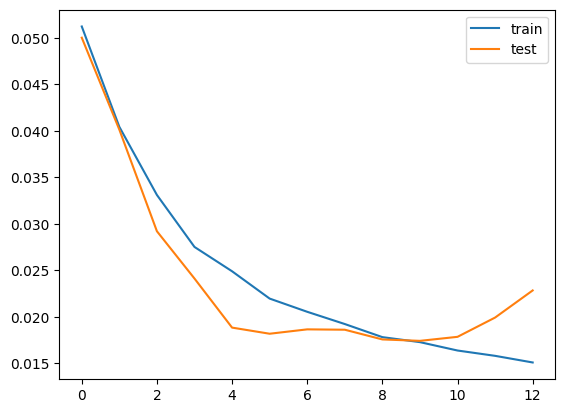

275/275 [==============================] - 2s 3ms/step
MAPE: 11.53356387865674
RMSE: 1552.7642092853237
Correlation 0.8912097760085026 with p-value 0.0
---------------
24116 8759
shape 1 11
Epoch 1/50
189/189 - 5s - loss: 0.0496 - val_loss: 0.0389 - 5s/epoch - 24ms/step
Epoch 2/50
189/189 - 1s - loss: 0.0329 - val_loss: 0.0255 - 1s/epoch - 6ms/step
Epoch 3/50
189/189 - 1s - loss: 0.0249 - val_loss: 0.0195 - 1s/epoch - 5ms/step
Epoch 4/50
189/189 - 1s - loss: 0.0209 - val_loss: 0.0178 - 1s/epoch - 7ms/step
Epoch 5/50
189/189 - 2s - loss: 0.0184 - val_loss: 0.0162 - 2s/epoch - 8ms/step
Epoch 6/50
189/189 - 2s - loss: 0.0166 - val_loss: 0.0168 - 2s/epoch - 9ms/step
Epoch 7/50
189/189 - 1s - loss: 0.0154 - val_loss: 0.0155 - 1s/epoch - 7ms/step
Epoch 8/50
189/189 - 1s - loss: 0.0145 - val_loss: 0.0151 - 1s/epoch - 6ms/step
Epoch 9/50
189/189 - 1s - loss: 0.0138 - val_loss: 0.0147 - 1s/epoch - 6ms/step
Epoch 10/50
189/189 - 1s - loss: 0.0132 - val_loss: 0.0144 - 1s/epoch - 6ms/step
Epoch 11

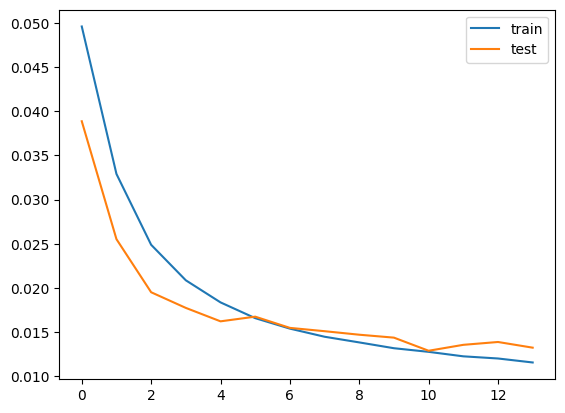

274/274 [==============================] - 1s 3ms/step
MAPE: 7.971336955338875
RMSE: 1216.2406321376448
Correlation 0.8837405415103106 with p-value 0.0
---------------
32875 8759
shape 1 11
Epoch 1/50
257/257 - 5s - loss: 0.0439 - val_loss: 0.0480 - 5s/epoch - 19ms/step
Epoch 2/50
257/257 - 1s - loss: 0.0262 - val_loss: 0.0428 - 1s/epoch - 5ms/step
Epoch 3/50
257/257 - 1s - loss: 0.0202 - val_loss: 0.0399 - 1s/epoch - 5ms/step
Epoch 4/50
257/257 - 1s - loss: 0.0172 - val_loss: 0.0376 - 1s/epoch - 6ms/step
Epoch 5/50
257/257 - 2s - loss: 0.0157 - val_loss: 0.0406 - 2s/epoch - 8ms/step
Epoch 6/50
257/257 - 2s - loss: 0.0146 - val_loss: 0.0397 - 2s/epoch - 8ms/step
Epoch 7/50
257/257 - 2s - loss: 0.0138 - val_loss: 0.0429 - 2s/epoch - 7ms/step
Epoch 8/50
257/257 - 1s - loss: 0.0135 - val_loss: 0.0464 - 1s/epoch - 5ms/step
Epoch 9/50
257/257 - 1s - loss: 0.0130 - val_loss: 0.0434 - 1s/epoch - 6ms/step
Epoch 10/50
257/257 - 1s - loss: 0.0123 - val_loss: 0.0489 - 1s/epoch - 6ms/step
Epoch 11

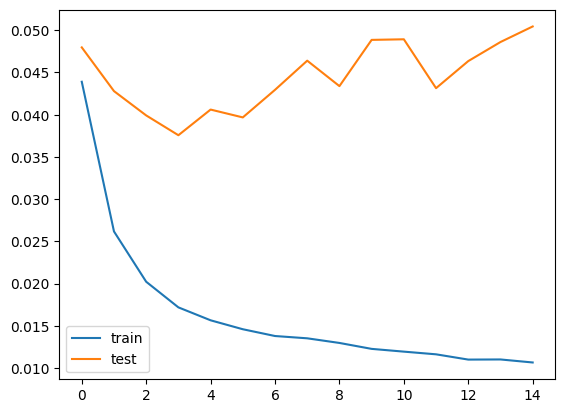

274/274 [==============================] - 1s 2ms/step
MAPE: 17.45661410519796
RMSE: 2387.840742295006
Correlation 0.8333405099276626 with p-value 0.0
---------------
41634 8759
shape 1 11
Epoch 1/50
326/326 - 5s - loss: 0.0427 - val_loss: 0.0173 - 5s/epoch - 16ms/step
Epoch 2/50
326/326 - 2s - loss: 0.0242 - val_loss: 0.0100 - 2s/epoch - 7ms/step
Epoch 3/50
326/326 - 3s - loss: 0.0189 - val_loss: 0.0088 - 3s/epoch - 9ms/step
Epoch 4/50
326/326 - 2s - loss: 0.0162 - val_loss: 0.0079 - 2s/epoch - 6ms/step
Epoch 5/50
326/326 - 2s - loss: 0.0148 - val_loss: 0.0075 - 2s/epoch - 6ms/step
Epoch 6/50
326/326 - 2s - loss: 0.0138 - val_loss: 0.0073 - 2s/epoch - 6ms/step
Epoch 7/50
326/326 - 2s - loss: 0.0131 - val_loss: 0.0075 - 2s/epoch - 6ms/step
Epoch 8/50
326/326 - 2s - loss: 0.0125 - val_loss: 0.0091 - 2s/epoch - 6ms/step
Epoch 9/50
326/326 - 2s - loss: 0.0120 - val_loss: 0.0079 - 2s/epoch - 6ms/step
Epoch 10/50
326/326 - 3s - loss: 0.0116 - val_loss: 0.0079 - 3s/epoch - 8ms/step
Epoch 11/

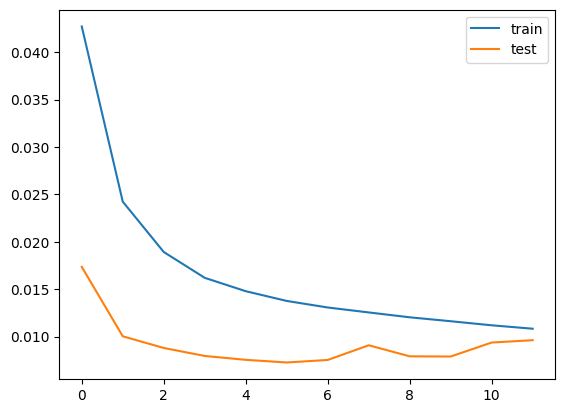

274/274 [==============================] - 1s 2ms/step
MAPE: 6.737025997276909
RMSE: 1042.2168284522897
Correlation 0.9087099739084955 with p-value 0.0
---------------
50393 8784
shape 1 11
Epoch 1/50
394/394 - 7s - loss: 0.0374 - val_loss: 0.0206 - 7s/epoch - 18ms/step
Epoch 2/50
394/394 - 2s - loss: 0.0212 - val_loss: 0.0219 - 2s/epoch - 5ms/step
Epoch 3/50
394/394 - 2s - loss: 0.0168 - val_loss: 0.0247 - 2s/epoch - 5ms/step
Epoch 4/50
394/394 - 2s - loss: 0.0147 - val_loss: 0.0322 - 2s/epoch - 5ms/step
Epoch 5/50
394/394 - 2s - loss: 0.0137 - val_loss: 0.0322 - 2s/epoch - 5ms/step
Epoch 6/50
394/394 - 2s - loss: 0.0128 - val_loss: 0.0365 - 2s/epoch - 5ms/step
Epoch 7/50
394/394 - 3s - loss: 0.0123 - val_loss: 0.0374 - 3s/epoch - 8ms/step
Epoch 8/50
394/394 - 3s - loss: 0.0118 - val_loss: 0.0390 - 3s/epoch - 7ms/step
Epoch 9/50
394/394 - 2s - loss: 0.0116 - val_loss: 0.0393 - 2s/epoch - 5ms/step
Epoch 10/50
394/394 - 2s - loss: 0.0112 - val_loss: 0.0404 - 2s/epoch - 5ms/step
Epoch 11

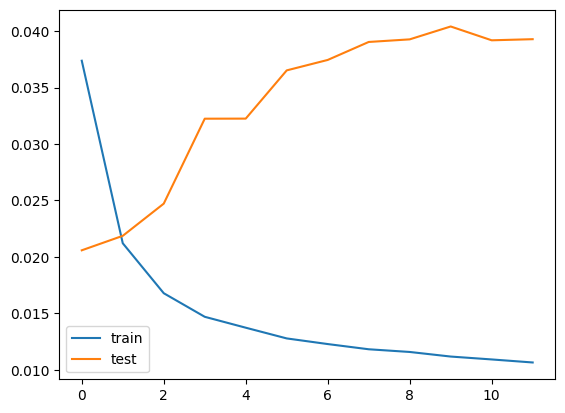

275/275 [==============================] - 1s 3ms/step
MAPE: 14.032636599892184
RMSE: 2107.695033811259
Correlation 0.6962654081036089 with p-value 0.0
---------------
59177 8760
shape 1 11
Epoch 1/50
463/463 - 6s - loss: 0.0356 - val_loss: 0.0511 - 6s/epoch - 13ms/step
Epoch 2/50
463/463 - 2s - loss: 0.0194 - val_loss: 0.0411 - 2s/epoch - 5ms/step
Epoch 3/50
463/463 - 3s - loss: 0.0155 - val_loss: 0.0364 - 3s/epoch - 6ms/step
Epoch 4/50
463/463 - 4s - loss: 0.0139 - val_loss: 0.0366 - 4s/epoch - 8ms/step
Epoch 5/50
463/463 - 2s - loss: 0.0130 - val_loss: 0.0375 - 2s/epoch - 5ms/step
Epoch 6/50
463/463 - 2s - loss: 0.0123 - val_loss: 0.0333 - 2s/epoch - 5ms/step
Epoch 7/50
463/463 - 2s - loss: 0.0118 - val_loss: 0.0347 - 2s/epoch - 5ms/step
Epoch 8/50
463/463 - 2s - loss: 0.0114 - val_loss: 0.0317 - 2s/epoch - 5ms/step
Epoch 9/50
463/463 - 3s - loss: 0.0110 - val_loss: 0.0307 - 3s/epoch - 7ms/step
Epoch 10/50
463/463 - 3s - loss: 0.0105 - val_loss: 0.0294 - 3s/epoch - 7ms/step
Epoch 11

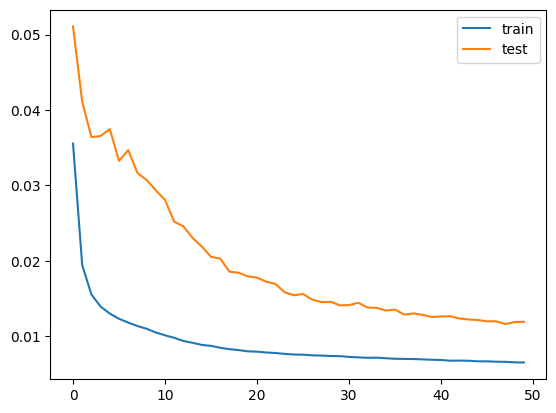

274/274 [==============================] - 1s 2ms/step
MAPE: 7.382395637417144
RMSE: 1161.5033307748342
Correlation 0.8464143503457755 with p-value 0.0
---------------
67937 8760
shape 1 11
Epoch 1/50
531/531 - 7s - loss: 0.0320 - val_loss: 0.0191 - 7s/epoch - 13ms/step
Epoch 2/50
531/531 - 4s - loss: 0.0174 - val_loss: 0.0159 - 4s/epoch - 7ms/step
Epoch 3/50
531/531 - 3s - loss: 0.0144 - val_loss: 0.0141 - 3s/epoch - 5ms/step
Epoch 4/50
531/531 - 3s - loss: 0.0131 - val_loss: 0.0130 - 3s/epoch - 5ms/step
Epoch 5/50
531/531 - 3s - loss: 0.0124 - val_loss: 0.0121 - 3s/epoch - 5ms/step
Epoch 6/50
531/531 - 3s - loss: 0.0117 - val_loss: 0.0115 - 3s/epoch - 6ms/step
Epoch 7/50
531/531 - 4s - loss: 0.0112 - val_loss: 0.0111 - 4s/epoch - 7ms/step
Epoch 8/50
531/531 - 3s - loss: 0.0108 - val_loss: 0.0109 - 3s/epoch - 5ms/step
Epoch 9/50
531/531 - 3s - loss: 0.0105 - val_loss: 0.0109 - 3s/epoch - 5ms/step
Epoch 10/50
531/531 - 3s - loss: 0.0101 - val_loss: 0.0111 - 3s/epoch - 6ms/step
Epoch 11

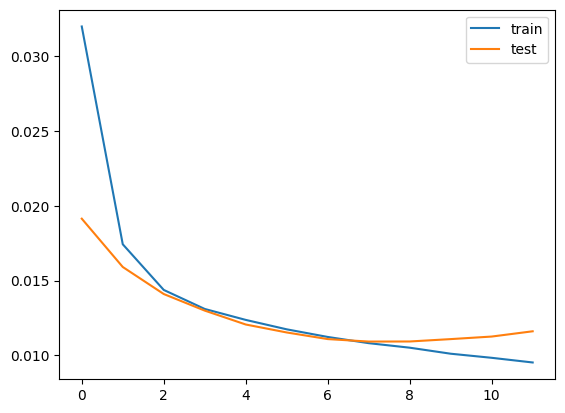

274/274 [==============================] - 1s 2ms/step
MAPE: 6.810821486391629
RMSE: 1181.883155071517
Correlation 0.8210684404383023 with p-value 0.0
---------------
76697 3622
shape 1 11
Epoch 1/50
600/600 - 7s - loss: 0.0309 - val_loss: 0.0189 - 7s/epoch - 12ms/step
Epoch 2/50
600/600 - 4s - loss: 0.0167 - val_loss: 0.0192 - 4s/epoch - 6ms/step
Epoch 3/50
600/600 - 3s - loss: 0.0140 - val_loss: 0.0138 - 3s/epoch - 5ms/step
Epoch 4/50
600/600 - 3s - loss: 0.0128 - val_loss: 0.0143 - 3s/epoch - 5ms/step
Epoch 5/50
600/600 - 3s - loss: 0.0120 - val_loss: 0.0143 - 3s/epoch - 5ms/step
Epoch 6/50
600/600 - 4s - loss: 0.0114 - val_loss: 0.0116 - 4s/epoch - 7ms/step
Epoch 7/50
600/600 - 3s - loss: 0.0109 - val_loss: 0.0116 - 3s/epoch - 5ms/step
Epoch 8/50
600/600 - 3s - loss: 0.0106 - val_loss: 0.0108 - 3s/epoch - 5ms/step
Epoch 9/50
600/600 - 3s - loss: 0.0103 - val_loss: 0.0100 - 3s/epoch - 5ms/step
Epoch 10/50
600/600 - 3s - loss: 0.0099 - val_loss: 0.0096 - 3s/epoch - 5ms/step
Epoch 11/

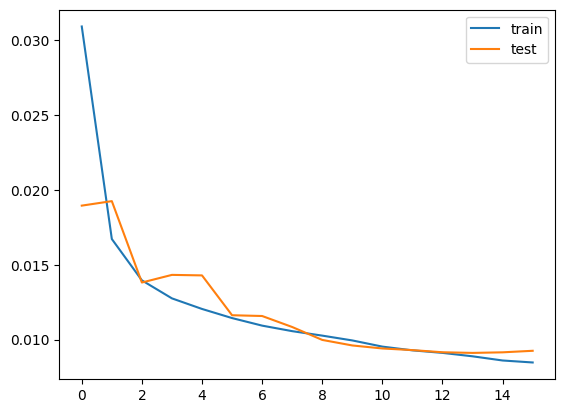

114/114 [==============================] - 1s 2ms/step
MAPE: 6.0198214491375355
RMSE: 1070.364511080724
Correlation 0.8677524487338335 with p-value 0.0
---------------
AVG
----------------------------------
1465.06 & 9.74 & 0.84 & 1080.18 & 6.35 & 0.9 
----------------------------------
GENERAL FOLDS
----------------------------------
1552.76 & 11.53 & 0.89
1216.24 & 7.97 & 0.88
2387.84 & 17.46 & 0.83
1042.22 & 6.74 & 0.91
2107.7 & 14.03 & 0.7
1161.5 & 7.38 & 0.85
1181.88 & 6.81 & 0.82
1070.36 & 6.02 & 0.87
----------------------------------
WINTERTIME FOLDS
----------------------------------
1168.21 & 7.84 & 0.92
1303.63 & 7.8 & 0.9
1069.32 & 6.58 & 0.92
988.57 & 5.77 & 0.91
1050.28 & 6.11 & 0.89
903.4 & 4.92 & 0.92
1144.09 & 6.27 & 0.88
1013.98 & 5.49 & 0.88


In [ ]:
rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list = run_cv(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=False,
    use_no_predictors=True,
    include_price_bool=True,
    include_climate_change_bool=False,
    huang=False,
    tan=True,
    train_test_indices=train_test_indices,
    folder_name='no_predictors_price'
)

### Huang ALL

15333 8783
shape 1 17
Epoch 1/50
120/120 - 5s - loss: 0.0595 - val_loss: 0.0226 - 5s/epoch - 41ms/step
Epoch 2/50
120/120 - 1s - loss: 0.0125 - val_loss: 0.0133 - 719ms/epoch - 6ms/step
Epoch 3/50
120/120 - 1s - loss: 0.0083 - val_loss: 0.0092 - 904ms/epoch - 8ms/step
Epoch 4/50
120/120 - 1s - loss: 0.0070 - val_loss: 0.0090 - 884ms/epoch - 7ms/step
Epoch 5/50
120/120 - 1s - loss: 0.0065 - val_loss: 0.0114 - 745ms/epoch - 6ms/step
Epoch 6/50
120/120 - 1s - loss: 0.0061 - val_loss: 0.0136 - 888ms/epoch - 7ms/step
Epoch 7/50
120/120 - 1s - loss: 0.0057 - val_loss: 0.0150 - 731ms/epoch - 6ms/step
Epoch 8/50
120/120 - 1s - loss: 0.0054 - val_loss: 0.0153 - 747ms/epoch - 6ms/step
Epoch 9/50
120/120 - 1s - loss: 0.0053 - val_loss: 0.0139 - 748ms/epoch - 6ms/step
Epoch 10/50
120/120 - 1s - loss: 0.0055 - val_loss: 0.0113 - 738ms/epoch - 6ms/step
Epoch 11/50
120/120 - 1s - loss: 0.0058 - val_loss: 0.0086 - 912ms/epoch - 8ms/step
Epoch 12/50
120/120 - 1s - loss: 0.0064 - val_loss: 0.0065 - 1s/e

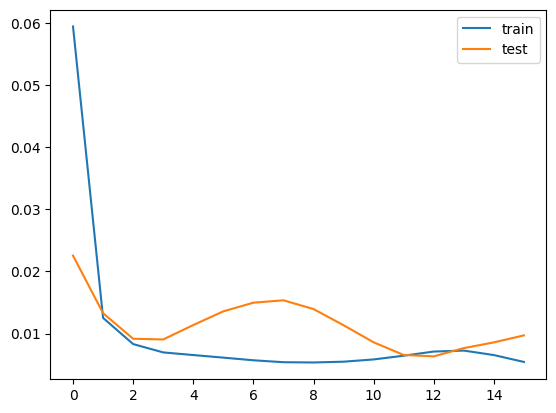

275/275 [==============================] - 1s 2ms/step
MAPE: 6.607158979291031
RMSE: 1012.2433953399577
Correlation 0.9116566495998679 with p-value 0.0
---------------
24116 8759
shape 1 17
Epoch 1/50
189/189 - 5s - loss: 0.0426 - val_loss: 0.0120 - 5s/epoch - 28ms/step
Epoch 2/50
189/189 - 3s - loss: 0.0093 - val_loss: 0.0104 - 3s/epoch - 13ms/step
Epoch 3/50
189/189 - 1s - loss: 0.0069 - val_loss: 0.0107 - 1s/epoch - 7ms/step
Epoch 4/50
189/189 - 1s - loss: 0.0057 - val_loss: 0.0133 - 1s/epoch - 6ms/step
Epoch 5/50
189/189 - 1s - loss: 0.0052 - val_loss: 0.0188 - 1s/epoch - 7ms/step
Epoch 6/50
189/189 - 1s - loss: 0.0052 - val_loss: 0.0294 - 1s/epoch - 6ms/step
Epoch 7/50
189/189 - 1s - loss: 0.0057 - val_loss: 0.0484 - 1s/epoch - 6ms/step
Epoch 8/50
189/189 - 1s - loss: 0.0068 - val_loss: 0.0723 - 1s/epoch - 6ms/step
Epoch 9/50
189/189 - 1s - loss: 0.0091 - val_loss: 0.1103 - 1s/epoch - 6ms/step
Epoch 10/50
189/189 - 1s - loss: 0.0127 - val_loss: 0.1272 - 1s/epoch - 6ms/step
Epoch 1

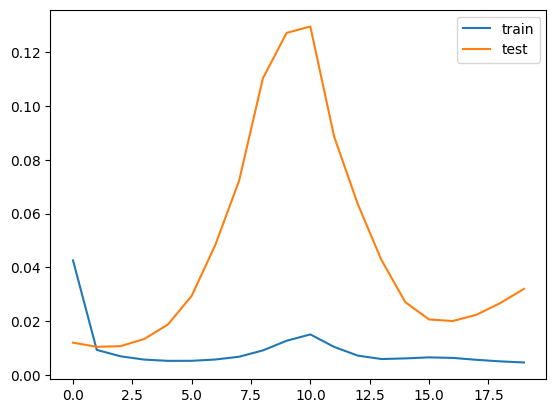

274/274 [==============================] - 1s 2ms/step
MAPE: 12.059012073303037
RMSE: 1889.5100378163168
Correlation 0.9349330744889879 with p-value 0.0
---------------
32875 8759
shape 1 17
Epoch 1/50
257/257 - 6s - loss: 0.0277 - val_loss: 0.0075 - 6s/epoch - 23ms/step
Epoch 2/50
257/257 - 1s - loss: 0.0085 - val_loss: 0.0066 - 1s/epoch - 6ms/step
Epoch 3/50
257/257 - 2s - loss: 0.0069 - val_loss: 0.0159 - 2s/epoch - 6ms/step
Epoch 4/50
257/257 - 1s - loss: 0.0085 - val_loss: 0.0389 - 1s/epoch - 6ms/step
Epoch 5/50
257/257 - 2s - loss: 0.0139 - val_loss: 0.0666 - 2s/epoch - 6ms/step
Epoch 6/50
257/257 - 2s - loss: 0.0160 - val_loss: 0.0584 - 2s/epoch - 6ms/step
Epoch 7/50
257/257 - 2s - loss: 0.0108 - val_loss: 0.0396 - 2s/epoch - 7ms/step
Epoch 8/50
257/257 - 2s - loss: 0.0072 - val_loss: 0.0232 - 2s/epoch - 9ms/step
Epoch 9/50
257/257 - 2s - loss: 0.0072 - val_loss: 0.0165 - 2s/epoch - 8ms/step
Epoch 10/50
257/257 - 2s - loss: 0.0081 - val_loss: 0.0123 - 2s/epoch - 6ms/step
Epoch 1

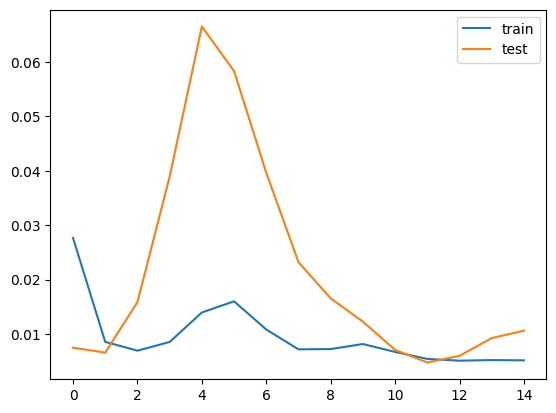

274/274 [==============================] - 1s 3ms/step
MAPE: 6.540620505796908
RMSE: 1094.9358403915887
Correlation 0.9493890859673885 with p-value 0.0
---------------
41634 8759
shape 1 17
Epoch 1/50
326/326 - 5s - loss: 0.0298 - val_loss: 0.0098 - 5s/epoch - 16ms/step
Epoch 2/50
326/326 - 2s - loss: 0.0060 - val_loss: 0.0100 - 2s/epoch - 6ms/step
Epoch 3/50
326/326 - 2s - loss: 0.0058 - val_loss: 0.0202 - 2s/epoch - 6ms/step
Epoch 4/50
326/326 - 2s - loss: 0.0069 - val_loss: 0.0454 - 2s/epoch - 6ms/step
Epoch 5/50
326/326 - 3s - loss: 0.0099 - val_loss: 0.0725 - 3s/epoch - 8ms/step
Epoch 6/50
326/326 - 3s - loss: 0.0128 - val_loss: 0.0722 - 3s/epoch - 9ms/step
Epoch 7/50
326/326 - 2s - loss: 0.0101 - val_loss: 0.0309 - 2s/epoch - 6ms/step
Epoch 8/50
326/326 - 2s - loss: 0.0088 - val_loss: 0.0182 - 2s/epoch - 6ms/step
Epoch 9/50
326/326 - 2s - loss: 0.0092 - val_loss: 0.0101 - 2s/epoch - 6ms/step
Epoch 10/50
326/326 - 2s - loss: 0.0060 - val_loss: 0.0077 - 2s/epoch - 6ms/step
Epoch 11

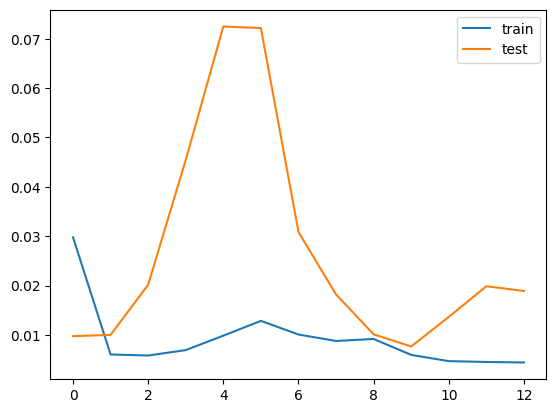

274/274 [==============================] - 1s 2ms/step
MAPE: 10.185743691291773
RMSE: 1461.6116704510835
Correlation 0.9429128714296613 with p-value 0.0
---------------
50393 8784
shape 1 17
Epoch 1/50
394/394 - 5s - loss: 0.0220 - val_loss: 0.0140 - 5s/epoch - 14ms/step
Epoch 2/50
394/394 - 2s - loss: 0.0057 - val_loss: 0.0107 - 2s/epoch - 6ms/step
Epoch 3/50
394/394 - 4s - loss: 0.0050 - val_loss: 0.0132 - 4s/epoch - 9ms/step
Epoch 4/50
394/394 - 3s - loss: 0.0050 - val_loss: 0.0192 - 3s/epoch - 7ms/step
Epoch 5/50
394/394 - 2s - loss: 0.0054 - val_loss: 0.0245 - 2s/epoch - 6ms/step
Epoch 6/50
394/394 - 2s - loss: 0.0057 - val_loss: 0.0220 - 2s/epoch - 6ms/step
Epoch 7/50
394/394 - 2s - loss: 0.0058 - val_loss: 0.0133 - 2s/epoch - 5ms/step
Epoch 8/50
394/394 - 2s - loss: 0.0060 - val_loss: 0.0237 - 2s/epoch - 6ms/step
Epoch 9/50
394/394 - 4s - loss: 0.0071 - val_loss: 0.0331 - 4s/epoch - 9ms/step
Epoch 10/50
394/394 - 2s - loss: 0.0063 - val_loss: 0.0149 - 2s/epoch - 6ms/step
Epoch 1

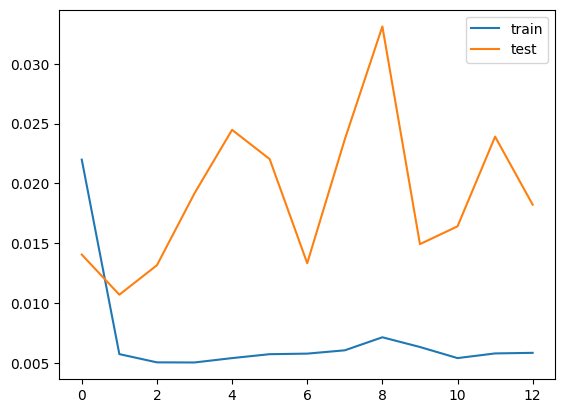

275/275 [==============================] - 1s 2ms/step
MAPE: 8.240210902827013
RMSE: 1435.5763221910936
Correlation 0.8502848525609283 with p-value 0.0
---------------
59177 8760
shape 1 17
Epoch 1/50
463/463 - 6s - loss: 0.0220 - val_loss: 0.0159 - 6s/epoch - 14ms/step
Epoch 2/50
463/463 - 3s - loss: 0.0076 - val_loss: 0.0145 - 3s/epoch - 5ms/step
Epoch 3/50
463/463 - 2s - loss: 0.0065 - val_loss: 0.0336 - 2s/epoch - 5ms/step
Epoch 4/50
463/463 - 3s - loss: 0.0081 - val_loss: 0.0585 - 3s/epoch - 7ms/step
Epoch 5/50
463/463 - 4s - loss: 0.0091 - val_loss: 0.0519 - 4s/epoch - 9ms/step
Epoch 6/50
463/463 - 2s - loss: 0.0095 - val_loss: 0.0158 - 2s/epoch - 5ms/step
Epoch 7/50
463/463 - 3s - loss: 0.0088 - val_loss: 0.0280 - 3s/epoch - 6ms/step
Epoch 8/50
463/463 - 2s - loss: 0.0083 - val_loss: 0.0113 - 2s/epoch - 5ms/step
Epoch 9/50
463/463 - 3s - loss: 0.0058 - val_loss: 0.0148 - 3s/epoch - 6ms/step
Epoch 10/50
463/463 - 4s - loss: 0.0053 - val_loss: 0.0162 - 4s/epoch - 9ms/step
Epoch 11

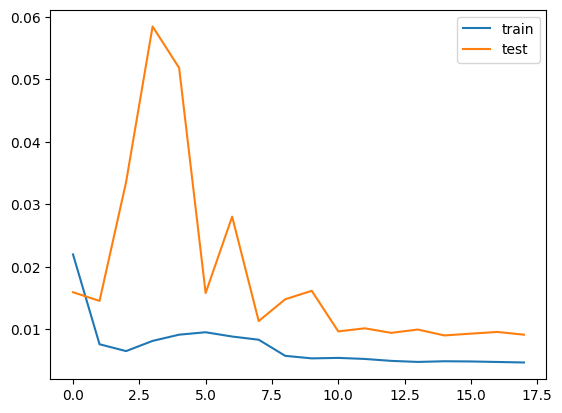

274/274 [==============================] - 1s 2ms/step
MAPE: 6.032911968097985
RMSE: 1016.7994368967255
Correlation 0.8715431999040324 with p-value 0.0
---------------
67937 8760
shape 1 17
Epoch 1/50
531/531 - 6s - loss: 0.0191 - val_loss: 0.0093 - 6s/epoch - 11ms/step
Epoch 2/50
531/531 - 4s - loss: 0.0070 - val_loss: 0.0179 - 4s/epoch - 7ms/step
Epoch 3/50
531/531 - 4s - loss: 0.0068 - val_loss: 0.0428 - 4s/epoch - 8ms/step
Epoch 4/50
531/531 - 3s - loss: 0.0090 - val_loss: 0.0588 - 3s/epoch - 5ms/step
Epoch 5/50
531/531 - 3s - loss: 0.0089 - val_loss: 0.0108 - 3s/epoch - 5ms/step
Epoch 6/50
531/531 - 3s - loss: 0.0073 - val_loss: 0.0277 - 3s/epoch - 5ms/step
Epoch 7/50
531/531 - 4s - loss: 0.0073 - val_loss: 0.0152 - 4s/epoch - 8ms/step
Epoch 8/50
531/531 - 3s - loss: 0.0061 - val_loss: 0.0114 - 3s/epoch - 6ms/step
Epoch 9/50
531/531 - 3s - loss: 0.0051 - val_loss: 0.0117 - 3s/epoch - 5ms/step
Epoch 10/50
531/531 - 3s - loss: 0.0050 - val_loss: 0.0083 - 3s/epoch - 5ms/step
Epoch 11

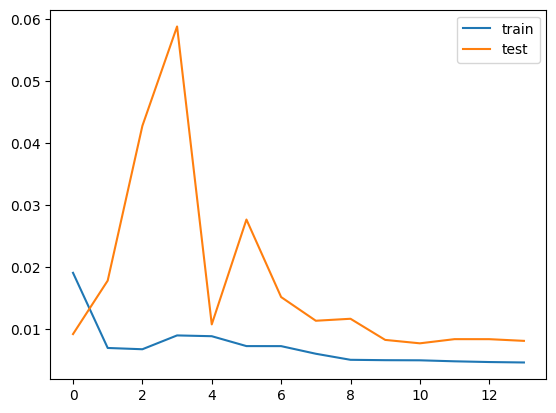

274/274 [==============================] - 1s 2ms/step
MAPE: 6.144470661402534
RMSE: 990.8846551729575
Correlation 0.8708651860486952 with p-value 0.0
---------------
76697 3622
shape 1 17
Epoch 1/50
600/600 - 8s - loss: 0.0170 - val_loss: 0.0110 - 8s/epoch - 13ms/step
Epoch 2/50
600/600 - 3s - loss: 0.0069 - val_loss: 0.0517 - 3s/epoch - 5ms/step
Epoch 3/50
600/600 - 3s - loss: 0.0101 - val_loss: 0.0616 - 3s/epoch - 5ms/step
Epoch 4/50
600/600 - 4s - loss: 0.0102 - val_loss: 0.0144 - 4s/epoch - 6ms/step
Epoch 5/50
600/600 - 5s - loss: 0.0090 - val_loss: 0.0261 - 5s/epoch - 8ms/step
Epoch 6/50
600/600 - 3s - loss: 0.0076 - val_loss: 0.0113 - 3s/epoch - 5ms/step
Epoch 7/50
600/600 - 3s - loss: 0.0053 - val_loss: 0.0128 - 3s/epoch - 5ms/step
Epoch 8/50
600/600 - 3s - loss: 0.0054 - val_loss: 0.0070 - 3s/epoch - 5ms/step
Epoch 9/50
600/600 - 5s - loss: 0.0055 - val_loss: 0.0094 - 5s/epoch - 8ms/step
Epoch 10/50
600/600 - 3s - loss: 0.0050 - val_loss: 0.0092 - 3s/epoch - 5ms/step
Epoch 11/

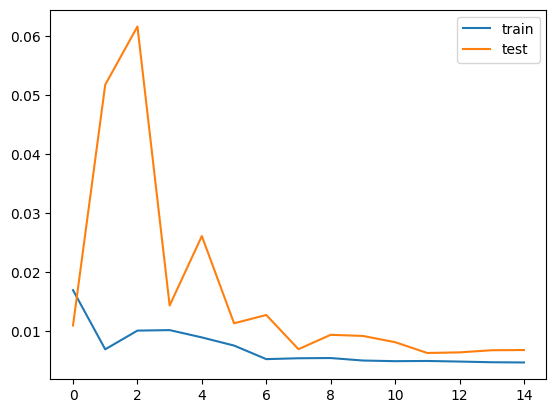

114/114 [==============================] - 1s 2ms/step
MAPE: 5.185751362065242
RMSE: 919.0544402368653
Correlation 0.9109533080851882 with p-value 0.0
---------------
AVG
----------------------------------
1227.58 & 7.62 & 0.91 & 1183.61 & 6.67 & 0.92 
----------------------------------
GENERAL FOLDS
----------------------------------
1012.24 & 6.61 & 0.91
1889.51 & 12.06 & 0.93
1094.94 & 6.54 & 0.95
1461.61 & 10.19 & 0.94
1435.58 & 8.24 & 0.85
1016.8 & 6.03 & 0.87
990.88 & 6.14 & 0.87
919.05 & 5.19 & 0.91
----------------------------------
WINTERTIME FOLDS
----------------------------------
1002.12 & 5.56 & 0.94
1940.53 & 11.51 & 0.91
1067.26 & 5.69 & 0.94
1238.16 & 7.69 & 0.94
1393.13 & 7.65 & 0.89
865.99 & 4.74 & 0.93
1020.4 & 5.48 & 0.9
941.32 & 5.01 & 0.91


In [ ]:
rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list = run_cv(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=True,
    use_no_predictors=False,
    include_price_bool=True,
    include_climate_change_bool=False,
    huang=True,
    tan=False,
    train_test_indices=train_test_indices,
    folder_name='all_predictors_price'
)

### Huang NONE

15333 8783
shape 1 11
Epoch 1/50
120/120 - 5s - loss: 0.0567 - val_loss: 0.0239 - 5s/epoch - 41ms/step
Epoch 2/50
120/120 - 1s - loss: 0.0123 - val_loss: 0.0092 - 776ms/epoch - 6ms/step
Epoch 3/50
120/120 - 1s - loss: 0.0079 - val_loss: 0.0094 - 904ms/epoch - 8ms/step
Epoch 4/50
120/120 - 1s - loss: 0.0067 - val_loss: 0.0100 - 895ms/epoch - 7ms/step
Epoch 5/50
120/120 - 1s - loss: 0.0058 - val_loss: 0.0112 - 898ms/epoch - 7ms/step
Epoch 6/50
120/120 - 1s - loss: 0.0052 - val_loss: 0.0122 - 919ms/epoch - 8ms/step
Epoch 7/50
120/120 - 1s - loss: 0.0050 - val_loss: 0.0131 - 889ms/epoch - 7ms/step
Epoch 8/50
120/120 - 1s - loss: 0.0050 - val_loss: 0.0135 - 897ms/epoch - 7ms/step
Epoch 9/50
120/120 - 1s - loss: 0.0052 - val_loss: 0.0133 - 752ms/epoch - 6ms/step
Epoch 10/50
120/120 - 1s - loss: 0.0053 - val_loss: 0.0125 - 739ms/epoch - 6ms/step
Epoch 11/50
120/120 - 1s - loss: 0.0053 - val_loss: 0.0114 - 910ms/epoch - 8ms/step
Epoch 12/50
120/120 - 1s - loss: 0.0052 - val_loss: 0.0102 - 1s/e

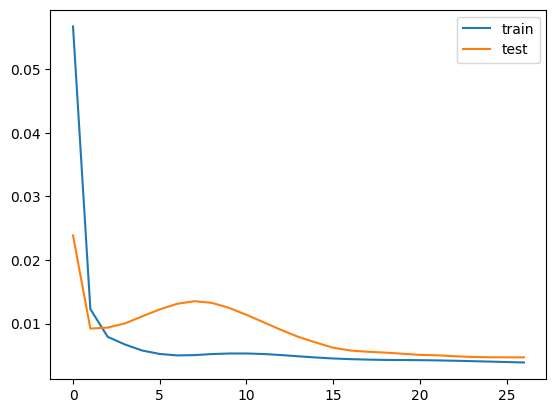

275/275 [==============================] - 1s 2ms/step
MAPE: 4.5590699164505635
RMSE: 704.7027976599343
Correlation 0.9576236506150653 with p-value 0.0
---------------
24116 8759
shape 1 11
Epoch 1/50
189/189 - 4s - loss: 0.0472 - val_loss: 0.0124 - 4s/epoch - 21ms/step
Epoch 2/50
189/189 - 1s - loss: 0.0078 - val_loss: 0.0080 - 1s/epoch - 7ms/step
Epoch 3/50
189/189 - 1s - loss: 0.0055 - val_loss: 0.0088 - 1s/epoch - 6ms/step
Epoch 4/50
189/189 - 1s - loss: 0.0052 - val_loss: 0.0113 - 1s/epoch - 7ms/step
Epoch 5/50
189/189 - 2s - loss: 0.0051 - val_loss: 0.0134 - 2s/epoch - 10ms/step
Epoch 6/50
189/189 - 2s - loss: 0.0049 - val_loss: 0.0148 - 2s/epoch - 10ms/step
Epoch 7/50
189/189 - 1s - loss: 0.0046 - val_loss: 0.0153 - 1s/epoch - 8ms/step
Epoch 8/50
189/189 - 1s - loss: 0.0043 - val_loss: 0.0142 - 1s/epoch - 7ms/step
Epoch 9/50
189/189 - 1s - loss: 0.0041 - val_loss: 0.0153 - 1s/epoch - 6ms/step
Epoch 10/50
189/189 - 1s - loss: 0.0039 - val_loss: 0.0153 - 1s/epoch - 6ms/step
Epoch 

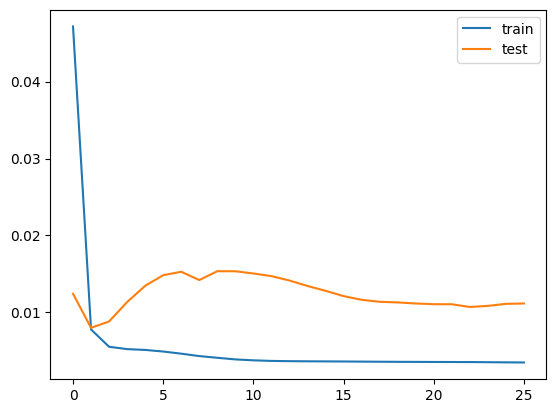

274/274 [==============================] - 1s 3ms/step
MAPE: 7.128075672862024
RMSE: 1114.9157102603317
Correlation 0.9466857188773542 with p-value 0.0
---------------
32875 8759
shape 1 11
Epoch 1/50
257/257 - 5s - loss: 0.0347 - val_loss: 0.0159 - 5s/epoch - 19ms/step
Epoch 2/50
257/257 - 2s - loss: 0.0065 - val_loss: 0.0077 - 2s/epoch - 6ms/step
Epoch 3/50
257/257 - 2s - loss: 0.0054 - val_loss: 0.0055 - 2s/epoch - 6ms/step
Epoch 4/50
257/257 - 2s - loss: 0.0049 - val_loss: 0.0057 - 2s/epoch - 6ms/step
Epoch 5/50
257/257 - 1s - loss: 0.0045 - val_loss: 0.0066 - 1s/epoch - 6ms/step
Epoch 6/50
257/257 - 2s - loss: 0.0043 - val_loss: 0.0072 - 2s/epoch - 9ms/step
Epoch 7/50
257/257 - 3s - loss: 0.0042 - val_loss: 0.0072 - 3s/epoch - 10ms/step
Epoch 8/50
257/257 - 2s - loss: 0.0041 - val_loss: 0.0068 - 2s/epoch - 6ms/step
Epoch 9/50
257/257 - 2s - loss: 0.0040 - val_loss: 0.0063 - 2s/epoch - 6ms/step
Epoch 10/50
257/257 - 2s - loss: 0.0040 - val_loss: 0.0058 - 2s/epoch - 6ms/step
Epoch 1

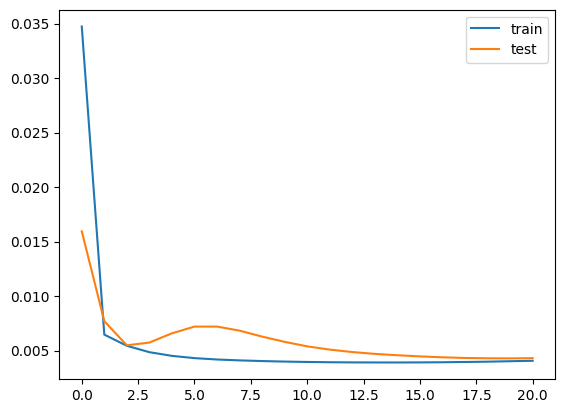

274/274 [==============================] - 1s 3ms/step
MAPE: 3.9685367042829913
RMSE: 697.764338283114
Correlation 0.9552735144343872 with p-value 0.0
---------------
41634 8759
shape 1 11
Epoch 1/50
326/326 - 6s - loss: 0.0294 - val_loss: 0.0192 - 6s/epoch - 17ms/step
Epoch 2/50
326/326 - 2s - loss: 0.0058 - val_loss: 0.0107 - 2s/epoch - 6ms/step
Epoch 3/50
326/326 - 2s - loss: 0.0049 - val_loss: 0.0067 - 2s/epoch - 6ms/step
Epoch 4/50
326/326 - 2s - loss: 0.0047 - val_loss: 0.0055 - 2s/epoch - 6ms/step
Epoch 5/50
326/326 - 2s - loss: 0.0046 - val_loss: 0.0050 - 2s/epoch - 7ms/step
Epoch 6/50
326/326 - 3s - loss: 0.0045 - val_loss: 0.0047 - 3s/epoch - 10ms/step
Epoch 7/50
326/326 - 2s - loss: 0.0045 - val_loss: 0.0045 - 2s/epoch - 6ms/step
Epoch 8/50
326/326 - 2s - loss: 0.0044 - val_loss: 0.0043 - 2s/epoch - 6ms/step
Epoch 9/50
326/326 - 2s - loss: 0.0044 - val_loss: 0.0043 - 2s/epoch - 6ms/step
Epoch 10/50
326/326 - 2s - loss: 0.0043 - val_loss: 0.0043 - 2s/epoch - 6ms/step
Epoch 11

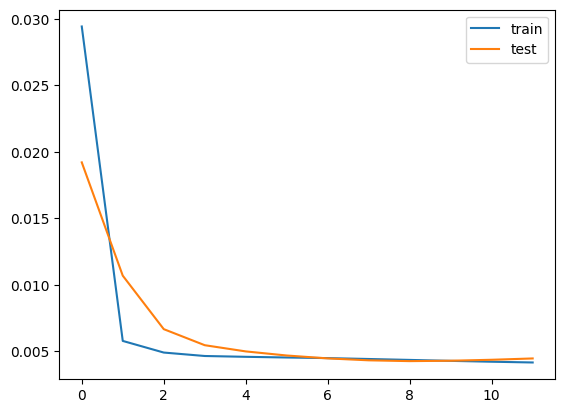

274/274 [==============================] - 1s 4ms/step
MAPE: 4.1062347843843385
RMSE: 710.9036425214144
Correlation 0.9465446158349745 with p-value 0.0
---------------
50393 8784
shape 1 11
Epoch 1/50
394/394 - 5s - loss: 0.0253 - val_loss: 0.0246 - 5s/epoch - 14ms/step
Epoch 2/50
394/394 - 2s - loss: 0.0074 - val_loss: 0.0167 - 2s/epoch - 5ms/step
Epoch 3/50
394/394 - 2s - loss: 0.0062 - val_loss: 0.0129 - 2s/epoch - 6ms/step
Epoch 4/50
394/394 - 4s - loss: 0.0055 - val_loss: 0.0112 - 4s/epoch - 9ms/step
Epoch 5/50
394/394 - 3s - loss: 0.0051 - val_loss: 0.0106 - 3s/epoch - 7ms/step
Epoch 6/50
394/394 - 2s - loss: 0.0048 - val_loss: 0.0104 - 2s/epoch - 5ms/step
Epoch 7/50
394/394 - 2s - loss: 0.0045 - val_loss: 0.0103 - 2s/epoch - 6ms/step
Epoch 8/50
394/394 - 2s - loss: 0.0043 - val_loss: 0.0102 - 2s/epoch - 5ms/step
Epoch 9/50
394/394 - 2s - loss: 0.0042 - val_loss: 0.0101 - 2s/epoch - 6ms/step
Epoch 10/50
394/394 - 4s - loss: 0.0041 - val_loss: 0.0100 - 4s/epoch - 9ms/step
Epoch 11

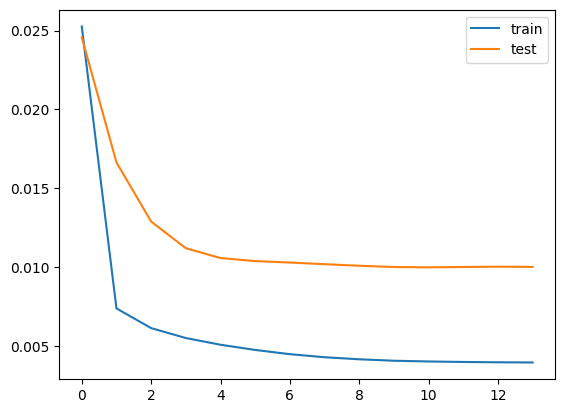

275/275 [==============================] - 1s 2ms/step
MAPE: 6.230375801853862
RMSE: 1065.1911609407907
Correlation 0.8614438566282109 with p-value 0.0
---------------
59177 8760
shape 1 11
Epoch 1/50
463/463 - 7s - loss: 0.0222 - val_loss: 0.0118 - 7s/epoch - 15ms/step
Epoch 2/50
463/463 - 3s - loss: 0.0060 - val_loss: 0.0100 - 3s/epoch - 6ms/step
Epoch 3/50
463/463 - 3s - loss: 0.0052 - val_loss: 0.0096 - 3s/epoch - 6ms/step
Epoch 4/50
463/463 - 3s - loss: 0.0051 - val_loss: 0.0093 - 3s/epoch - 5ms/step
Epoch 5/50
463/463 - 4s - loss: 0.0050 - val_loss: 0.0091 - 4s/epoch - 9ms/step
Epoch 6/50
463/463 - 3s - loss: 0.0049 - val_loss: 0.0088 - 3s/epoch - 6ms/step
Epoch 7/50
463/463 - 3s - loss: 0.0048 - val_loss: 0.0085 - 3s/epoch - 6ms/step
Epoch 8/50
463/463 - 2s - loss: 0.0047 - val_loss: 0.0084 - 2s/epoch - 5ms/step
Epoch 9/50
463/463 - 3s - loss: 0.0047 - val_loss: 0.0084 - 3s/epoch - 6ms/step
Epoch 10/50
463/463 - 4s - loss: 0.0047 - val_loss: 0.0084 - 4s/epoch - 9ms/step
Epoch 11

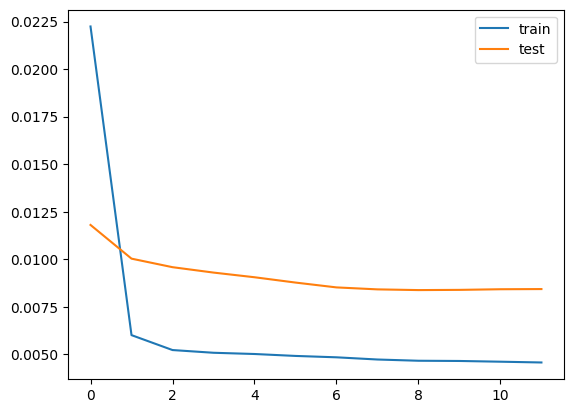

274/274 [==============================] - 1s 3ms/step
MAPE: 6.060810298486808
RMSE: 976.5970530418281
Correlation 0.889616451887924 with p-value 0.0
---------------
67937 8760
shape 1 11
Epoch 1/50
531/531 - 6s - loss: 0.0211 - val_loss: 0.0155 - 6s/epoch - 11ms/step
Epoch 2/50
531/531 - 3s - loss: 0.0053 - val_loss: 0.0097 - 3s/epoch - 5ms/step
Epoch 3/50
531/531 - 3s - loss: 0.0050 - val_loss: 0.0080 - 3s/epoch - 7ms/step
Epoch 4/50
531/531 - 4s - loss: 0.0049 - val_loss: 0.0077 - 4s/epoch - 8ms/step
Epoch 5/50
531/531 - 3s - loss: 0.0048 - val_loss: 0.0076 - 3s/epoch - 5ms/step
Epoch 6/50
531/531 - 3s - loss: 0.0048 - val_loss: 0.0076 - 3s/epoch - 5ms/step
Epoch 7/50
531/531 - 3s - loss: 0.0047 - val_loss: 0.0076 - 3s/epoch - 5ms/step
Epoch 8/50
531/531 - 4s - loss: 0.0047 - val_loss: 0.0076 - 4s/epoch - 8ms/step
Epoch 9/50
531/531 - 3s - loss: 0.0046 - val_loss: 0.0075 - 3s/epoch - 6ms/step
Epoch 10/50
531/531 - 3s - loss: 0.0046 - val_loss: 0.0075 - 3s/epoch - 5ms/step
Epoch 11/5

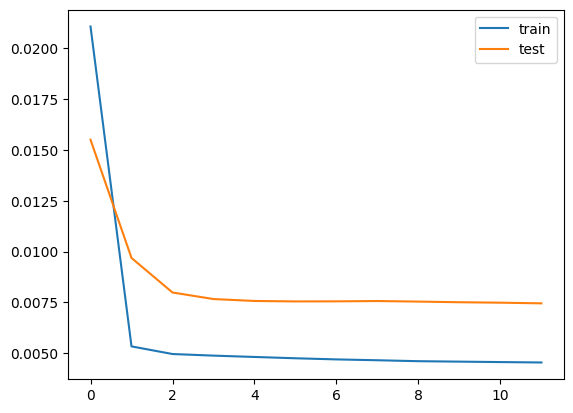

274/274 [==============================] - 1s 3ms/step
MAPE: 5.604955040270089
RMSE: 947.2060869740898
Correlation 0.8773074738633793 with p-value 0.0
---------------
76697 3622
shape 1 11
Epoch 1/50
600/600 - 6s - loss: 0.0193 - val_loss: 0.0319 - 6s/epoch - 10ms/step
Epoch 2/50
600/600 - 3s - loss: 0.0055 - val_loss: 0.0249 - 3s/epoch - 5ms/step
Epoch 3/50
600/600 - 4s - loss: 0.0051 - val_loss: 0.0247 - 4s/epoch - 7ms/step
Epoch 4/50
600/600 - 4s - loss: 0.0050 - val_loss: 0.0268 - 4s/epoch - 6ms/step
Epoch 5/50
600/600 - 3s - loss: 0.0050 - val_loss: 0.0293 - 3s/epoch - 5ms/step
Epoch 6/50
600/600 - 3s - loss: 0.0049 - val_loss: 0.0319 - 3s/epoch - 5ms/step
Epoch 7/50
600/600 - 4s - loss: 0.0049 - val_loss: 0.0332 - 4s/epoch - 6ms/step
Epoch 8/50
600/600 - 4s - loss: 0.0049 - val_loss: 0.0348 - 4s/epoch - 7ms/step
Epoch 9/50
600/600 - 3s - loss: 0.0049 - val_loss: 0.0375 - 3s/epoch - 5ms/step
Epoch 10/50
600/600 - 3s - loss: 0.0048 - val_loss: 0.0374 - 3s/epoch - 5ms/step
Epoch 11/

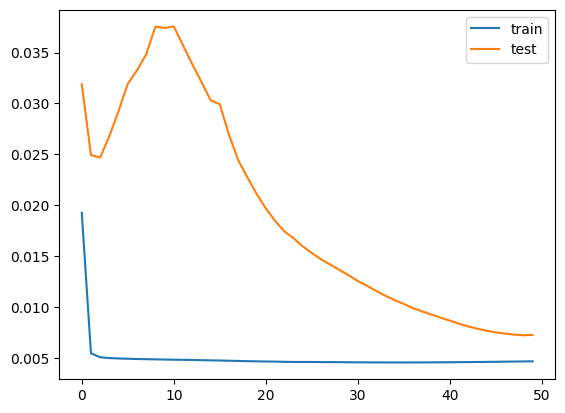

114/114 [==============================] - 1s 2ms/step
MAPE: 5.540080100624844
RMSE: 948.6668422489965
Correlation 0.8974541667604718 with p-value 0.0
---------------
AVG
----------------------------------
895.74 & 5.4 & 0.92 & 932.58 & 5.21 & 0.93 
----------------------------------
GENERAL FOLDS
----------------------------------
704.7 & 4.56 & 0.96
1114.92 & 7.13 & 0.95
697.76 & 3.97 & 0.96
710.9 & 4.11 & 0.95
1065.19 & 6.23 & 0.86
976.6 & 6.06 & 0.89
947.21 & 5.6 & 0.88
948.67 & 5.54 & 0.9
----------------------------------
WINTERTIME FOLDS
----------------------------------
812.67 & 4.53 & 0.95
1248.88 & 7.28 & 0.92
777.21 & 3.81 & 0.95
873.96 & 4.79 & 0.95
987.4 & 5.79 & 0.91
873.03 & 5.31 & 0.94
927.27 & 5.0 & 0.91
960.23 & 5.17 & 0.91


In [ ]:
rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list = run_cv(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=False,
    use_no_predictors=True,
    include_price_bool=True,
    include_climate_change_bool=False,
    huang=True,
    tan=False,
    train_test_indices=train_test_indices,
    folder_name='no_predictors_price'
)

# Climate change

### Tan ALL

15333 8783
shape 1 12
Epoch 1/50
120/120 - 5s - loss: 0.0518 - val_loss: 0.0521 - 5s/epoch - 41ms/step
Epoch 2/50
120/120 - 1s - loss: 0.0386 - val_loss: 0.0382 - 1s/epoch - 10ms/step
Epoch 3/50
120/120 - 1s - loss: 0.0310 - val_loss: 0.0285 - 1s/epoch - 10ms/step
Epoch 4/50
120/120 - 1s - loss: 0.0258 - val_loss: 0.0246 - 1s/epoch - 10ms/step
Epoch 5/50
120/120 - 1s - loss: 0.0230 - val_loss: 0.0191 - 737ms/epoch - 6ms/step
Epoch 6/50
120/120 - 1s - loss: 0.0209 - val_loss: 0.0182 - 740ms/epoch - 6ms/step
Epoch 7/50
120/120 - 1s - loss: 0.0194 - val_loss: 0.0184 - 876ms/epoch - 7ms/step
Epoch 8/50
120/120 - 1s - loss: 0.0182 - val_loss: 0.0205 - 742ms/epoch - 6ms/step
Epoch 9/50
120/120 - 1s - loss: 0.0174 - val_loss: 0.0162 - 736ms/epoch - 6ms/step
Epoch 10/50
120/120 - 1s - loss: 0.0168 - val_loss: 0.0159 - 874ms/epoch - 7ms/step
Epoch 11/50
120/120 - 1s - loss: 0.0161 - val_loss: 0.0171 - 740ms/epoch - 6ms/step
Epoch 12/50
120/120 - 1s - loss: 0.0157 - val_loss: 0.0167 - 717ms/epoc

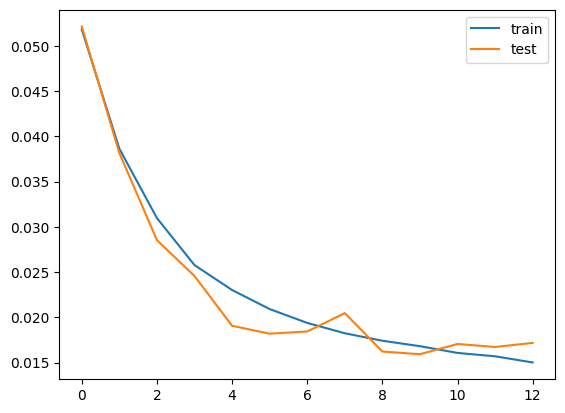

275/275 [==============================] - 1s 2ms/step
MAPE: 9.69408507193892
RMSE: 1347.1267507580117
Correlation 0.8861537336456509 with p-value 0.0
---------------
24116 8759
shape 1 12
Epoch 1/50
189/189 - 13s - loss: 0.0466 - val_loss: 0.0390 - 13s/epoch - 66ms/step
Epoch 2/50
189/189 - 2s - loss: 0.0335 - val_loss: 0.0252 - 2s/epoch - 8ms/step
Epoch 3/50
189/189 - 2s - loss: 0.0255 - val_loss: 0.0189 - 2s/epoch - 8ms/step
Epoch 4/50
189/189 - 1s - loss: 0.0214 - val_loss: 0.0160 - 1s/epoch - 8ms/step
Epoch 5/50
189/189 - 1s - loss: 0.0188 - val_loss: 0.0147 - 1s/epoch - 8ms/step
Epoch 6/50
189/189 - 2s - loss: 0.0170 - val_loss: 0.0136 - 2s/epoch - 11ms/step
Epoch 7/50
189/189 - 3s - loss: 0.0154 - val_loss: 0.0132 - 3s/epoch - 14ms/step
Epoch 8/50
189/189 - 2s - loss: 0.0143 - val_loss: 0.0129 - 2s/epoch - 9ms/step
Epoch 9/50
189/189 - 2s - loss: 0.0137 - val_loss: 0.0122 - 2s/epoch - 8ms/step
Epoch 10/50
189/189 - 2s - loss: 0.0129 - val_loss: 0.0120 - 2s/epoch - 8ms/step
Epoch

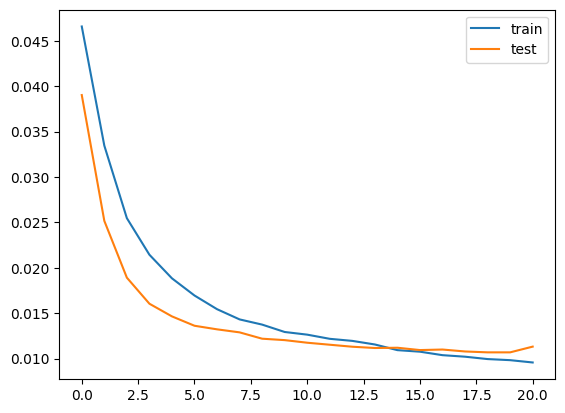

274/274 [==============================] - 1s 3ms/step
MAPE: 6.58165481566741
RMSE: 1124.0793430343908
Correlation 0.9031144522890103 with p-value 0.0
---------------
32875 8759
shape 1 12
Epoch 1/50
257/257 - 7s - loss: 0.0444 - val_loss: 0.0521 - 7s/epoch - 28ms/step
Epoch 2/50
257/257 - 2s - loss: 0.0279 - val_loss: 0.0389 - 2s/epoch - 7ms/step
Epoch 3/50
257/257 - 2s - loss: 0.0212 - val_loss: 0.0401 - 2s/epoch - 8ms/step
Epoch 4/50
257/257 - 2s - loss: 0.0179 - val_loss: 0.0352 - 2s/epoch - 7ms/step
Epoch 5/50
257/257 - 2s - loss: 0.0162 - val_loss: 0.0377 - 2s/epoch - 9ms/step
Epoch 6/50
257/257 - 3s - loss: 0.0150 - val_loss: 0.0374 - 3s/epoch - 11ms/step
Epoch 7/50
257/257 - 2s - loss: 0.0142 - val_loss: 0.0363 - 2s/epoch - 8ms/step
Epoch 8/50
257/257 - 2s - loss: 0.0134 - val_loss: 0.0349 - 2s/epoch - 7ms/step
Epoch 9/50
257/257 - 2s - loss: 0.0131 - val_loss: 0.0338 - 2s/epoch - 7ms/step
Epoch 10/50
257/257 - 2s - loss: 0.0126 - val_loss: 0.0361 - 2s/epoch - 8ms/step
Epoch 11

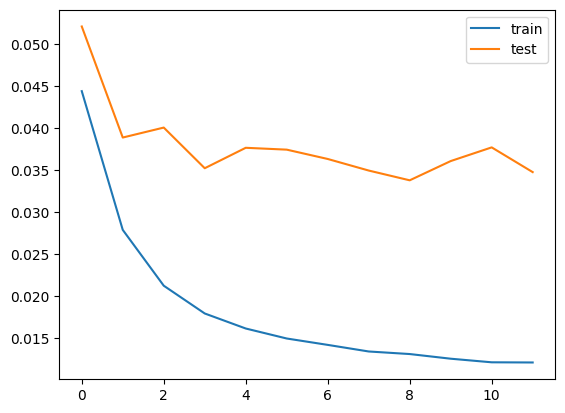

274/274 [==============================] - 2s 4ms/step
MAPE: 14.315092001156707
RMSE: 1982.2358302580567
Correlation 0.8503909471114991 with p-value 0.0
---------------
41634 8759
shape 1 12
Epoch 1/50
326/326 - 6s - loss: 0.0426 - val_loss: 0.0188 - 6s/epoch - 19ms/step
Epoch 2/50
326/326 - 2s - loss: 0.0250 - val_loss: 0.0117 - 2s/epoch - 7ms/step
Epoch 3/50
326/326 - 3s - loss: 0.0190 - val_loss: 0.0145 - 3s/epoch - 10ms/step
Epoch 4/50
326/326 - 3s - loss: 0.0162 - val_loss: 0.0101 - 3s/epoch - 9ms/step
Epoch 5/50
326/326 - 2s - loss: 0.0147 - val_loss: 0.0125 - 2s/epoch - 7ms/step
Epoch 6/50
326/326 - 2s - loss: 0.0137 - val_loss: 0.0146 - 2s/epoch - 7ms/step
Epoch 7/50
326/326 - 2s - loss: 0.0130 - val_loss: 0.0194 - 2s/epoch - 7ms/step
Epoch 8/50
326/326 - 2s - loss: 0.0124 - val_loss: 0.0247 - 2s/epoch - 7ms/step
Epoch 9/50
326/326 - 3s - loss: 0.0118 - val_loss: 0.0292 - 3s/epoch - 10ms/step
Epoch 10/50
326/326 - 3s - loss: 0.0114 - val_loss: 0.0285 - 3s/epoch - 8ms/step
Epoch

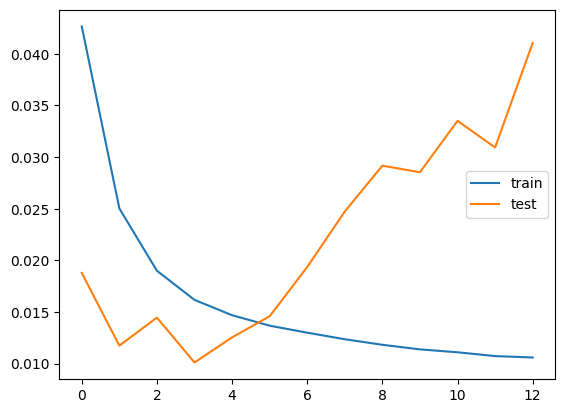

274/274 [==============================] - 1s 3ms/step
MAPE: 15.208781405634683
RMSE: 2154.0896791630944
Correlation 0.8773248705564873 with p-value 0.0
---------------
50393 8784
shape 1 12
Epoch 1/50
394/394 - 8s - loss: 0.0382 - val_loss: 0.0238 - 8s/epoch - 19ms/step
Epoch 2/50
394/394 - 3s - loss: 0.0219 - val_loss: 0.0222 - 3s/epoch - 8ms/step
Epoch 3/50
394/394 - 2s - loss: 0.0169 - val_loss: 0.0253 - 2s/epoch - 6ms/step
Epoch 4/50
394/394 - 2s - loss: 0.0149 - val_loss: 0.0331 - 2s/epoch - 6ms/step
Epoch 5/50
394/394 - 3s - loss: 0.0138 - val_loss: 0.0357 - 3s/epoch - 6ms/step
Epoch 6/50
394/394 - 3s - loss: 0.0129 - val_loss: 0.0367 - 3s/epoch - 9ms/step
Epoch 7/50
394/394 - 3s - loss: 0.0122 - val_loss: 0.0389 - 3s/epoch - 9ms/step
Epoch 8/50
394/394 - 3s - loss: 0.0116 - val_loss: 0.0438 - 3s/epoch - 6ms/step
Epoch 9/50
394/394 - 3s - loss: 0.0114 - val_loss: 0.0445 - 3s/epoch - 7ms/step
Epoch 10/50
394/394 - 3s - loss: 0.0110 - val_loss: 0.0446 - 3s/epoch - 7ms/step
Epoch 1

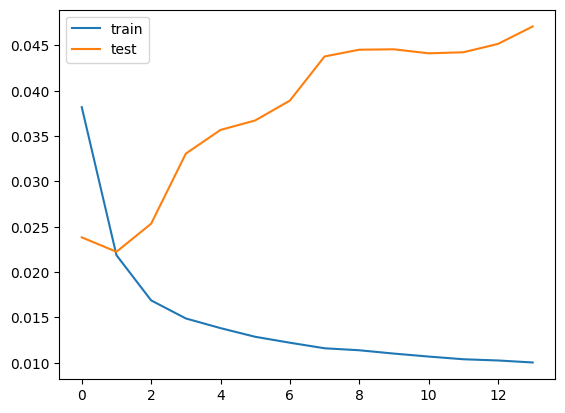

275/275 [==============================] - 1s 3ms/step
MAPE: 15.185341045751644
RMSE: 2307.7670395767336
Correlation 0.663382467114324 with p-value 0.0
---------------
59177 8760
shape 1 12
Epoch 1/50
463/463 - 8s - loss: 0.0353 - val_loss: 0.0440 - 8s/epoch - 18ms/step
Epoch 2/50
463/463 - 3s - loss: 0.0201 - val_loss: 0.0359 - 3s/epoch - 6ms/step
Epoch 3/50
463/463 - 3s - loss: 0.0160 - val_loss: 0.0297 - 3s/epoch - 6ms/step
Epoch 4/50
463/463 - 3s - loss: 0.0143 - val_loss: 0.0294 - 3s/epoch - 7ms/step
Epoch 5/50
463/463 - 4s - loss: 0.0132 - val_loss: 0.0296 - 4s/epoch - 9ms/step
Epoch 6/50
463/463 - 3s - loss: 0.0124 - val_loss: 0.0291 - 3s/epoch - 6ms/step
Epoch 7/50
463/463 - 3s - loss: 0.0119 - val_loss: 0.0284 - 3s/epoch - 6ms/step
Epoch 8/50
463/463 - 3s - loss: 0.0113 - val_loss: 0.0260 - 3s/epoch - 6ms/step
Epoch 9/50
463/463 - 4s - loss: 0.0109 - val_loss: 0.0251 - 4s/epoch - 8ms/step
Epoch 10/50
463/463 - 4s - loss: 0.0105 - val_loss: 0.0230 - 4s/epoch - 8ms/step
Epoch 11

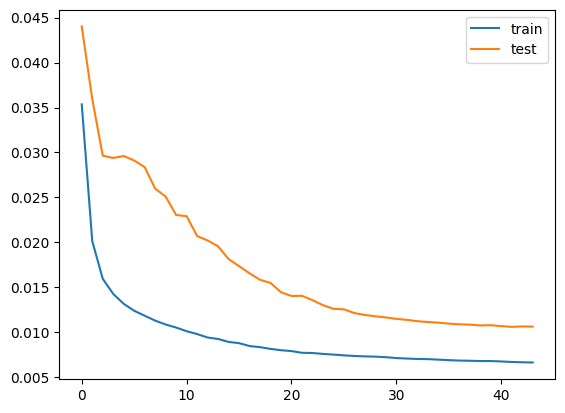

274/274 [==============================] - 1s 2ms/step
MAPE: 6.2541505075478065
RMSE: 1096.875658225566
Correlation 0.8520765710394399 with p-value 0.0
---------------
67937 8760
shape 1 12
Epoch 1/50
531/531 - 8s - loss: 0.0320 - val_loss: 0.0191 - 8s/epoch - 16ms/step
Epoch 2/50
531/531 - 3s - loss: 0.0174 - val_loss: 0.0139 - 3s/epoch - 6ms/step
Epoch 3/50
531/531 - 3s - loss: 0.0140 - val_loss: 0.0119 - 3s/epoch - 6ms/step
Epoch 4/50
531/531 - 4s - loss: 0.0126 - val_loss: 0.0111 - 4s/epoch - 8ms/step
Epoch 5/50
531/531 - 3s - loss: 0.0118 - val_loss: 0.0107 - 3s/epoch - 6ms/step
Epoch 6/50
531/531 - 3s - loss: 0.0112 - val_loss: 0.0105 - 3s/epoch - 6ms/step
Epoch 7/50
531/531 - 3s - loss: 0.0106 - val_loss: 0.0107 - 3s/epoch - 6ms/step
Epoch 8/50
531/531 - 5s - loss: 0.0102 - val_loss: 0.0110 - 5s/epoch - 10ms/step
Epoch 9/50
531/531 - 3s - loss: 0.0099 - val_loss: 0.0111 - 3s/epoch - 6ms/step
Epoch 10/50
531/531 - 3s - loss: 0.0095 - val_loss: 0.0118 - 3s/epoch - 6ms/step
Epoch 1

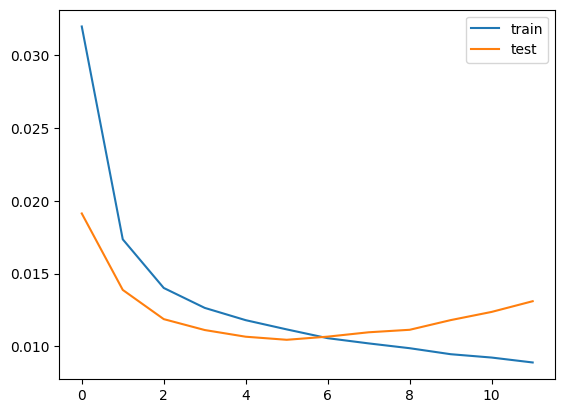

274/274 [==============================] - 3s 5ms/step
MAPE: 7.0823213705379136
RMSE: 1255.8205039219674
Correlation 0.831264202975468 with p-value 0.0
---------------
76697 3622
shape 1 12
Epoch 1/50
600/600 - 7s - loss: 0.0303 - val_loss: 0.0152 - 7s/epoch - 11ms/step
Epoch 2/50
600/600 - 4s - loss: 0.0169 - val_loss: 0.0133 - 4s/epoch - 6ms/step
Epoch 3/50
600/600 - 5s - loss: 0.0141 - val_loss: 0.0114 - 5s/epoch - 8ms/step
Epoch 4/50
600/600 - 3s - loss: 0.0129 - val_loss: 0.0111 - 3s/epoch - 5ms/step
Epoch 5/50
600/600 - 3s - loss: 0.0121 - val_loss: 0.0108 - 3s/epoch - 5ms/step
Epoch 6/50
600/600 - 3s - loss: 0.0115 - val_loss: 0.0102 - 3s/epoch - 6ms/step
Epoch 7/50
600/600 - 4s - loss: 0.0110 - val_loss: 0.0100 - 4s/epoch - 7ms/step
Epoch 8/50
600/600 - 3s - loss: 0.0106 - val_loss: 0.0100 - 3s/epoch - 5ms/step
Epoch 9/50
600/600 - 3s - loss: 0.0103 - val_loss: 0.0103 - 3s/epoch - 5ms/step
Epoch 10/50
600/600 - 3s - loss: 0.0099 - val_loss: 0.0109 - 3s/epoch - 6ms/step
Epoch 11

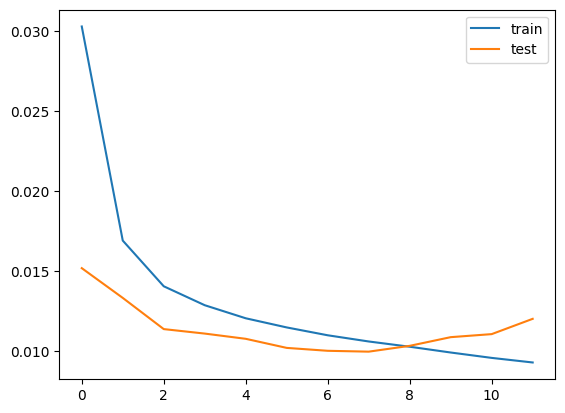

114/114 [==============================] - 1s 2ms/step
MAPE: 6.81334663965349
RMSE: 1220.2989383112977
Correlation 0.8470206360341587 with p-value 0.0
---------------
AVG
----------------------------------
1561.04 & 10.14 & 0.84 & 1199.56 & 6.9 & 0.9 
----------------------------------
GENERAL FOLDS
----------------------------------
1347.13 & 9.69 & 0.89
1124.08 & 6.58 & 0.9
1982.24 & 14.32 & 0.85
2154.09 & 15.21 & 0.88
2307.77 & 15.19 & 0.66
1096.88 & 6.25 & 0.85
1255.82 & 7.08 & 0.83
1220.3 & 6.81 & 0.85
----------------------------------
WINTERTIME FOLDS
----------------------------------
1104.11 & 7.14 & 0.92
1549.38 & 9.07 & 0.9
1056.61 & 6.44 & 0.92
1446.44 & 8.59 & 0.89
1085.17 & 6.1 & 0.89
1062.1 & 5.61 & 0.92
1203.59 & 6.43 & 0.88
1089.13 & 5.83 & 0.87


In [ ]:
rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list = run_cv(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=True,
    use_no_predictors=False,
    include_price_bool=False,
    include_climate_change_bool=True,
    huang=False,
    tan=True,
    train_test_indices=train_test_indices,
    folder_name='all_predictors_climate_change'
)

### Tan NONE

15333 8783
shape 1 15
Epoch 1/50
120/120 - 4s - loss: 0.0536 - val_loss: 0.0522 - 4s/epoch - 35ms/step
Epoch 2/50
120/120 - 1s - loss: 0.0383 - val_loss: 0.0349 - 732ms/epoch - 6ms/step
Epoch 3/50
120/120 - 1s - loss: 0.0309 - val_loss: 0.0220 - 990ms/epoch - 8ms/step
Epoch 4/50
120/120 - 1s - loss: 0.0258 - val_loss: 0.0174 - 1s/epoch - 10ms/step
Epoch 5/50
120/120 - 1s - loss: 0.0234 - val_loss: 0.0148 - 1s/epoch - 10ms/step
Epoch 6/50
120/120 - 1s - loss: 0.0206 - val_loss: 0.0137 - 1s/epoch - 10ms/step
Epoch 7/50
120/120 - 1s - loss: 0.0190 - val_loss: 0.0138 - 1s/epoch - 9ms/step
Epoch 8/50
120/120 - 1s - loss: 0.0180 - val_loss: 0.0138 - 896ms/epoch - 7ms/step
Epoch 9/50
120/120 - 1s - loss: 0.0170 - val_loss: 0.0123 - 880ms/epoch - 7ms/step
Epoch 10/50
120/120 - 1s - loss: 0.0166 - val_loss: 0.0121 - 722ms/epoch - 6ms/step
Epoch 11/50
120/120 - 1s - loss: 0.0163 - val_loss: 0.0122 - 862ms/epoch - 7ms/step
Epoch 12/50
120/120 - 1s - loss: 0.0154 - val_loss: 0.0125 - 736ms/epoch -

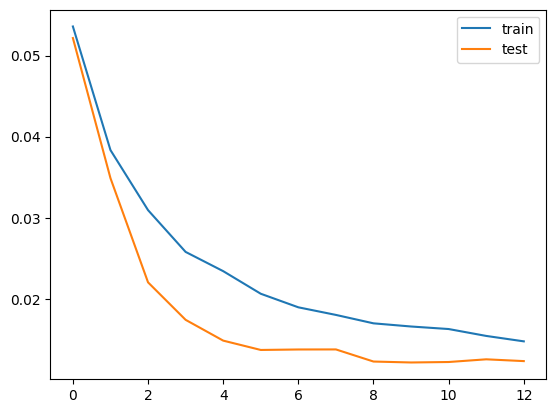

275/275 [==============================] - 1s 2ms/step
MAPE: 7.9766262353389505
RMSE: 1140.7660785435914
Correlation 0.8981805542029395 with p-value 0.0
---------------
24116 8759
shape 1 15
Epoch 1/50
189/189 - 6s - loss: 0.0485 - val_loss: 0.0366 - 6s/epoch - 33ms/step
Epoch 2/50
189/189 - 1s - loss: 0.0325 - val_loss: 0.0213 - 1s/epoch - 6ms/step
Epoch 3/50
189/189 - 1s - loss: 0.0246 - val_loss: 0.0161 - 1s/epoch - 6ms/step
Epoch 4/50
189/189 - 1s - loss: 0.0208 - val_loss: 0.0141 - 1s/epoch - 5ms/step
Epoch 5/50
189/189 - 1s - loss: 0.0184 - val_loss: 0.0136 - 1s/epoch - 5ms/step
Epoch 6/50
189/189 - 1s - loss: 0.0168 - val_loss: 0.0125 - 1s/epoch - 6ms/step
Epoch 7/50
189/189 - 1s - loss: 0.0154 - val_loss: 0.0127 - 1s/epoch - 5ms/step
Epoch 8/50
189/189 - 1s - loss: 0.0146 - val_loss: 0.0135 - 1s/epoch - 5ms/step
Epoch 9/50
189/189 - 1s - loss: 0.0138 - val_loss: 0.0124 - 1s/epoch - 5ms/step
Epoch 10/50
189/189 - 2s - loss: 0.0132 - val_loss: 0.0132 - 2s/epoch - 8ms/step
Epoch 1

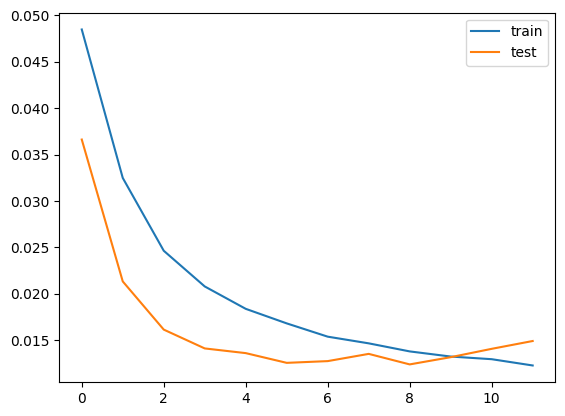

274/274 [==============================] - 1s 2ms/step
MAPE: 7.62120150819042
RMSE: 1289.3708741615835
Correlation 0.8907994245469826 with p-value 0.0
---------------
32875 8759
shape 1 15
Epoch 1/50
257/257 - 7s - loss: 0.0459 - val_loss: 0.0457 - 7s/epoch - 26ms/step
Epoch 2/50
257/257 - 2s - loss: 0.0271 - val_loss: 0.0322 - 2s/epoch - 6ms/step
Epoch 3/50
257/257 - 2s - loss: 0.0210 - val_loss: 0.0312 - 2s/epoch - 6ms/step
Epoch 4/50
257/257 - 2s - loss: 0.0178 - val_loss: 0.0303 - 2s/epoch - 6ms/step
Epoch 5/50
257/257 - 1s - loss: 0.0165 - val_loss: 0.0290 - 1s/epoch - 6ms/step
Epoch 6/50
257/257 - 1s - loss: 0.0152 - val_loss: 0.0299 - 1s/epoch - 5ms/step
Epoch 7/50
257/257 - 1s - loss: 0.0145 - val_loss: 0.0299 - 1s/epoch - 6ms/step
Epoch 8/50
257/257 - 2s - loss: 0.0139 - val_loss: 0.0305 - 2s/epoch - 7ms/step
Epoch 9/50
257/257 - 2s - loss: 0.0136 - val_loss: 0.0290 - 2s/epoch - 8ms/step
Epoch 10/50
257/257 - 2s - loss: 0.0131 - val_loss: 0.0289 - 2s/epoch - 8ms/step
Epoch 11/

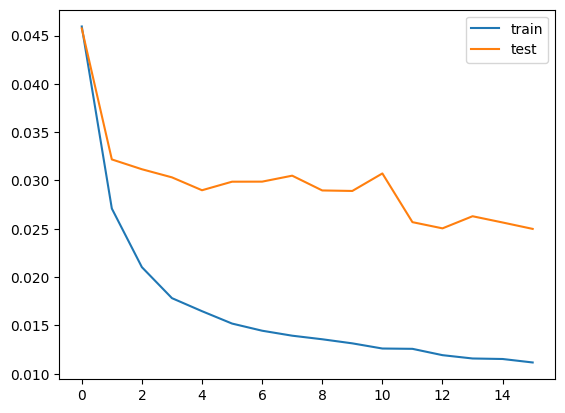

274/274 [==============================] - 1s 3ms/step
MAPE: 12.009386524571662
RMSE: 1680.7018435400028
Correlation 0.8659766130929191 with p-value 0.0
---------------
41634 8759
shape 1 15
Epoch 1/50
326/326 - 5s - loss: 0.0420 - val_loss: 0.0166 - 5s/epoch - 16ms/step
Epoch 2/50
326/326 - 2s - loss: 0.0231 - val_loss: 0.0106 - 2s/epoch - 5ms/step
Epoch 3/50
326/326 - 2s - loss: 0.0179 - val_loss: 0.0105 - 2s/epoch - 5ms/step
Epoch 4/50
326/326 - 2s - loss: 0.0154 - val_loss: 0.0083 - 2s/epoch - 7ms/step
Epoch 5/50
326/326 - 3s - loss: 0.0140 - val_loss: 0.0107 - 3s/epoch - 8ms/step
Epoch 6/50
326/326 - 2s - loss: 0.0130 - val_loss: 0.0116 - 2s/epoch - 5ms/step
Epoch 7/50
326/326 - 2s - loss: 0.0124 - val_loss: 0.0139 - 2s/epoch - 5ms/step
Epoch 8/50
326/326 - 2s - loss: 0.0118 - val_loss: 0.0173 - 2s/epoch - 6ms/step
Epoch 9/50
326/326 - 2s - loss: 0.0113 - val_loss: 0.0193 - 2s/epoch - 5ms/step
Epoch 10/50
326/326 - 2s - loss: 0.0109 - val_loss: 0.0208 - 2s/epoch - 5ms/step
Epoch 1

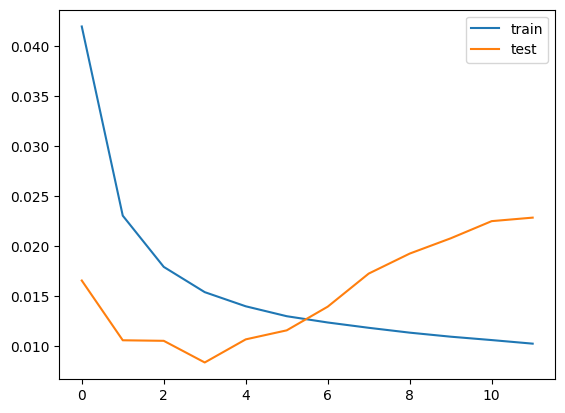

274/274 [==============================] - 1s 2ms/step
MAPE: 10.911060765120952
RMSE: 1607.3360868327857
Correlation 0.9038251937542752 with p-value 0.0
---------------
50393 8784
shape 1 15
Epoch 1/50
394/394 - 7s - loss: 0.0380 - val_loss: 0.0193 - 7s/epoch - 19ms/step
Epoch 2/50
394/394 - 2s - loss: 0.0203 - val_loss: 0.0178 - 2s/epoch - 5ms/step
Epoch 3/50
394/394 - 2s - loss: 0.0160 - val_loss: 0.0187 - 2s/epoch - 5ms/step
Epoch 4/50
394/394 - 2s - loss: 0.0143 - val_loss: 0.0254 - 2s/epoch - 5ms/step
Epoch 5/50
394/394 - 2s - loss: 0.0131 - val_loss: 0.0244 - 2s/epoch - 5ms/step
Epoch 6/50
394/394 - 2s - loss: 0.0124 - val_loss: 0.0259 - 2s/epoch - 6ms/step
Epoch 7/50
394/394 - 3s - loss: 0.0119 - val_loss: 0.0268 - 3s/epoch - 8ms/step
Epoch 8/50
394/394 - 2s - loss: 0.0114 - val_loss: 0.0265 - 2s/epoch - 6ms/step
Epoch 9/50
394/394 - 2s - loss: 0.0110 - val_loss: 0.0280 - 2s/epoch - 5ms/step
Epoch 10/50
394/394 - 2s - loss: 0.0107 - val_loss: 0.0272 - 2s/epoch - 5ms/step
Epoch 1

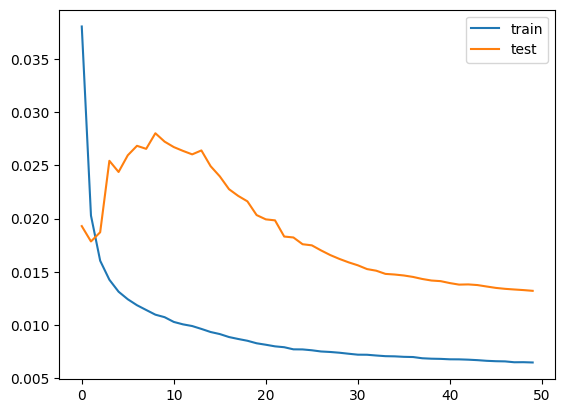

275/275 [==============================] - 1s 2ms/step
MAPE: 7.297611014707646
RMSE: 1222.4061908219926
Correlation 0.8131491765809278 with p-value 0.0
---------------
59177 8760
shape 1 15
Epoch 1/50
463/463 - 7s - loss: 0.0359 - val_loss: 0.0444 - 7s/epoch - 14ms/step
Epoch 2/50
463/463 - 2s - loss: 0.0198 - val_loss: 0.0340 - 2s/epoch - 5ms/step
Epoch 3/50
463/463 - 2s - loss: 0.0159 - val_loss: 0.0283 - 2s/epoch - 5ms/step
Epoch 4/50
463/463 - 3s - loss: 0.0141 - val_loss: 0.0257 - 3s/epoch - 7ms/step
Epoch 5/50
463/463 - 3s - loss: 0.0130 - val_loss: 0.0265 - 3s/epoch - 6ms/step
Epoch 6/50
463/463 - 2s - loss: 0.0123 - val_loss: 0.0233 - 2s/epoch - 5ms/step
Epoch 7/50
463/463 - 2s - loss: 0.0117 - val_loss: 0.0246 - 2s/epoch - 5ms/step
Epoch 8/50
463/463 - 2s - loss: 0.0112 - val_loss: 0.0216 - 2s/epoch - 5ms/step
Epoch 9/50
463/463 - 2s - loss: 0.0107 - val_loss: 0.0204 - 2s/epoch - 5ms/step
Epoch 10/50
463/463 - 4s - loss: 0.0103 - val_loss: 0.0204 - 4s/epoch - 8ms/step
Epoch 11

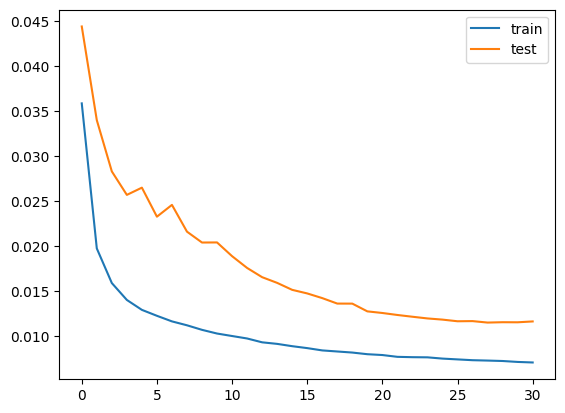

274/274 [==============================] - 1s 3ms/step
MAPE: 6.49953399562239
RMSE: 1148.6695608337004
Correlation 0.8418805200811202 with p-value 0.0
---------------
67937 8760
shape 1 15
Epoch 1/50
531/531 - 6s - loss: 0.0338 - val_loss: 0.0213 - 6s/epoch - 11ms/step
Epoch 2/50
531/531 - 3s - loss: 0.0180 - val_loss: 0.0159 - 3s/epoch - 5ms/step
Epoch 3/50
531/531 - 4s - loss: 0.0145 - val_loss: 0.0124 - 4s/epoch - 7ms/step
Epoch 4/50
531/531 - 3s - loss: 0.0131 - val_loss: 0.0114 - 3s/epoch - 6ms/step
Epoch 5/50
531/531 - 3s - loss: 0.0123 - val_loss: 0.0107 - 3s/epoch - 5ms/step
Epoch 6/50
531/531 - 3s - loss: 0.0117 - val_loss: 0.0106 - 3s/epoch - 5ms/step
Epoch 7/50
531/531 - 3s - loss: 0.0111 - val_loss: 0.0110 - 3s/epoch - 5ms/step
Epoch 8/50
531/531 - 4s - loss: 0.0106 - val_loss: 0.0117 - 4s/epoch - 7ms/step
Epoch 9/50
531/531 - 3s - loss: 0.0103 - val_loss: 0.0122 - 3s/epoch - 6ms/step
Epoch 10/50
531/531 - 3s - loss: 0.0099 - val_loss: 0.0131 - 3s/epoch - 5ms/step
Epoch 11/

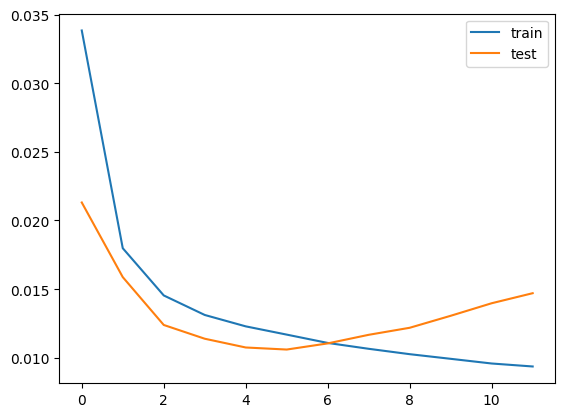

274/274 [==============================] - 1s 3ms/step
MAPE: 7.542347037180964
RMSE: 1329.8796608722646
Correlation 0.8261156687846466 with p-value 0.0
---------------
76697 3622
shape 1 15
Epoch 1/50
600/600 - 11s - loss: 0.0310 - val_loss: 0.0195 - 11s/epoch - 18ms/step
Epoch 2/50
600/600 - 5s - loss: 0.0165 - val_loss: 0.0148 - 5s/epoch - 8ms/step
Epoch 3/50
600/600 - 4s - loss: 0.0136 - val_loss: 0.0127 - 4s/epoch - 6ms/step
Epoch 4/50
600/600 - 4s - loss: 0.0124 - val_loss: 0.0118 - 4s/epoch - 6ms/step
Epoch 5/50
600/600 - 5s - loss: 0.0118 - val_loss: 0.0110 - 5s/epoch - 8ms/step
Epoch 6/50
600/600 - 4s - loss: 0.0113 - val_loss: 0.0104 - 4s/epoch - 6ms/step
Epoch 7/50
600/600 - 4s - loss: 0.0107 - val_loss: 0.0100 - 4s/epoch - 6ms/step
Epoch 8/50
600/600 - 4s - loss: 0.0105 - val_loss: 0.0098 - 4s/epoch - 6ms/step
Epoch 9/50
600/600 - 5s - loss: 0.0101 - val_loss: 0.0100 - 5s/epoch - 9ms/step
Epoch 10/50
600/600 - 4s - loss: 0.0099 - val_loss: 0.0103 - 4s/epoch - 6ms/step
Epoch 

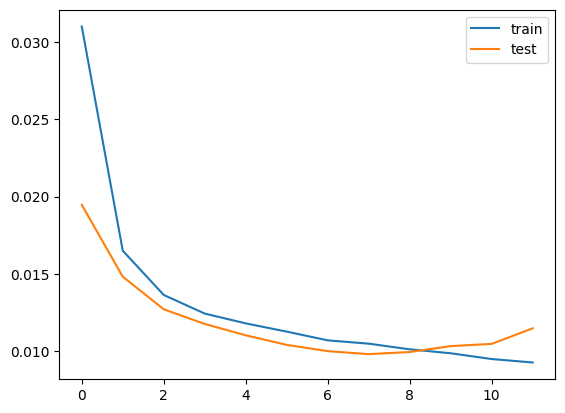

114/114 [==============================] - 2s 7ms/step
MAPE: 6.654385725165926
RMSE: 1192.7790296880546
Correlation 0.8594444138848233 with p-value 0.0
---------------
AVG
----------------------------------
1326.49 & 8.31 & 0.86 & 1255.42 & 7.05 & 0.9 
----------------------------------
GENERAL FOLDS
----------------------------------
1140.77 & 7.98 & 0.9
1289.37 & 7.62 & 0.89
1680.7 & 12.01 & 0.87
1607.34 & 10.91 & 0.9
1222.41 & 7.3 & 0.81
1148.67 & 6.5 & 0.84
1329.88 & 7.54 & 0.83
1192.78 & 6.65 & 0.86
----------------------------------
WINTERTIME FOLDS
----------------------------------
1131.93 & 7.08 & 0.92
1761.04 & 10.32 & 0.9
1051.4 & 6.22 & 0.92
1267.18 & 7.34 & 0.91
1200.48 & 6.32 & 0.9
1246.36 & 6.51 & 0.92
1261.23 & 6.66 & 0.88
1123.73 & 5.94 & 0.88


In [ ]:
rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list = run_cv(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=False,
    use_no_predictors=True,
    include_price_bool=False,
    include_climate_change_bool=True,
    huang=False,
    tan=True,
    train_test_indices=train_test_indices,
    folder_name='no_predictors_climate_change')

### Huang ALL

15333 8783
shape 1 12
Epoch 1/50
120/120 - 4s - loss: 0.0695 - val_loss: 0.0196 - 4s/epoch - 32ms/step
Epoch 2/50
120/120 - 1s - loss: 0.0112 - val_loss: 0.0075 - 1s/epoch - 9ms/step
Epoch 3/50
120/120 - 1s - loss: 0.0065 - val_loss: 0.0069 - 1s/epoch - 11ms/step
Epoch 4/50
120/120 - 1s - loss: 0.0054 - val_loss: 0.0074 - 1s/epoch - 11ms/step
Epoch 5/50
120/120 - 1s - loss: 0.0048 - val_loss: 0.0080 - 1s/epoch - 11ms/step
Epoch 6/50
120/120 - 1s - loss: 0.0044 - val_loss: 0.0084 - 856ms/epoch - 7ms/step
Epoch 7/50
120/120 - 1s - loss: 0.0042 - val_loss: 0.0086 - 969ms/epoch - 8ms/step
Epoch 8/50
120/120 - 1s - loss: 0.0040 - val_loss: 0.0087 - 971ms/epoch - 8ms/step
Epoch 9/50
120/120 - 1s - loss: 0.0039 - val_loss: 0.0087 - 806ms/epoch - 7ms/step
Epoch 10/50
120/120 - 1s - loss: 0.0038 - val_loss: 0.0085 - 962ms/epoch - 8ms/step
Epoch 11/50
120/120 - 1s - loss: 0.0038 - val_loss: 0.0081 - 792ms/epoch - 7ms/step
Epoch 12/50
120/120 - 1s - loss: 0.0038 - val_loss: 0.0076 - 936ms/epoch -

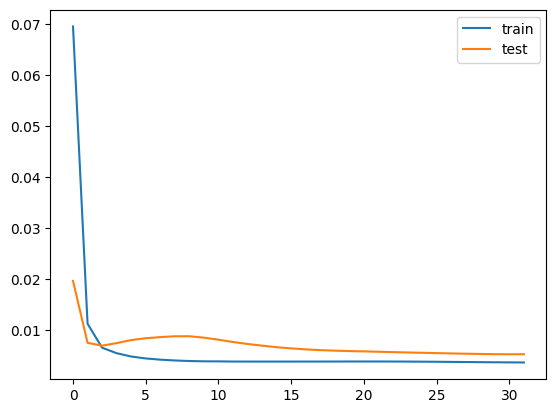

275/275 [==============================] - 1s 3ms/step
MAPE: 4.474958434776039
RMSE: 742.3720305067803
Correlation 0.9579829634965322 with p-value 0.0
---------------
24116 8759
shape 1 12
Epoch 1/50
189/189 - 4s - loss: 0.0426 - val_loss: 0.0146 - 4s/epoch - 22ms/step
Epoch 2/50
189/189 - 1s - loss: 0.0083 - val_loss: 0.0149 - 1s/epoch - 7ms/step
Epoch 3/50
189/189 - 1s - loss: 0.0058 - val_loss: 0.0167 - 1s/epoch - 7ms/step
Epoch 4/50
189/189 - 1s - loss: 0.0049 - val_loss: 0.0187 - 1s/epoch - 6ms/step
Epoch 5/50
189/189 - 1s - loss: 0.0046 - val_loss: 0.0214 - 1s/epoch - 6ms/step
Epoch 6/50
189/189 - 2s - loss: 0.0046 - val_loss: 0.0244 - 2s/epoch - 8ms/step
Epoch 7/50
189/189 - 2s - loss: 0.0045 - val_loss: 0.0276 - 2s/epoch - 11ms/step
Epoch 8/50
189/189 - 2s - loss: 0.0045 - val_loss: 0.0305 - 2s/epoch - 10ms/step
Epoch 9/50
189/189 - 1s - loss: 0.0044 - val_loss: 0.0324 - 1s/epoch - 7ms/step
Epoch 10/50
189/189 - 1s - loss: 0.0043 - val_loss: 0.0337 - 1s/epoch - 7ms/step
Epoch 1

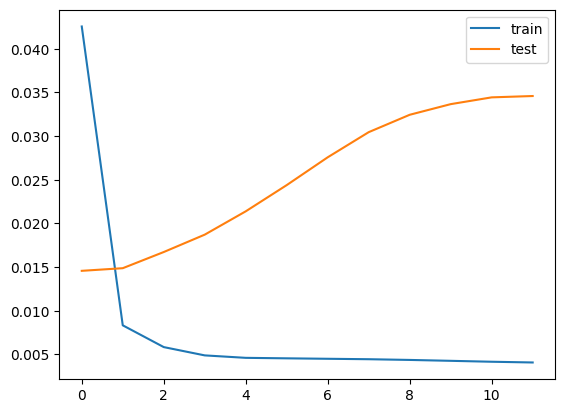

274/274 [==============================] - 1s 2ms/step
MAPE: 13.283580905607536
RMSE: 1964.9615880465215
Correlation 0.9256989496808719 with p-value 0.0
---------------
32875 8759
shape 1 12
Epoch 1/50
257/257 - 6s - loss: 0.0352 - val_loss: 0.0101 - 6s/epoch - 23ms/step
Epoch 2/50
257/257 - 2s - loss: 0.0082 - val_loss: 0.0067 - 2s/epoch - 6ms/step
Epoch 3/50
257/257 - 2s - loss: 0.0061 - val_loss: 0.0056 - 2s/epoch - 6ms/step
Epoch 4/50
257/257 - 2s - loss: 0.0057 - val_loss: 0.0055 - 2s/epoch - 6ms/step
Epoch 5/50
257/257 - 2s - loss: 0.0057 - val_loss: 0.0058 - 2s/epoch - 6ms/step
Epoch 6/50
257/257 - 2s - loss: 0.0058 - val_loss: 0.0062 - 2s/epoch - 6ms/step
Epoch 7/50
257/257 - 2s - loss: 0.0058 - val_loss: 0.0069 - 2s/epoch - 10ms/step
Epoch 8/50
257/257 - 3s - loss: 0.0057 - val_loss: 0.0078 - 3s/epoch - 10ms/step
Epoch 9/50
257/257 - 1s - loss: 0.0057 - val_loss: 0.0091 - 1s/epoch - 6ms/step
Epoch 10/50
257/257 - 2s - loss: 0.0056 - val_loss: 0.0107 - 2s/epoch - 6ms/step
Epoch

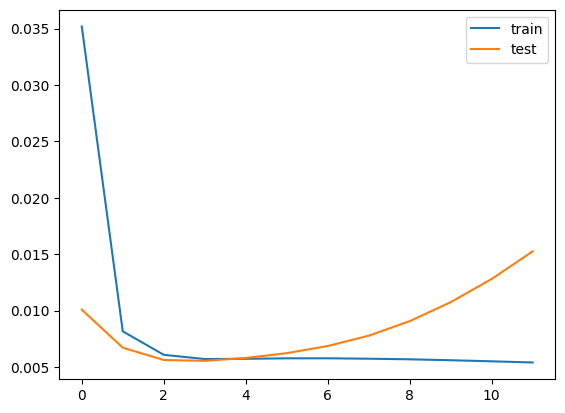

274/274 [==============================] - 1s 2ms/step
MAPE: 8.515889138105049
RMSE: 1313.1313095203534
Correlation 0.9118522799510193 with p-value 0.0
---------------
41634 8759
shape 1 12
Epoch 1/50
326/326 - 5s - loss: 0.0271 - val_loss: 0.0144 - 5s/epoch - 15ms/step
Epoch 2/50
326/326 - 2s - loss: 0.0061 - val_loss: 0.0113 - 2s/epoch - 6ms/step
Epoch 3/50
326/326 - 3s - loss: 0.0052 - val_loss: 0.0096 - 3s/epoch - 8ms/step
Epoch 4/50
326/326 - 3s - loss: 0.0050 - val_loss: 0.0075 - 3s/epoch - 9ms/step
Epoch 5/50
326/326 - 2s - loss: 0.0048 - val_loss: 0.0062 - 2s/epoch - 6ms/step
Epoch 6/50
326/326 - 2s - loss: 0.0046 - val_loss: 0.0058 - 2s/epoch - 6ms/step
Epoch 7/50
326/326 - 2s - loss: 0.0045 - val_loss: 0.0060 - 2s/epoch - 6ms/step
Epoch 8/50
326/326 - 2s - loss: 0.0044 - val_loss: 0.0062 - 2s/epoch - 6ms/step
Epoch 9/50
326/326 - 2s - loss: 0.0043 - val_loss: 0.0065 - 2s/epoch - 5ms/step
Epoch 10/50
326/326 - 3s - loss: 0.0042 - val_loss: 0.0067 - 3s/epoch - 8ms/step
Epoch 11

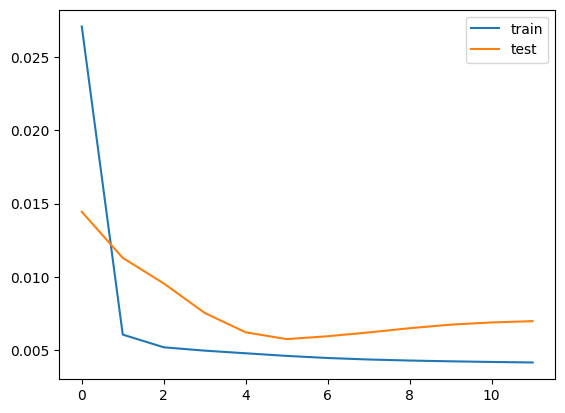

274/274 [==============================] - 1s 2ms/step
MAPE: 5.393052220616475
RMSE: 888.1940979747536
Correlation 0.9165125135902156 with p-value 0.0
---------------
50393 8784
shape 1 12
Epoch 1/50
394/394 - 5s - loss: 0.0268 - val_loss: 0.0145 - 5s/epoch - 13ms/step
Epoch 2/50
394/394 - 3s - loss: 0.0081 - val_loss: 0.0115 - 3s/epoch - 8ms/step
Epoch 3/50
394/394 - 3s - loss: 0.0059 - val_loss: 0.0107 - 3s/epoch - 8ms/step
Epoch 4/50
394/394 - 2s - loss: 0.0051 - val_loss: 0.0111 - 2s/epoch - 5ms/step
Epoch 5/50
394/394 - 2s - loss: 0.0047 - val_loss: 0.0121 - 2s/epoch - 6ms/step
Epoch 6/50
394/394 - 2s - loss: 0.0044 - val_loss: 0.0131 - 2s/epoch - 6ms/step
Epoch 7/50
394/394 - 2s - loss: 0.0043 - val_loss: 0.0138 - 2s/epoch - 5ms/step
Epoch 8/50
394/394 - 3s - loss: 0.0042 - val_loss: 0.0140 - 3s/epoch - 9ms/step
Epoch 9/50
394/394 - 3s - loss: 0.0042 - val_loss: 0.0138 - 3s/epoch - 8ms/step
Epoch 10/50
394/394 - 2s - loss: 0.0041 - val_loss: 0.0135 - 2s/epoch - 6ms/step
Epoch 11/

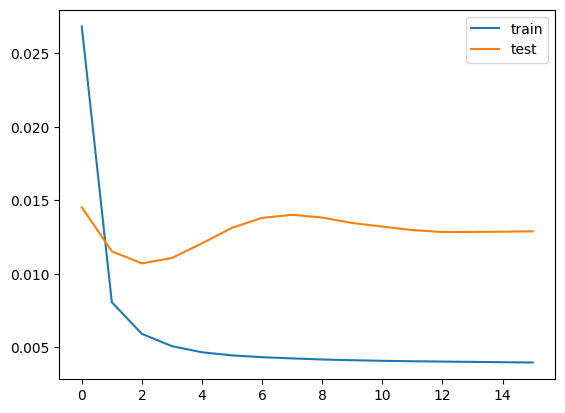

275/275 [==============================] - 1s 2ms/step
MAPE: 6.679628504987159
RMSE: 1207.3829148147647
Correlation 0.8592879017271967 with p-value 0.0
---------------
59177 8760
shape 1 12
Epoch 1/50
463/463 - 7s - loss: 0.0238 - val_loss: 0.0093 - 7s/epoch - 16ms/step
Epoch 2/50
463/463 - 3s - loss: 0.0057 - val_loss: 0.0092 - 3s/epoch - 6ms/step
Epoch 3/50
463/463 - 2s - loss: 0.0052 - val_loss: 0.0098 - 2s/epoch - 5ms/step
Epoch 4/50
463/463 - 2s - loss: 0.0052 - val_loss: 0.0099 - 2s/epoch - 5ms/step
Epoch 5/50
463/463 - 4s - loss: 0.0052 - val_loss: 0.0098 - 4s/epoch - 8ms/step
Epoch 6/50
463/463 - 3s - loss: 0.0052 - val_loss: 0.0097 - 3s/epoch - 7ms/step
Epoch 7/50
463/463 - 3s - loss: 0.0051 - val_loss: 0.0096 - 3s/epoch - 6ms/step
Epoch 8/50
463/463 - 3s - loss: 0.0051 - val_loss: 0.0094 - 3s/epoch - 5ms/step
Epoch 9/50
463/463 - 2s - loss: 0.0050 - val_loss: 0.0093 - 2s/epoch - 5ms/step
Epoch 10/50
463/463 - 4s - loss: 0.0050 - val_loss: 0.0093 - 4s/epoch - 8ms/step
Epoch 11

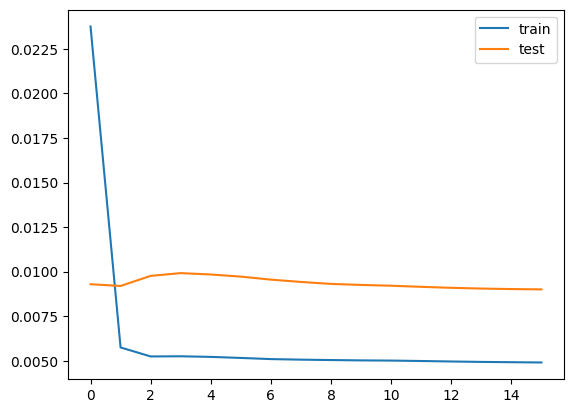

274/274 [==============================] - 1s 2ms/step
MAPE: 5.7761877965961475
RMSE: 1009.0862727834688
Correlation 0.8767732976570335 with p-value 0.0
---------------
67937 8760
shape 1 12
Epoch 1/50
531/531 - 6s - loss: 0.0207 - val_loss: 0.0089 - 6s/epoch - 11ms/step
Epoch 2/50
531/531 - 5s - loss: 0.0054 - val_loss: 0.0085 - 5s/epoch - 9ms/step
Epoch 3/50
531/531 - 3s - loss: 0.0050 - val_loss: 0.0085 - 3s/epoch - 6ms/step
Epoch 4/50
531/531 - 3s - loss: 0.0050 - val_loss: 0.0082 - 3s/epoch - 6ms/step
Epoch 5/50
531/531 - 3s - loss: 0.0049 - val_loss: 0.0080 - 3s/epoch - 6ms/step
Epoch 6/50
531/531 - 4s - loss: 0.0048 - val_loss: 0.0079 - 4s/epoch - 7ms/step
Epoch 7/50
531/531 - 4s - loss: 0.0048 - val_loss: 0.0079 - 4s/epoch - 7ms/step
Epoch 8/50
531/531 - 3s - loss: 0.0048 - val_loss: 0.0080 - 3s/epoch - 5ms/step
Epoch 9/50
531/531 - 3s - loss: 0.0048 - val_loss: 0.0082 - 3s/epoch - 5ms/step
Epoch 10/50
531/531 - 3s - loss: 0.0047 - val_loss: 0.0086 - 3s/epoch - 6ms/step
Epoch 1

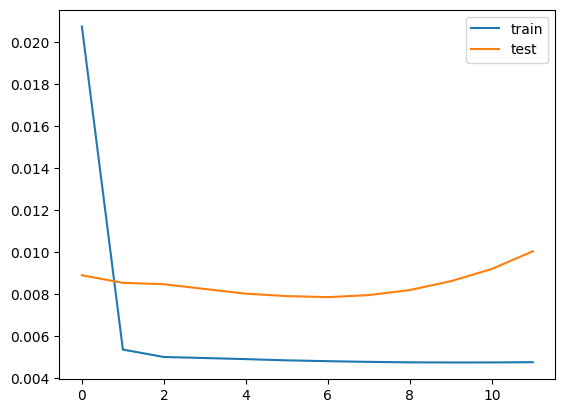

274/274 [==============================] - 1s 2ms/step
MAPE: 6.099965630552195
RMSE: 1099.1276003073901
Correlation 0.8637641920748984 with p-value 0.0
---------------
76697 3622
shape 1 12
Epoch 1/50
600/600 - 7s - loss: 0.0186 - val_loss: 0.0116 - 7s/epoch - 11ms/step
Epoch 2/50
600/600 - 4s - loss: 0.0058 - val_loss: 0.0116 - 4s/epoch - 7ms/step
Epoch 3/50
600/600 - 3s - loss: 0.0053 - val_loss: 0.0153 - 3s/epoch - 5ms/step
Epoch 4/50
600/600 - 3s - loss: 0.0052 - val_loss: 0.0191 - 3s/epoch - 5ms/step
Epoch 5/50
600/600 - 3s - loss: 0.0051 - val_loss: 0.0209 - 3s/epoch - 5ms/step
Epoch 6/50
600/600 - 5s - loss: 0.0050 - val_loss: 0.0214 - 5s/epoch - 8ms/step
Epoch 7/50
600/600 - 3s - loss: 0.0050 - val_loss: 0.0212 - 3s/epoch - 5ms/step
Epoch 8/50
600/600 - 3s - loss: 0.0050 - val_loss: 0.0202 - 3s/epoch - 5ms/step
Epoch 9/50
600/600 - 3s - loss: 0.0050 - val_loss: 0.0185 - 3s/epoch - 5ms/step
Epoch 10/50
600/600 - 5s - loss: 0.0050 - val_loss: 0.0167 - 5s/epoch - 8ms/step
Epoch 11

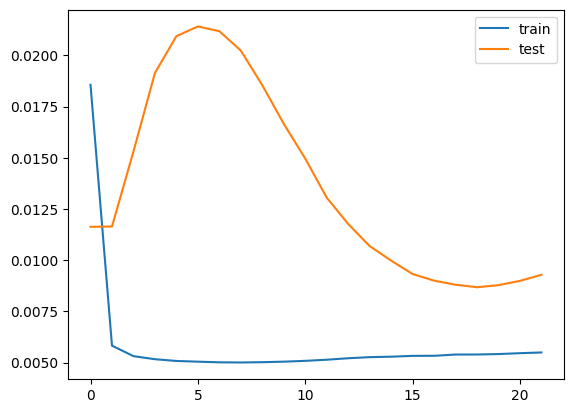

114/114 [==============================] - 1s 2ms/step
MAPE: 5.932114720898811
RMSE: 1072.5235377295064
Correlation 0.8926708711561392 with p-value 0.0
---------------
AVG
----------------------------------
1162.1 & 7.02 & 0.9 & 1079.45 & 5.9 & 0.92 
----------------------------------
GENERAL FOLDS
----------------------------------
742.37 & 4.47 & 0.96
1964.96 & 13.28 & 0.93
1313.13 & 8.52 & 0.91
888.19 & 5.39 & 0.92
1207.38 & 6.68 & 0.86
1009.09 & 5.78 & 0.88
1099.13 & 6.1 & 0.86
1072.52 & 5.93 & 0.89
----------------------------------
WINTERTIME FOLDS
----------------------------------
963.27 & 5.26 & 0.95
1660.4 & 10.0 & 0.92
877.04 & 4.64 & 0.94
1088.32 & 6.16 & 0.94
969.77 & 5.02 & 0.91
923.9 & 4.84 & 0.93
1007.64 & 5.23 & 0.91
1145.3 & 6.03 & 0.9


In [ ]:
rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list = run_cv(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=True,
    use_no_predictors=False,
    include_price_bool=False,
    include_climate_change_bool=True,
    huang=True,
    tan=False,
    train_test_indices=train_test_indices,
    folder_name='all_predictors_climate_change')

### Huang None

15333 8783
shape 1 15
Epoch 1/50
120/120 - 5s - loss: 0.0541 - val_loss: 0.0187 - 5s/epoch - 44ms/step
Epoch 2/50
120/120 - 2s - loss: 0.0136 - val_loss: 0.0240 - 2s/epoch - 13ms/step
Epoch 3/50
120/120 - 1s - loss: 0.0111 - val_loss: 0.0246 - 978ms/epoch - 8ms/step
Epoch 4/50
120/120 - 1s - loss: 0.0101 - val_loss: 0.0238 - 918ms/epoch - 8ms/step
Epoch 5/50
120/120 - 1s - loss: 0.0095 - val_loss: 0.0231 - 915ms/epoch - 8ms/step
Epoch 6/50
120/120 - 1s - loss: 0.0093 - val_loss: 0.0231 - 906ms/epoch - 8ms/step
Epoch 7/50
120/120 - 1s - loss: 0.0093 - val_loss: 0.0242 - 908ms/epoch - 8ms/step
Epoch 8/50
120/120 - 1s - loss: 0.0091 - val_loss: 0.0267 - 904ms/epoch - 8ms/step
Epoch 9/50
120/120 - 1s - loss: 0.0092 - val_loss: 0.0291 - 899ms/epoch - 7ms/step
Epoch 10/50
120/120 - 1s - loss: 0.0089 - val_loss: 0.0308 - 1s/epoch - 9ms/step
Epoch 11/50
120/120 - 1s - loss: 0.0084 - val_loss: 0.0318 - 1s/epoch - 9ms/step
Epoch 12/50
120/120 - 1s - loss: 0.0077 - val_loss: 0.0313 - 925ms/epoch 

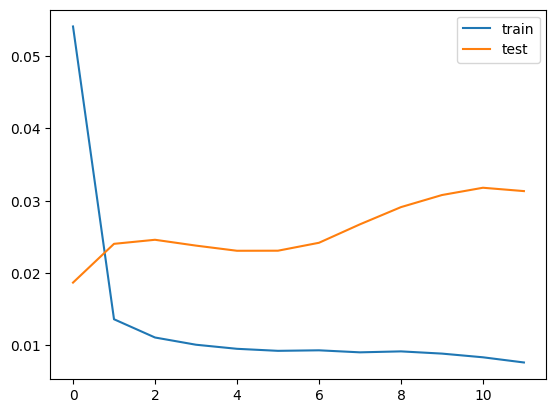

275/275 [==============================] - 1s 4ms/step
MAPE: 10.907095744868847
RMSE: 1819.069081511928
Correlation 0.9184720760232233 with p-value 0.0
---------------
24116 8759
shape 1 15
Epoch 1/50
189/189 - 5s - loss: 0.0533 - val_loss: 0.0107 - 5s/epoch - 27ms/step
Epoch 2/50
189/189 - 1s - loss: 0.0089 - val_loss: 0.0080 - 1s/epoch - 7ms/step
Epoch 3/50
189/189 - 1s - loss: 0.0058 - val_loss: 0.0086 - 1s/epoch - 8ms/step
Epoch 4/50
189/189 - 1s - loss: 0.0050 - val_loss: 0.0107 - 1s/epoch - 7ms/step
Epoch 5/50
189/189 - 1s - loss: 0.0048 - val_loss: 0.0133 - 1s/epoch - 7ms/step
Epoch 6/50
189/189 - 1s - loss: 0.0047 - val_loss: 0.0159 - 1s/epoch - 7ms/step
Epoch 7/50
189/189 - 2s - loss: 0.0047 - val_loss: 0.0182 - 2s/epoch - 8ms/step
Epoch 8/50
189/189 - 2s - loss: 0.0045 - val_loss: 0.0201 - 2s/epoch - 11ms/step
Epoch 9/50
189/189 - 2s - loss: 0.0044 - val_loss: 0.0213 - 2s/epoch - 11ms/step
Epoch 10/50
189/189 - 1s - loss: 0.0043 - val_loss: 0.0221 - 1s/epoch - 8ms/step
Epoch 

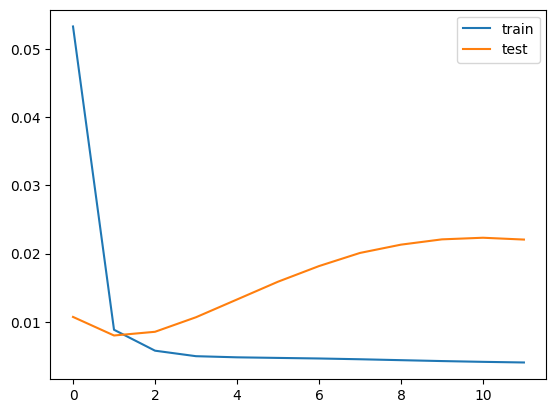

274/274 [==============================] - 1s 2ms/step
MAPE: 9.568085553063428
RMSE: 1569.334182270441
Correlation 0.926985183930438 with p-value 0.0
---------------
32875 8759
shape 1 15
Epoch 1/50
257/257 - 5s - loss: 0.0355 - val_loss: 0.0170 - 5s/epoch - 20ms/step
Epoch 2/50
257/257 - 3s - loss: 0.0072 - val_loss: 0.0265 - 3s/epoch - 10ms/step
Epoch 3/50
257/257 - 2s - loss: 0.0058 - val_loss: 0.0236 - 2s/epoch - 8ms/step
Epoch 4/50
257/257 - 2s - loss: 0.0054 - val_loss: 0.0171 - 2s/epoch - 7ms/step
Epoch 5/50
257/257 - 2s - loss: 0.0051 - val_loss: 0.0100 - 2s/epoch - 7ms/step
Epoch 6/50
257/257 - 2s - loss: 0.0050 - val_loss: 0.0076 - 2s/epoch - 6ms/step
Epoch 7/50
257/257 - 2s - loss: 0.0049 - val_loss: 0.0069 - 2s/epoch - 6ms/step
Epoch 8/50
257/257 - 2s - loss: 0.0048 - val_loss: 0.0066 - 2s/epoch - 7ms/step
Epoch 9/50
257/257 - 2s - loss: 0.0048 - val_loss: 0.0065 - 2s/epoch - 10ms/step
Epoch 10/50
257/257 - 3s - loss: 0.0048 - val_loss: 0.0064 - 3s/epoch - 11ms/step
Epoch 1

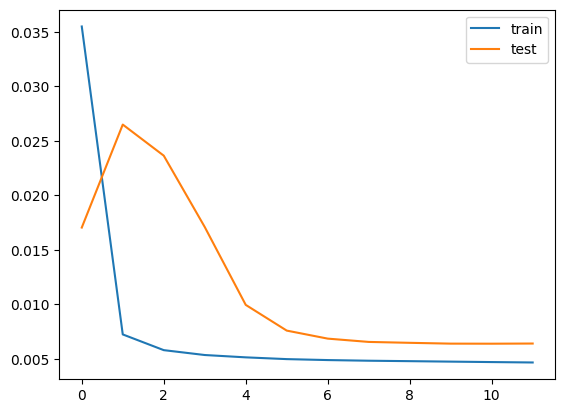

274/274 [==============================] - 1s 2ms/step
MAPE: 4.933143482836701
RMSE: 851.3013989610726
Correlation 0.9322037137343108 with p-value 0.0
---------------
41634 8759
shape 1 15
Epoch 1/50
326/326 - 5s - loss: 0.0267 - val_loss: 0.0122 - 5s/epoch - 16ms/step
Epoch 2/50
326/326 - 3s - loss: 0.0081 - val_loss: 0.0096 - 3s/epoch - 10ms/step
Epoch 3/50
326/326 - 2s - loss: 0.0063 - val_loss: 0.0095 - 2s/epoch - 6ms/step
Epoch 4/50
326/326 - 2s - loss: 0.0057 - val_loss: 0.0098 - 2s/epoch - 6ms/step
Epoch 5/50
326/326 - 2s - loss: 0.0055 - val_loss: 0.0095 - 2s/epoch - 6ms/step
Epoch 6/50
326/326 - 2s - loss: 0.0054 - val_loss: 0.0091 - 2s/epoch - 6ms/step
Epoch 7/50
326/326 - 2s - loss: 0.0053 - val_loss: 0.0087 - 2s/epoch - 6ms/step
Epoch 8/50
326/326 - 3s - loss: 0.0051 - val_loss: 0.0083 - 3s/epoch - 9ms/step
Epoch 9/50
326/326 - 3s - loss: 0.0050 - val_loss: 0.0079 - 3s/epoch - 9ms/step
Epoch 10/50
326/326 - 2s - loss: 0.0049 - val_loss: 0.0076 - 2s/epoch - 6ms/step
Epoch 11

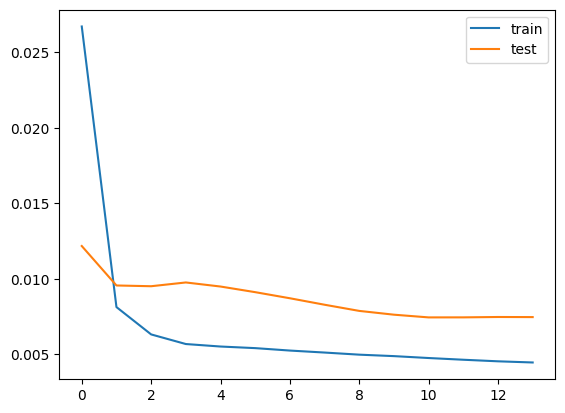

274/274 [==============================] - 1s 2ms/step
MAPE: 5.353588569031673
RMSE: 919.1550789444888
Correlation 0.9070898177544264 with p-value 0.0
---------------
50393 8784
shape 1 15
Epoch 1/50
394/394 - 7s - loss: 0.0235 - val_loss: 0.0194 - 7s/epoch - 18ms/step
Epoch 2/50
394/394 - 2s - loss: 0.0064 - val_loss: 0.0141 - 2s/epoch - 6ms/step
Epoch 3/50
394/394 - 2s - loss: 0.0054 - val_loss: 0.0116 - 2s/epoch - 6ms/step
Epoch 4/50
394/394 - 2s - loss: 0.0049 - val_loss: 0.0105 - 2s/epoch - 6ms/step
Epoch 5/50
394/394 - 2s - loss: 0.0046 - val_loss: 0.0101 - 2s/epoch - 6ms/step
Epoch 6/50
394/394 - 4s - loss: 0.0044 - val_loss: 0.0098 - 4s/epoch - 10ms/step
Epoch 7/50
394/394 - 3s - loss: 0.0043 - val_loss: 0.0097 - 3s/epoch - 6ms/step
Epoch 8/50
394/394 - 2s - loss: 0.0042 - val_loss: 0.0096 - 2s/epoch - 6ms/step
Epoch 9/50
394/394 - 2s - loss: 0.0041 - val_loss: 0.0095 - 2s/epoch - 6ms/step
Epoch 10/50
394/394 - 2s - loss: 0.0041 - val_loss: 0.0095 - 2s/epoch - 6ms/step
Epoch 11

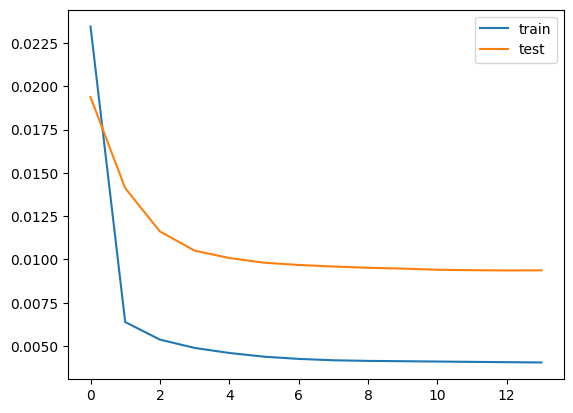

275/275 [==============================] - 1s 2ms/step
MAPE: 5.848154040467884
RMSE: 1029.5284149096362
Correlation 0.8684933787783352 with p-value 0.0
---------------
59177 8760
shape 1 15
Epoch 1/50
463/463 - 7s - loss: 0.0214 - val_loss: 0.0196 - 7s/epoch - 16ms/step
Epoch 2/50
463/463 - 3s - loss: 0.0057 - val_loss: 0.0122 - 3s/epoch - 6ms/step
Epoch 3/50
463/463 - 3s - loss: 0.0054 - val_loss: 0.0110 - 3s/epoch - 6ms/step
Epoch 4/50
463/463 - 3s - loss: 0.0054 - val_loss: 0.0108 - 3s/epoch - 6ms/step
Epoch 5/50
463/463 - 3s - loss: 0.0052 - val_loss: 0.0110 - 3s/epoch - 6ms/step
Epoch 6/50
463/463 - 4s - loss: 0.0051 - val_loss: 0.0113 - 4s/epoch - 9ms/step
Epoch 7/50
463/463 - 3s - loss: 0.0050 - val_loss: 0.0115 - 3s/epoch - 6ms/step
Epoch 8/50
463/463 - 3s - loss: 0.0049 - val_loss: 0.0115 - 3s/epoch - 6ms/step
Epoch 9/50
463/463 - 3s - loss: 0.0049 - val_loss: 0.0116 - 3s/epoch - 6ms/step
Epoch 10/50
463/463 - 3s - loss: 0.0049 - val_loss: 0.0118 - 3s/epoch - 7ms/step
Epoch 11

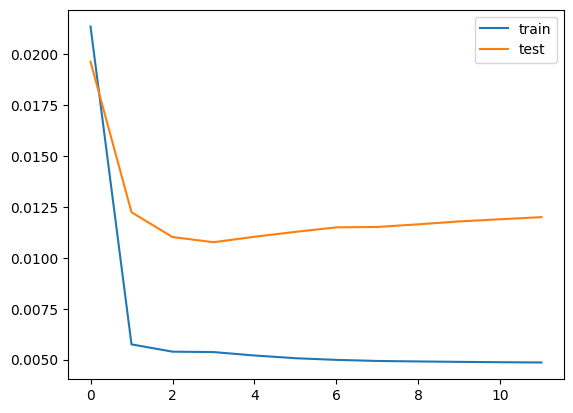

274/274 [==============================] - 1s 3ms/step
MAPE: 7.3497888950015
RMSE: 1165.0235871135692
Correlation 0.8659070629259263 with p-value 0.0
---------------
67937 8760
shape 1 15
Epoch 1/50
531/531 - 8s - loss: 0.0181 - val_loss: 0.0105 - 8s/epoch - 15ms/step
Epoch 2/50
531/531 - 3s - loss: 0.0059 - val_loss: 0.0111 - 3s/epoch - 6ms/step
Epoch 3/50
531/531 - 3s - loss: 0.0052 - val_loss: 0.0115 - 3s/epoch - 6ms/step
Epoch 4/50
531/531 - 3s - loss: 0.0051 - val_loss: 0.0107 - 3s/epoch - 6ms/step
Epoch 5/50
531/531 - 5s - loss: 0.0049 - val_loss: 0.0099 - 5s/epoch - 9ms/step
Epoch 6/50
531/531 - 3s - loss: 0.0048 - val_loss: 0.0094 - 3s/epoch - 6ms/step
Epoch 7/50
531/531 - 3s - loss: 0.0048 - val_loss: 0.0092 - 3s/epoch - 6ms/step
Epoch 8/50
531/531 - 3s - loss: 0.0047 - val_loss: 0.0091 - 3s/epoch - 5ms/step
Epoch 9/50
531/531 - 4s - loss: 0.0046 - val_loss: 0.0092 - 4s/epoch - 8ms/step
Epoch 10/50
531/531 - 3s - loss: 0.0046 - val_loss: 0.0093 - 3s/epoch - 6ms/step
Epoch 11/5

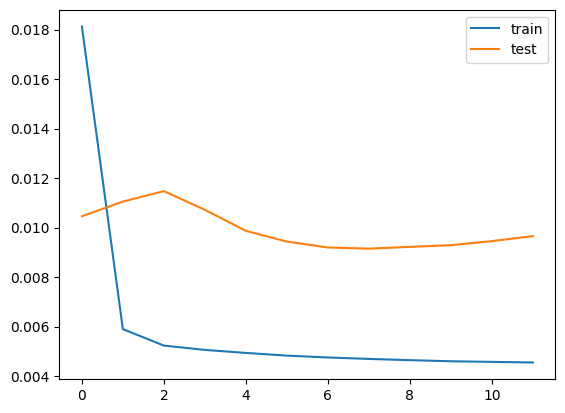

274/274 [==============================] - 1s 2ms/step
MAPE: 5.976393426419574
RMSE: 1077.899781286258
Correlation 0.8587104286330125 with p-value 0.0
---------------
76697 3622
shape 1 15
Epoch 1/50
600/600 - 7s - loss: 0.0178 - val_loss: 0.0217 - 7s/epoch - 12ms/step
Epoch 2/50
600/600 - 3s - loss: 0.0062 - val_loss: 0.0176 - 3s/epoch - 5ms/step
Epoch 3/50
600/600 - 3s - loss: 0.0052 - val_loss: 0.0166 - 3s/epoch - 6ms/step
Epoch 4/50
600/600 - 5s - loss: 0.0051 - val_loss: 0.0178 - 5s/epoch - 9ms/step
Epoch 5/50
600/600 - 3s - loss: 0.0051 - val_loss: 0.0188 - 3s/epoch - 5ms/step
Epoch 6/50
600/600 - 3s - loss: 0.0050 - val_loss: 0.0192 - 3s/epoch - 5ms/step
Epoch 7/50
600/600 - 3s - loss: 0.0050 - val_loss: 0.0188 - 3s/epoch - 5ms/step
Epoch 8/50
600/600 - 5s - loss: 0.0050 - val_loss: 0.0179 - 5s/epoch - 9ms/step
Epoch 9/50
600/600 - 3s - loss: 0.0050 - val_loss: 0.0167 - 3s/epoch - 5ms/step
Epoch 10/50
600/600 - 3s - loss: 0.0050 - val_loss: 0.0157 - 3s/epoch - 5ms/step
Epoch 11/

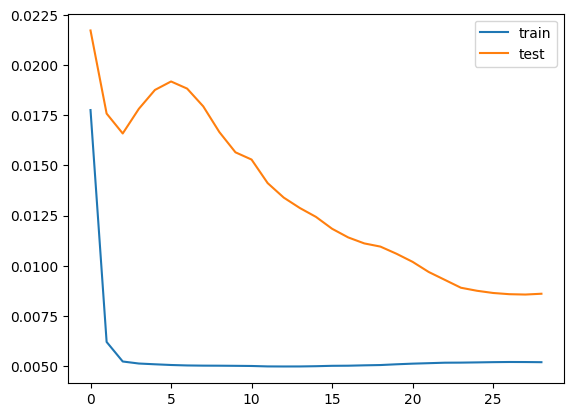

114/114 [==============================] - 1s 2ms/step
MAPE: 5.93530952813774
RMSE: 1032.1649077560267
Correlation 0.8953583250509259 with p-value 0.0
---------------
AVG
----------------------------------
1182.93 & 6.98 & 0.9 & 1304.87 & 7.32 & 0.92 
----------------------------------
GENERAL FOLDS
----------------------------------
1819.07 & 10.91 & 0.92
1569.33 & 9.57 & 0.93
851.3 & 4.93 & 0.93
919.16 & 5.35 & 0.91
1029.53 & 5.85 & 0.87
1165.02 & 7.35 & 0.87
1077.9 & 5.98 & 0.86
1032.16 & 5.94 & 0.9
----------------------------------
WINTERTIME FOLDS
----------------------------------
2560.01 & 15.66 & 0.94
1448.72 & 8.11 & 0.91
1069.9 & 5.9 & 0.95
1181.79 & 6.23 & 0.93
958.65 & 5.23 & 0.91
858.01 & 4.84 & 0.93
1265.33 & 6.65 & 0.89
1096.53 & 5.97 & 0.89


In [ ]:
rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list = run_cv(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=n_predictors,
    alpha=alpha,
    use_all_predictors=False,
    use_no_predictors=True,
    include_price_bool=False,
    include_climate_change_bool=True,
    huang=True,
    tan=False,
    train_test_indices=train_test_indices,
    folder_name='no_predictors_climate_change')

### Impact of individual climate change predictors

In [ ]:
climate_features = [
      f'dailyPrecipitation-{n_days_lag}days',
      f'dailyMeanTemperature-{n_days_lag}days',
      f'dailyMeanWindspeed-{n_days_lag}days',
      f'NAO-{n_days_lag}days',
      f'nat-{n_days_lag}days',
      f'sic-{n_days_lag}days',
      f'geopotential-{n_days_lag}days',
      f'renewableEnergyRatio-{n_days_lag}days'
      ]

In [ ]:
def predictor_selection(
    df_train_val: pd.DataFrame,
    numerical_columns_lagged: list,
    n_predictors: int,
    alpha: float,
    n_days_lag: int,
    use_all_predictors: bool,
    use_no_predictors: bool,
    include_climate_change_bool: bool,
    include_price_bool: bool,
    known_features_list: list,
    feature_to_include: str,
):

  if use_all_predictors:
    predictors_list = list(df_train_val.columns)
    predictors_list.remove('datetime')
    predictors_list.remove('loadConsumption')
    if feature_to_include:
      predictors_list.remove(feature_to_include)

  else:
    predictors_list = [
      f'loadConsumption-{n_days_lag}days',
      f"loadConsumption-{n_days_lag}days-24h",
      f"loadConsumption-{n_days_lag}days-7days",
      f"loadConsumption-{n_days_lag}days-12m"
    ]

    if feature_to_include:
      predictors_list.append(feature_to_include)


  predictors_list = list(set(predictors_list))

  return predictors_list

In [ ]:
df = read_processed_data()
df['winterIndex'] = df[['Year', 'Month']].apply(lambda x: reindex_winter_years(x.Year, x.Month), axis=1)
df.drop(columns=['Year', 'Month'], inplace=True)
numerical_columns = find_numerical_columns(df)

train_indices = [i for i in range(3, 9, 1)]
test_indices = [9, 10]
print(train_indices, test_indices)

df['train'] = df['winterIndex'].apply(lambda x: True if x in train_indices else False)
df['test'] = df['winterIndex'].apply(lambda x: True if x in test_indices else False)

df = clear_outliers(df, numerical_columns)

df_lag = shift_data(df, n_days_lag, known_features_list=known_features_list)

df_train_val, df_test = split_train_val_test(df_lag)

df_train_val, df_test, numerical_columns_lagged = impute_numerical_columns(
  df_train_val=df_train_val,
  df_test=df_test,
  numerical_columns=numerical_columns,
  n_days_lag=n_days_lag,
  known_features_list=known_features_list
)

[3, 4, 5, 6, 7, 8] [9, 10]


In [ ]:
df_train_val.to_csv(f'/content/drive/MyDrive/master_thesis_data/processed_75_25_data/train_val.csv')
df_test.to_csv(f'/content/drive/MyDrive/master_thesis_data/processed_75_25_data/test.csv')

In [ ]:
df_train_val = pd.read_csv(f'/content/drive/MyDrive/master_thesis_data/processed_75_25_data/train_val.csv').drop(columns=['Unnamed: 0'])
df_test = pd.read_csv(f'/content/drive/MyDrive/master_thesis_data/processed_75_25_data/test.csv').drop(columns=['Unnamed: 0'])

dailyPrecipitation-60days
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkay7sx3j/sr6umzq3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkay7sx3j/nt1ieuhq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79561', 'data', 'file=/tmp/tmpkay7sx3j/sr6umzq3.json', 'init=/tmp/tmpkay7sx3j/nt1ieuhq.json', 'output', 'file=/tmp/tmpkay7sx3j/prophet_modely11_def5/prophet_model-20240614122717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:27:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:28:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


42403 17520
shape 1 10
Epoch 1/50
332/332 - 6s - loss: 0.0262 - val_loss: 0.0186 - 6s/epoch - 17ms/step
Epoch 2/50
332/332 - 2s - loss: 0.0063 - val_loss: 0.0155 - 2s/epoch - 7ms/step
Epoch 3/50
332/332 - 3s - loss: 0.0056 - val_loss: 0.0133 - 3s/epoch - 8ms/step
Epoch 4/50
332/332 - 4s - loss: 0.0054 - val_loss: 0.0120 - 4s/epoch - 11ms/step
Epoch 5/50
332/332 - 3s - loss: 0.0053 - val_loss: 0.0110 - 3s/epoch - 9ms/step
Epoch 6/50
332/332 - 3s - loss: 0.0052 - val_loss: 0.0104 - 3s/epoch - 10ms/step
Epoch 7/50
332/332 - 2s - loss: 0.0052 - val_loss: 0.0099 - 2s/epoch - 6ms/step
Epoch 8/50
332/332 - 3s - loss: 0.0052 - val_loss: 0.0097 - 3s/epoch - 10ms/step
Epoch 9/50
332/332 - 4s - loss: 0.0052 - val_loss: 0.0095 - 4s/epoch - 11ms/step
Epoch 10/50
332/332 - 4s - loss: 0.0051 - val_loss: 0.0094 - 4s/epoch - 11ms/step
Epoch 11/50
332/332 - 2s - loss: 0.0051 - val_loss: 0.0093 - 2s/epoch - 7ms/step
Epoch 12/50
332/332 - 2s - loss: 0.0051 - val_loss: 0.0092 - 2s/epoch - 6ms/step
Epoch 13

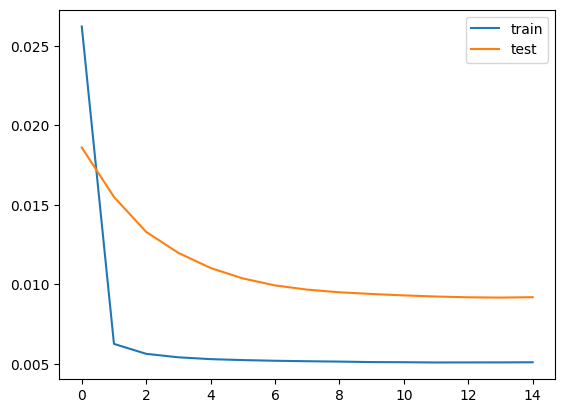

548/548 [==============================] - 3s 4ms/step
MAPE: 5.918638094140653
RMSE: 1019.9972191941404
Correlation 0.8639454337608811 with p-value 0.0
1019.9972191941404 5.918638094140653 0.8639454337608811 947.4456709485944 5.087204141815509 0.9032551247852244
---------------
dailyMeanTemperature-60days
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkay7sx3j/2sbc2qvv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkay7sx3j/w7jfv5cf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76693', 'data', 'file=/tmp/tmpkay7sx3j/2sbc2qvv.json', 'init=/tmp/tmpkay7sx3j/w7jfv5cf.json', 'output', 'file=/tmp/tmpkay7sx3j/prophet_modeliio_5dc0/prophet_model-20240614122929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:29:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:30:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


42403 17520
shape 1 10
Epoch 1/50
332/332 - 5s - loss: 0.0309 - val_loss: 0.0131 - 5s/epoch - 16ms/step
Epoch 2/50
332/332 - 2s - loss: 0.0067 - val_loss: 0.0108 - 2s/epoch - 7ms/step
Epoch 3/50
332/332 - 4s - loss: 0.0060 - val_loss: 0.0099 - 4s/epoch - 11ms/step
Epoch 4/50
332/332 - 3s - loss: 0.0058 - val_loss: 0.0095 - 3s/epoch - 8ms/step
Epoch 5/50
332/332 - 2s - loss: 0.0057 - val_loss: 0.0093 - 2s/epoch - 7ms/step
Epoch 6/50
332/332 - 2s - loss: 0.0055 - val_loss: 0.0091 - 2s/epoch - 7ms/step
Epoch 7/50
332/332 - 2s - loss: 0.0054 - val_loss: 0.0090 - 2s/epoch - 7ms/step
Epoch 8/50
332/332 - 3s - loss: 0.0053 - val_loss: 0.0090 - 3s/epoch - 9ms/step
Epoch 9/50
332/332 - 4s - loss: 0.0053 - val_loss: 0.0090 - 4s/epoch - 11ms/step
Epoch 10/50
332/332 - 2s - loss: 0.0053 - val_loss: 0.0091 - 2s/epoch - 7ms/step
Epoch 11/50
332/332 - 2s - loss: 0.0054 - val_loss: 0.0093 - 2s/epoch - 7ms/step
Epoch 12/50
332/332 - 3s - loss: 0.0054 - val_loss: 0.0095 - 3s/epoch - 8ms/step


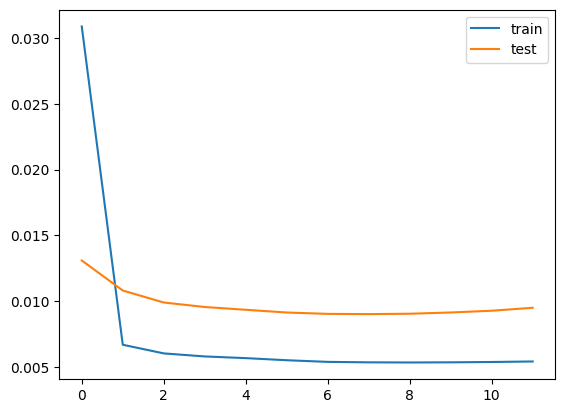

548/548 [==============================] - 1s 2ms/step
MAPE: 5.737309418062616
RMSE: 1035.785307508899
Correlation 0.868431990698302 with p-value 0.0
1035.785307508899 5.737309418062616 0.868431990698302 991.3533537484259 5.115414430859661 0.9029960222903016
---------------
dailyMeanWindspeed-60days
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkay7sx3j/6jnrp6r3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkay7sx3j/6_b99c95.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11581', 'data', 'file=/tmp/tmpkay7sx3j/6jnrp6r3.json', 'init=/tmp/tmpkay7sx3j/6_b99c95.json', 'output', 'file=/tmp/tmpkay7sx3j/prophet_modelizw1lg02/prophet_model-20240614123140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:31:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:32:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


42403 17520
shape 1 10
Epoch 1/50
332/332 - 7s - loss: 0.0277 - val_loss: 0.0171 - 7s/epoch - 20ms/step
Epoch 2/50
332/332 - 5s - loss: 0.0066 - val_loss: 0.0151 - 5s/epoch - 14ms/step
Epoch 3/50
332/332 - 4s - loss: 0.0058 - val_loss: 0.0125 - 4s/epoch - 11ms/step
Epoch 4/50
332/332 - 2s - loss: 0.0055 - val_loss: 0.0110 - 2s/epoch - 7ms/step
Epoch 5/50
332/332 - 2s - loss: 0.0053 - val_loss: 0.0101 - 2s/epoch - 7ms/step
Epoch 6/50
332/332 - 3s - loss: 0.0053 - val_loss: 0.0096 - 3s/epoch - 8ms/step
Epoch 7/50
332/332 - 4s - loss: 0.0052 - val_loss: 0.0093 - 4s/epoch - 11ms/step
Epoch 8/50
332/332 - 5s - loss: 0.0052 - val_loss: 0.0091 - 5s/epoch - 16ms/step
Epoch 9/50
332/332 - 2s - loss: 0.0052 - val_loss: 0.0090 - 2s/epoch - 7ms/step
Epoch 10/50
332/332 - 2s - loss: 0.0051 - val_loss: 0.0088 - 2s/epoch - 6ms/step
Epoch 11/50
332/332 - 2s - loss: 0.0051 - val_loss: 0.0087 - 2s/epoch - 7ms/step
Epoch 12/50
332/332 - 2s - loss: 0.0051 - val_loss: 0.0086 - 2s/epoch - 7ms/step
Epoch 13/

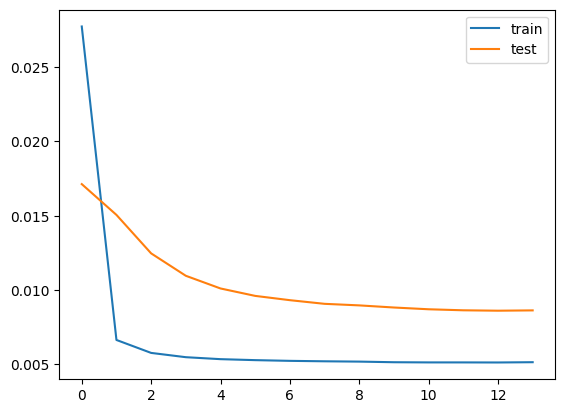

548/548 [==============================] - 2s 2ms/step
MAPE: 5.838927927138574
RMSE: 988.0578994569297
Correlation 0.8724786579277506 with p-value 0.0
988.0578994569297 5.838927927138574 0.8724786579277506 938.9623911869703 5.127638258111171 0.9054112151088323
---------------
NAO-60days
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkay7sx3j/0rhkgxnu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkay7sx3j/i1if8qlf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66656', 'data', 'file=/tmp/tmpkay7sx3j/0rhkgxnu.json', 'init=/tmp/tmpkay7sx3j/i1if8qlf.json', 'output', 'file=/tmp/tmpkay7sx3j/prophet_modelry0t1xpe/prophet_model-20240614123428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:34:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:35:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


42403 17520
shape 1 10
Epoch 1/50
332/332 - 6s - loss: 0.0312 - val_loss: 0.0197 - 6s/epoch - 18ms/step
Epoch 2/50
332/332 - 3s - loss: 0.0076 - val_loss: 0.0143 - 3s/epoch - 9ms/step
Epoch 3/50
332/332 - 2s - loss: 0.0061 - val_loss: 0.0119 - 2s/epoch - 7ms/step
Epoch 4/50
332/332 - 3s - loss: 0.0056 - val_loss: 0.0106 - 3s/epoch - 8ms/step
Epoch 5/50
332/332 - 2s - loss: 0.0054 - val_loss: 0.0099 - 2s/epoch - 6ms/step
Epoch 6/50
332/332 - 2s - loss: 0.0054 - val_loss: 0.0096 - 2s/epoch - 6ms/step
Epoch 7/50
332/332 - 3s - loss: 0.0054 - val_loss: 0.0094 - 3s/epoch - 11ms/step
Epoch 8/50
332/332 - 3s - loss: 0.0054 - val_loss: 0.0095 - 3s/epoch - 10ms/step
Epoch 9/50
332/332 - 3s - loss: 0.0054 - val_loss: 0.0095 - 3s/epoch - 8ms/step
Epoch 10/50
332/332 - 3s - loss: 0.0055 - val_loss: 0.0097 - 3s/epoch - 8ms/step
Epoch 11/50
332/332 - 2s - loss: 0.0055 - val_loss: 0.0100 - 2s/epoch - 6ms/step
Epoch 12/50
332/332 - 3s - loss: 0.0055 - val_loss: 0.0103 - 3s/epoch - 9ms/step


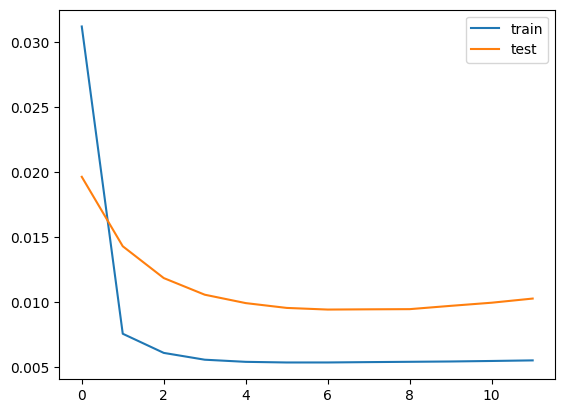

548/548 [==============================] - 2s 2ms/step
MAPE: 6.008101726860063
RMSE: 1079.083405915106
Correlation 0.8614031761167221 with p-value 0.0
1079.083405915106 6.008101726860063 0.8614031761167221 993.433085387401 5.381229853454738 0.8949528643337173
---------------
nat-60days
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkay7sx3j/xxxur7h8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkay7sx3j/143go88j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59184', 'data', 'file=/tmp/tmpkay7sx3j/xxxur7h8.json', 'init=/tmp/tmpkay7sx3j/143go88j.json', 'output', 'file=/tmp/tmpkay7sx3j/prophet_modelxyz95kac/prophet_model-20240614123647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:36:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:37:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


42403 17520
shape 1 10
Epoch 1/50
332/332 - 6s - loss: 0.0284 - val_loss: 0.0170 - 6s/epoch - 18ms/step
Epoch 2/50
332/332 - 2s - loss: 0.0062 - val_loss: 0.0136 - 2s/epoch - 6ms/step
Epoch 3/50
332/332 - 2s - loss: 0.0055 - val_loss: 0.0122 - 2s/epoch - 6ms/step
Epoch 4/50
332/332 - 3s - loss: 0.0052 - val_loss: 0.0114 - 3s/epoch - 8ms/step
Epoch 5/50
332/332 - 4s - loss: 0.0051 - val_loss: 0.0109 - 4s/epoch - 11ms/step
Epoch 6/50
332/332 - 2s - loss: 0.0050 - val_loss: 0.0106 - 2s/epoch - 7ms/step
Epoch 7/50
332/332 - 2s - loss: 0.0050 - val_loss: 0.0105 - 2s/epoch - 7ms/step
Epoch 8/50
332/332 - 2s - loss: 0.0049 - val_loss: 0.0104 - 2s/epoch - 6ms/step
Epoch 9/50
332/332 - 2s - loss: 0.0049 - val_loss: 0.0103 - 2s/epoch - 7ms/step
Epoch 10/50
332/332 - 3s - loss: 0.0048 - val_loss: 0.0103 - 3s/epoch - 10ms/step
Epoch 11/50
332/332 - 3s - loss: 0.0048 - val_loss: 0.0103 - 3s/epoch - 10ms/step
Epoch 12/50
332/332 - 2s - loss: 0.0048 - val_loss: 0.0102 - 2s/epoch - 7ms/step
Epoch 13/5

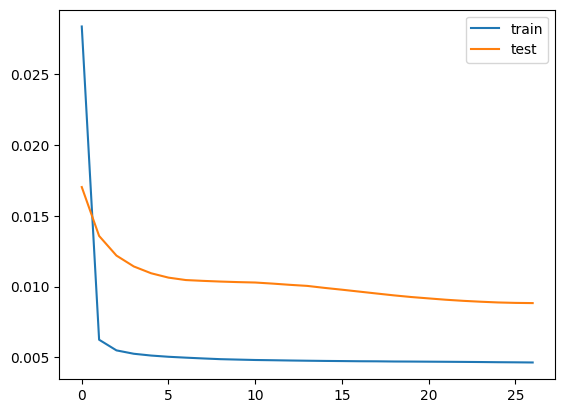

548/548 [==============================] - 3s 4ms/step
MAPE: 5.7478073043243825
RMSE: 999.1348387184603
Correlation 0.8704448897648047 with p-value 0.0
999.1348387184603 5.7478073043243825 0.8704448897648047 902.0401467869906 4.824841743173177 0.9127061496926784
---------------
sic-60days
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkay7sx3j/_by1ehjr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkay7sx3j/dfmdieo3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95741', 'data', 'file=/tmp/tmpkay7sx3j/_by1ehjr.json', 'init=/tmp/tmpkay7sx3j/dfmdieo3.json', 'output', 'file=/tmp/tmpkay7sx3j/prophet_modelbrncs5oz/prophet_model-20240614123935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:39:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:40:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


42403 17520
shape 1 10
Epoch 1/50
332/332 - 9s - loss: 0.0300 - val_loss: 0.0170 - 9s/epoch - 27ms/step
Epoch 2/50
332/332 - 2s - loss: 0.0073 - val_loss: 0.0115 - 2s/epoch - 6ms/step
Epoch 3/50
332/332 - 2s - loss: 0.0063 - val_loss: 0.0148 - 2s/epoch - 7ms/step
Epoch 4/50
332/332 - 4s - loss: 0.0063 - val_loss: 0.0227 - 4s/epoch - 11ms/step
Epoch 5/50
332/332 - 3s - loss: 0.0066 - val_loss: 0.0277 - 3s/epoch - 8ms/step
Epoch 6/50
332/332 - 2s - loss: 0.0068 - val_loss: 0.0253 - 2s/epoch - 7ms/step
Epoch 7/50
332/332 - 2s - loss: 0.0068 - val_loss: 0.0185 - 2s/epoch - 6ms/step
Epoch 8/50
332/332 - 2s - loss: 0.0065 - val_loss: 0.0133 - 2s/epoch - 7ms/step
Epoch 9/50
332/332 - 2s - loss: 0.0059 - val_loss: 0.0101 - 2s/epoch - 7ms/step
Epoch 10/50
332/332 - 4s - loss: 0.0054 - val_loss: 0.0089 - 4s/epoch - 12ms/step
Epoch 11/50
332/332 - 2s - loss: 0.0051 - val_loss: 0.0089 - 2s/epoch - 7ms/step
Epoch 12/50
332/332 - 3s - loss: 0.0049 - val_loss: 0.0094 - 3s/epoch - 8ms/step
Epoch 13/50

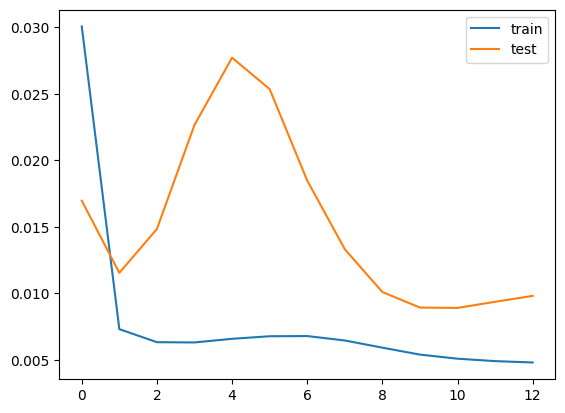

548/548 [==============================] - 2s 2ms/step
MAPE: 6.69165240121863
RMSE: 1053.741659620227
Correlation 0.8777253606339874 with p-value 0.0
1053.741659620227 6.69165240121863 0.8777253606339874 1009.5133527918239 5.8900165659850945 0.9084999915502457
---------------
geopotential-60days
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkay7sx3j/s32npudz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkay7sx3j/3_hsy9qm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78927', 'data', 'file=/tmp/tmpkay7sx3j/s32npudz.json', 'init=/tmp/tmpkay7sx3j/3_hsy9qm.json', 'output', 'file=/tmp/tmpkay7sx3j/prophet_modelizxuigtc/prophet_model-20240614124151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:41:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:42:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


42403 17520
shape 1 10
Epoch 1/50
332/332 - 7s - loss: 0.0278 - val_loss: 0.0120 - 7s/epoch - 20ms/step
Epoch 2/50
332/332 - 2s - loss: 0.0063 - val_loss: 0.0112 - 2s/epoch - 7ms/step
Epoch 3/50
332/332 - 2s - loss: 0.0059 - val_loss: 0.0132 - 2s/epoch - 6ms/step
Epoch 4/50
332/332 - 3s - loss: 0.0062 - val_loss: 0.0165 - 3s/epoch - 9ms/step
Epoch 5/50
332/332 - 4s - loss: 0.0068 - val_loss: 0.0198 - 4s/epoch - 11ms/step
Epoch 6/50
332/332 - 2s - loss: 0.0074 - val_loss: 0.0221 - 2s/epoch - 7ms/step
Epoch 7/50
332/332 - 2s - loss: 0.0076 - val_loss: 0.0218 - 2s/epoch - 7ms/step
Epoch 8/50
332/332 - 3s - loss: 0.0074 - val_loss: 0.0181 - 3s/epoch - 8ms/step
Epoch 9/50
332/332 - 3s - loss: 0.0067 - val_loss: 0.0128 - 3s/epoch - 8ms/step
Epoch 10/50
332/332 - 4s - loss: 0.0062 - val_loss: 0.0100 - 4s/epoch - 12ms/step
Epoch 11/50
332/332 - 3s - loss: 0.0060 - val_loss: 0.0110 - 3s/epoch - 8ms/step
Epoch 12/50
332/332 - 2s - loss: 0.0059 - val_loss: 0.0120 - 2s/epoch - 7ms/step
Epoch 13/50

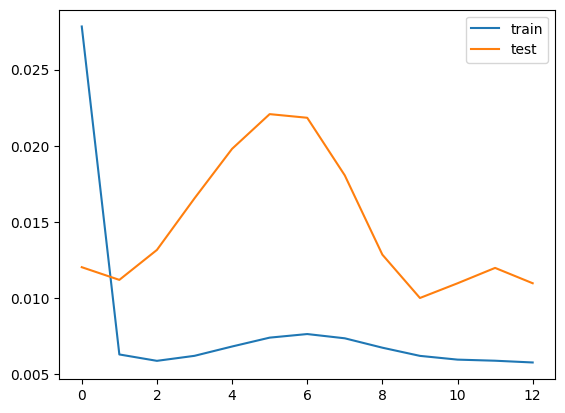

548/548 [==============================] - 2s 2ms/step
MAPE: 7.0233960591225495
RMSE: 1113.938258517802
Correlation 0.8657212237233254 with p-value 0.0
1113.938258517802 7.0233960591225495 0.8657212237233254 1042.454241010833 5.935458514080741 0.905459749087434
---------------
renewableEnergyRatio-60days
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkay7sx3j/8x6vx4je.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkay7sx3j/_g8p9pu4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31418', 'data', 'file=/tmp/tmpkay7sx3j/8x6vx4je.json', 'init=/tmp/tmpkay7sx3j/_g8p9pu4.json', 'output', 'file=/tmp/tmpkay7sx3j/prophet_modelc8k3c878/prophet_model-20240614124330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:43:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:44:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


42403 17520
shape 1 10
Epoch 1/50
332/332 - 9s - loss: 0.0265 - val_loss: 0.0338 - 9s/epoch - 28ms/step
Epoch 2/50
332/332 - 4s - loss: 0.0070 - val_loss: 0.0316 - 4s/epoch - 11ms/step
Epoch 3/50
332/332 - 2s - loss: 0.0058 - val_loss: 0.0292 - 2s/epoch - 6ms/step
Epoch 4/50
332/332 - 2s - loss: 0.0054 - val_loss: 0.0234 - 2s/epoch - 6ms/step
Epoch 5/50
332/332 - 3s - loss: 0.0054 - val_loss: 0.0193 - 3s/epoch - 8ms/step
Epoch 6/50
332/332 - 4s - loss: 0.0054 - val_loss: 0.0170 - 4s/epoch - 11ms/step
Epoch 7/50
332/332 - 3s - loss: 0.0054 - val_loss: 0.0168 - 3s/epoch - 8ms/step
Epoch 8/50
332/332 - 2s - loss: 0.0054 - val_loss: 0.0162 - 2s/epoch - 6ms/step
Epoch 9/50
332/332 - 3s - loss: 0.0054 - val_loss: 0.0156 - 3s/epoch - 8ms/step
Epoch 10/50
332/332 - 2s - loss: 0.0054 - val_loss: 0.0152 - 2s/epoch - 7ms/step
Epoch 11/50
332/332 - 4s - loss: 0.0053 - val_loss: 0.0147 - 4s/epoch - 11ms/step
Epoch 12/50
332/332 - 3s - loss: 0.0053 - val_loss: 0.0144 - 3s/epoch - 9ms/step
Epoch 13/5

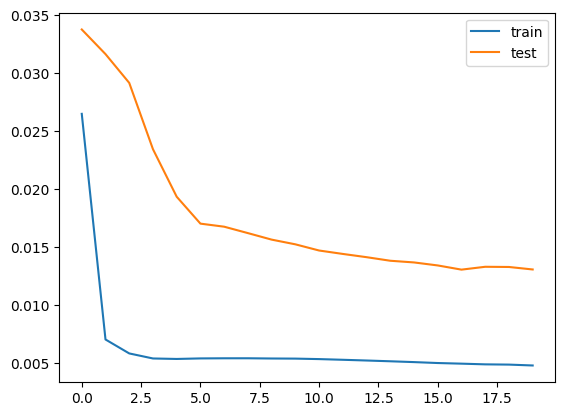

548/548 [==============================] - 2s 3ms/step
MAPE: 7.962403390277398
RMSE: 1215.7652555629227
Correlation 0.8636518681252299 with p-value 0.0
1215.7652555629227 7.962403390277398 0.8636518681252299 1069.8924119011297 6.302472492467814 0.8986552056725022
---------------


In [ ]:
use_all_predictors=False
use_no_predictors=True
include_climate_change_bool=False
include_price_bool=False
huang=True
tan=False


results = {}

for feature in climate_features:
  print(feature)
  predictors_list = predictor_selection(
    df_train_val,
    numerical_columns_lagged,
    n_predictors,
    alpha,
    n_days_lag,
    use_all_predictors,
    use_no_predictors,
    include_climate_change_bool,
    include_price_bool,
    known_features_list,
    feature_to_include=feature
  )

  df_train_lstm, df_test_lstm = run_prophet(
    df_train_val,
    df_test,
    predictors_list,
    use_all_predictors,
    use_no_predictors,
    n_days_lag
  )

  rmse, mape, corr_test, rmse_wintertime, mape_wintertime, pcc_wintertime, df_winter_test = run_lstm(df_train_lstm, df_test_lstm, huang, tan)
  results[feature] = [round(rmse, 2),
                      round(mape, 2),
                      round(corr_test, 2),
                      round(rmse_wintertime, 2),
                      round(mape_wintertime, 2),
                      round(pcc_wintertime, 2)]
  print(rmse, mape, corr_test, rmse_wintertime, mape_wintertime, pcc_wintertime)
  print('---------------')


In [ ]:
results

{'dailyPrecipitation-60days': [1020.0, 5.92, 0.86, 947.45, 5.09, 0.9],
 'dailyMeanTemperature-60days': [1035.79, 5.74, 0.87, 991.35, 5.12, 0.9],
 'dailyMeanWindspeed-60days': [988.06, 5.84, 0.87, 938.96, 5.13, 0.91],
 'NAO-60days': [1079.08, 6.01, 0.86, 993.43, 5.38, 0.89],
 'nat-60days': [999.13, 5.75, 0.87, 902.04, 4.82, 0.91],
 'sic-60days': [1053.74, 6.69, 0.88, 1009.51, 5.89, 0.91],
 'geopotential-60days': [1113.94, 7.02, 0.87, 1042.45, 5.94, 0.91],
 'renewableEnergyRatio-60days': [1215.77, 7.96, 0.86, 1069.89, 6.3, 0.9]}

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
df_train_val = pd.read_csv(f'/content/drive/MyDrive/master_thesis_data/processed_75_25_data/train_val.csv').drop(columns=['Unnamed: 0'])

# the independent variables set
X = df_train_val[climate_features]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

vif_data

,feature,VIF
0,dailyPrecipitation-60days,1.523881
1,dailyMeanTemperature-60days,11.463516
2,dailyMeanWindspeed-60days,9.816494
3,NAO-60days,1.336196
4,nat-60days,1.378832
5,sic-60days,50.769668
6,geopotential-60days,42.352028
7,renewableEnergyRatio-60days,110.909963


# MLR

In [ ]:
from sklearn.linear_model import LinearRegression


def evaluate_wintertime_predictions_mlr(df_test, test_y_inversed, yhat_inversed):
  df_test.reset_index(inplace=True)
  df_test['datetime'] = pd.to_datetime(df_test['datetime'])
  df_test['test_y'] = test_y_inversed
  df_test['forecasted_y'] = yhat_inversed
  df_test['month'] = df_test['datetime'].dt.month

  df_winter_test = df_test[df_test['month'].isin([1, 2, 12])]
  actual = df_winter_test['test_y'].values
  forecast = df_winter_test['forecasted_y'].values

  mape = np.mean(np.abs((actual - forecast) / actual)) * 100
  rmse = np.sqrt(mean_squared_error(actual, forecast))
  corr_test, p_value_test = pearsonr(actual, forecast)

  return rmse, mape, corr_test, df_winter_test


def run_mlr(
    numerical_columns_lagged: list,
    n_predictors: int,
    alpha: float,
    n_days_lag: int,
    use_all_predictors: bool,
    use_no_predictors: bool,
    include_climate_change_bool: bool,
    include_price_bool: bool,
    known_features_list: list):

  rmse_list = []
  corr_list = []
  mape_list = []

  wintertime_rmse_list = []
  wintertime_corr_list = []
  wintertime_mape_list = []

  for fold in range(3, 11, 1):
    df_train_val, df_test = reload_data(fold)
    df_train_val.drop(columns=['train', 'test'], inplace=True)
    df_test.drop(columns=['train', 'test'], inplace=True)

    predictors_list = predictor_selection(
        df_train_val,
        numerical_columns_lagged,
        n_predictors,
        alpha,
        n_days_lag,
        use_all_predictors,
        use_no_predictors,
        include_climate_change_bool,
        include_price_bool,
        known_features_list
    )

    if use_no_predictors:
      cols_to_select = predictors_list.copy()
      cols_to_select.append('datetime')
      cols_to_select.append('loadConsumption')
      df_train_val = df_train_val[cols_to_select]
      df_test = df_test[cols_to_select]


    # sort values and set index
    df_train_val = df_train_val.sort_values(by='datetime')
    df_train_val.set_index('datetime', inplace=True)
    df_test = df_test.sort_values(by='datetime')
    df_test.set_index('datetime', inplace=True)

    # min max scaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(df_train_val)
    df_train_scaled = pd.DataFrame(train_scaled, columns=[i + "_scaled" for i in df_train_val.columns])

    df_test = df_test[df_train_val.columns]
    test_scaled = scaler.transform(df_test)
    df_test_scaled = pd.DataFrame(test_scaled, columns=[i + "_scaled" for i in df_test.columns])

    # reorder columns
    cols_ordered = list(df_train_scaled)
    cols_ordered.remove('loadConsumption_scaled')
    cols_ordered.append('loadConsumption_scaled')
    df_train_scaled = df_train_scaled[cols_ordered]
    df_test_scaled = df_test_scaled[cols_ordered]

    # split into X and y
    train_values = df_train_scaled.values
    test_values = df_test_scaled.values

    train_X, train_y = train_values[:, :-1], train_values[:, -1]
    test_X, test_y = test_values[:, :-1], test_values[:, -1]


    print(len(train_X), len(test_X))

    LR = LinearRegression()
    LR.fit(train_X, train_y)
    pred = LR.predict(test_X)

    yhat_inversed = inverse_transform_predictions(
        scaler=scaler,
        data=pred,
        colName='loadConsumption_scaled',
        colNames=df_train_scaled.columns
    )

    mape, rmse, corr_test, p_value, test_y_inversed = evaluate_predictions(test_y, yhat_inversed, scaler, df_train_scaled)
    rmse_wintertime, mape_wintertime, pcc_wintertime, df_winter_test = evaluate_wintertime_predictions_mlr(df_test, test_y_inversed, yhat_inversed)

    rmse_list.append(rmse)
    mape_list.append(mape)
    corr_list.append(corr_test)
    wintertime_rmse_list.append(rmse_wintertime)
    wintertime_mape_list.append(mape_wintertime)
    wintertime_corr_list.append(pcc_wintertime)

  print_evaluation(
        rmse_list=rmse_list,
        mape_list=mape_list,
        corr_list=corr_list,
        wintertime_rmse_list=wintertime_rmse_list,
        wintertime_mape_list=wintertime_mape_list,
        wintertime_corr_list=wintertime_corr_list
    )

  return rmse_list, mape_list, corr_list, wintertime_rmse_list, wintertime_mape_list, wintertime_corr_list


### All predictors

In [ ]:
rmse, mape, corr_test, rmse_wintertime, mape_wintertime, pcc_wintertime = run_mlr(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=5,
    alpha=alpha,
    n_days_lag=n_days_lag,
    use_all_predictors=True,
    use_no_predictors=False,
    include_climate_change_bool=False,
    include_price_bool=False,
    known_features_list=known_features_list)

15333 8783
MAPE: 15.584208853026823
RMSE: 1970.229448930842
Correlation 0.6733066888211828 with p-value 0.0
24116 8759
MAPE: 12.61577683724579
RMSE: 1958.1272773279436
Correlation 0.6556480136209725 with p-value 0.0
32875 8759
MAPE: 18.618802474044767
RMSE: 2468.512331832704
Correlation 0.6187134176564888 with p-value 0.0
41634 8759
MAPE: 10.647577030693192
RMSE: 1789.4693800930452
Correlation 0.6672499436347292 with p-value 0.0
50393 8784
MAPE: 11.967601093742228
RMSE: 1772.218878616708
Correlation 0.6001711885325871 with p-value 0.0
59177 8760
MAPE: 11.273317529120343
RMSE: 1729.810542785821
Correlation 0.618497018615252 with p-value 0.0
67937 8760
MAPE: 10.250214638003301
RMSE: 1724.2960679082873
Correlation 0.6086893825376272 with p-value 0.0
76697 3622
MAPE: 9.402478774742749
RMSE: 1699.0008783884189
Correlation 0.6173343963868461 with p-value 0.0
AVG
----------------------------------
1888.96 & 12.54 & 0.63 & 1874.75 & 11.11 & 0.7 
----------------------------------
GENERAL FOLDS

### No predictors

In [ ]:
rmse, mape, corr_test, rmse_wintertime, mape_wintertime, pcc_wintertime = run_mlr(
    numerical_columns_lagged=numerical_columns_lagged,
    n_predictors=5,
    alpha=alpha,
    n_days_lag=n_days_lag,
    use_all_predictors=False,
    use_no_predictors=True,
    include_climate_change_bool=False,
    include_price_bool=False,
    known_features_list=known_features_list)

15333 8783
MAPE: 12.537576672554735
RMSE: 1835.1929403682734
Correlation 0.63861040306109 with p-value 0.0
24116 8759
MAPE: 11.922162657825282
RMSE: 1943.2628833393576
Correlation 0.614764671697301 with p-value 0.0
32875 8759
MAPE: 11.665947330294197
RMSE: 1800.4402541503302
Correlation 0.640870760335348 with p-value 0.0
41634 8759
MAPE: 10.257916075608762
RMSE: 1691.7495284951708
Correlation 0.607524933394177 with p-value 0.0
50393 8784
MAPE: 10.441228576350152
RMSE: 1702.8270909240755
Correlation 0.566237393014271 with p-value 0.0
59177 8760
MAPE: 10.604022548787418
RMSE: 1744.4675266609593
Correlation 0.546348949557599 with p-value 0.0
67937 8760
MAPE: 10.078951205552409
RMSE: 1709.7628490164643
Correlation 0.5147810444808573 with p-value 0.0
76697 3622
MAPE: 10.292254774112147
RMSE: 1849.863151270224
Correlation 0.4995031285389185 with p-value 6.380916127676235e-228
AVG
----------------------------------
1784.7 & 10.98 & 0.58 & 1908.81 & 10.17 & 0.69 
------------------------------

# Extra lags

[3, 4, 5, 6, 7, 8] [9, 10]
n days lag: 135
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1dzxvwgd/vs0j494b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1dzxvwgd/wy1e2f_z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40084', 'data', 'file=/tmp/tmp1dzxvwgd/vs0j494b.json', 'init=/tmp/tmp1dzxvwgd/wy1e2f_z.json', 'output', 'file=/tmp/tmp1dzxvwgd/prophet_modelpzzn7nki/prophet_model-20240613142656.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:26:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:27:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


40603 17520
shape 1 9
Epoch 1/50
318/318 - 9s - loss: 0.0232 - val_loss: 0.0216 - 9s/epoch - 29ms/step
Epoch 2/50
318/318 - 2s - loss: 0.0069 - val_loss: 0.0142 - 2s/epoch - 6ms/step
Epoch 3/50
318/318 - 2s - loss: 0.0058 - val_loss: 0.0112 - 2s/epoch - 7ms/step
Epoch 4/50
318/318 - 3s - loss: 0.0054 - val_loss: 0.0101 - 3s/epoch - 8ms/step
Epoch 5/50
318/318 - 3s - loss: 0.0054 - val_loss: 0.0099 - 3s/epoch - 8ms/step
Epoch 6/50
318/318 - 4s - loss: 0.0054 - val_loss: 0.0100 - 4s/epoch - 12ms/step
Epoch 7/50
318/318 - 2s - loss: 0.0055 - val_loss: 0.0104 - 2s/epoch - 7ms/step
Epoch 8/50
318/318 - 3s - loss: 0.0056 - val_loss: 0.0110 - 3s/epoch - 8ms/step
Epoch 9/50
318/318 - 3s - loss: 0.0058 - val_loss: 0.0117 - 3s/epoch - 8ms/step
Epoch 10/50
318/318 - 3s - loss: 0.0060 - val_loss: 0.0127 - 3s/epoch - 8ms/step
Epoch 11/50
318/318 - 4s - loss: 0.0062 - val_loss: 0.0139 - 4s/epoch - 12ms/step
Epoch 12/50
318/318 - 3s - loss: 0.0065 - val_loss: 0.0150 - 3s/epoch - 9ms/step


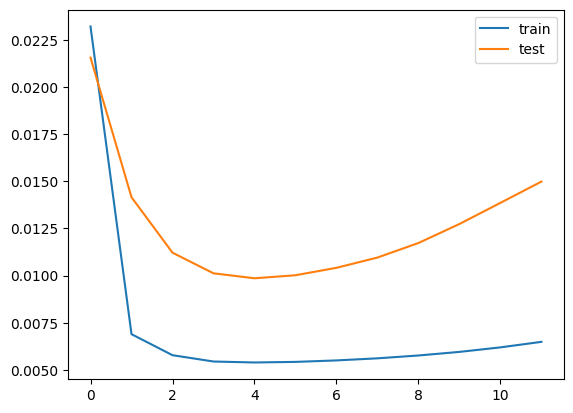

548/548 [==============================] - 2s 2ms/step
MAPE: 7.2941676799532145
RMSE: 1301.7610470051793
Correlation 0.8353753116533079 with p-value 0.0
---------------
n days lag: 150
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1dzxvwgd/7kq90qfl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1dzxvwgd/naakwhhr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89731', 'data', 'file=/tmp/tmp1dzxvwgd/7kq90qfl.json', 'init=/tmp/tmp1dzxvwgd/naakwhhr.json', 'output', 'file=/tmp/tmp1dzxvwgd/prophet_model6aiyyl9t/prophet_model-20240613142917.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:29:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:30:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


40243 17520
shape 1 9
Epoch 1/50
315/315 - 8s - loss: 0.0283 - val_loss: 0.0191 - 8s/epoch - 25ms/step
Epoch 2/50
315/315 - 2s - loss: 0.0072 - val_loss: 0.0141 - 2s/epoch - 7ms/step
Epoch 3/50
315/315 - 3s - loss: 0.0061 - val_loss: 0.0120 - 3s/epoch - 8ms/step
Epoch 4/50
315/315 - 2s - loss: 0.0056 - val_loss: 0.0109 - 2s/epoch - 6ms/step
Epoch 5/50
315/315 - 2s - loss: 0.0054 - val_loss: 0.0104 - 2s/epoch - 7ms/step
Epoch 6/50
315/315 - 4s - loss: 0.0053 - val_loss: 0.0101 - 4s/epoch - 14ms/step
Epoch 7/50
315/315 - 2s - loss: 0.0053 - val_loss: 0.0101 - 2s/epoch - 7ms/step
Epoch 8/50
315/315 - 3s - loss: 0.0053 - val_loss: 0.0101 - 3s/epoch - 8ms/step
Epoch 9/50
315/315 - 2s - loss: 0.0053 - val_loss: 0.0102 - 2s/epoch - 8ms/step
Epoch 10/50
315/315 - 3s - loss: 0.0053 - val_loss: 0.0103 - 3s/epoch - 8ms/step
Epoch 11/50
315/315 - 3s - loss: 0.0054 - val_loss: 0.0106 - 3s/epoch - 11ms/step
Epoch 12/50
315/315 - 3s - loss: 0.0055 - val_loss: 0.0109 - 3s/epoch - 11ms/step


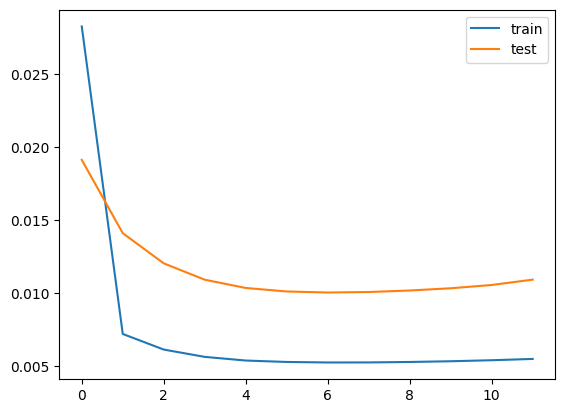

548/548 [==============================] - 2s 3ms/step
MAPE: 6.251620392613861
RMSE: 1112.0481748316397
Correlation 0.8453850609827864 with p-value 0.0
---------------
n days lag: 165
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1dzxvwgd/h7s04r84.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1dzxvwgd/dw3irold.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40314', 'data', 'file=/tmp/tmp1dzxvwgd/h7s04r84.json', 'init=/tmp/tmp1dzxvwgd/dw3irold.json', 'output', 'file=/tmp/tmp1dzxvwgd/prophet_modelfzh69f1s/prophet_model-20240613143151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:31:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:32:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


39883 17520
shape 1 9
Epoch 1/50
312/312 - 6s - loss: 0.0280 - val_loss: 0.0192 - 6s/epoch - 19ms/step
Epoch 2/50
312/312 - 2s - loss: 0.0081 - val_loss: 0.0132 - 2s/epoch - 7ms/step
Epoch 3/50
312/312 - 3s - loss: 0.0065 - val_loss: 0.0107 - 3s/epoch - 8ms/step
Epoch 4/50
312/312 - 4s - loss: 0.0059 - val_loss: 0.0101 - 4s/epoch - 12ms/step
Epoch 5/50
312/312 - 3s - loss: 0.0057 - val_loss: 0.0100 - 3s/epoch - 10ms/step
Epoch 6/50
312/312 - 2s - loss: 0.0056 - val_loss: 0.0099 - 2s/epoch - 8ms/step
Epoch 7/50
312/312 - 2s - loss: 0.0055 - val_loss: 0.0099 - 2s/epoch - 8ms/step
Epoch 8/50
312/312 - 2s - loss: 0.0054 - val_loss: 0.0099 - 2s/epoch - 8ms/step
Epoch 9/50
312/312 - 3s - loss: 0.0053 - val_loss: 0.0098 - 3s/epoch - 10ms/step
Epoch 10/50
312/312 - 4s - loss: 0.0053 - val_loss: 0.0098 - 4s/epoch - 12ms/step
Epoch 11/50
312/312 - 2s - loss: 0.0052 - val_loss: 0.0098 - 2s/epoch - 8ms/step
Epoch 12/50
312/312 - 2s - loss: 0.0052 - val_loss: 0.0098 - 2s/epoch - 7ms/step


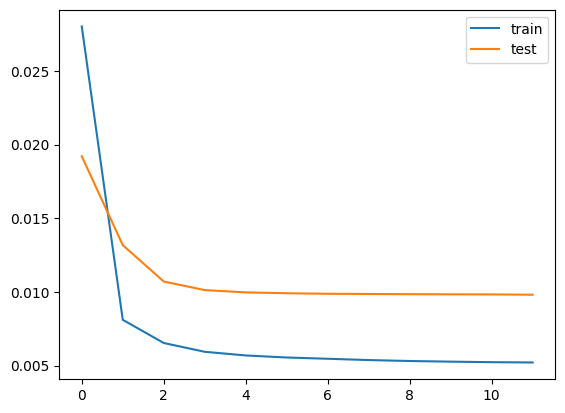

548/548 [==============================] - 2s 3ms/step
MAPE: 6.064865301337217
RMSE: 1053.4564192826874
Correlation 0.8545156566485723 with p-value 0.0
---------------
n days lag: 180
No predictors are used
No predictors are used


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1dzxvwgd/0179gke1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1dzxvwgd/rsqqd5oh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43910', 'data', 'file=/tmp/tmp1dzxvwgd/0179gke1.json', 'init=/tmp/tmp1dzxvwgd/rsqqd5oh.json', 'output', 'file=/tmp/tmp1dzxvwgd/prophet_modeloyd0zsuy/prophet_model-20240613143358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:33:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:34:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


39523 17520
shape 1 9
Epoch 1/50
309/309 - 5s - loss: 0.0293 - val_loss: 0.0284 - 5s/epoch - 18ms/step
Epoch 2/50
309/309 - 2s - loss: 0.0084 - val_loss: 0.0201 - 2s/epoch - 7ms/step
Epoch 3/50
309/309 - 4s - loss: 0.0067 - val_loss: 0.0166 - 4s/epoch - 12ms/step
Epoch 4/50
309/309 - 3s - loss: 0.0058 - val_loss: 0.0153 - 3s/epoch - 10ms/step
Epoch 5/50
309/309 - 2s - loss: 0.0054 - val_loss: 0.0150 - 2s/epoch - 6ms/step
Epoch 6/50
309/309 - 2s - loss: 0.0052 - val_loss: 0.0152 - 2s/epoch - 7ms/step
Epoch 7/50
309/309 - 2s - loss: 0.0050 - val_loss: 0.0153 - 2s/epoch - 7ms/step
Epoch 8/50
309/309 - 2s - loss: 0.0049 - val_loss: 0.0152 - 2s/epoch - 7ms/step
Epoch 9/50
309/309 - 3s - loss: 0.0048 - val_loss: 0.0150 - 3s/epoch - 11ms/step
Epoch 10/50
309/309 - 4s - loss: 0.0047 - val_loss: 0.0148 - 4s/epoch - 12ms/step
Epoch 11/50
309/309 - 2s - loss: 0.0046 - val_loss: 0.0145 - 2s/epoch - 6ms/step
Epoch 12/50
309/309 - 2s - loss: 0.0046 - val_loss: 0.0141 - 2s/epoch - 8ms/step
Epoch 13/5

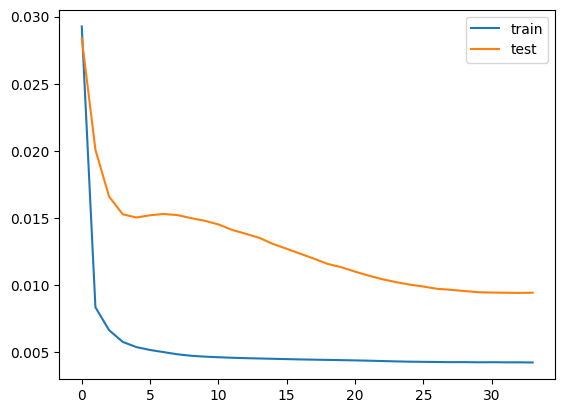

548/548 [==============================] - 2s 3ms/step
MAPE: 5.981571605714215
RMSE: 1033.6850349168535
Correlation 0.8615333921038203 with p-value 0.0
---------------


In [ ]:
df = read_processed_data()
df['winterIndex'] = df[['Year', 'Month']].apply(lambda x: reindex_winter_years(x.Year, x.Month), axis=1)
df.drop(columns=['Year', 'Month'], inplace=True)
numerical_columns = find_numerical_columns(df)

train_indices = [i for i in range(3, 9, 1)]
test_indices = [9, 10]
print(train_indices, test_indices)

df['train'] = df['winterIndex'].apply(lambda x: True if x in train_indices else False)
df['test'] = df['winterIndex'].apply(lambda x: True if x in test_indices else False)

df = clear_outliers(df, numerical_columns)


use_all_predictors=False
use_no_predictors=True
include_climate_change_bool=False
include_price_bool=False
huang=True
tan=False

for n_days_lag in range(135, 195, 15):
  print('n days lag:', n_days_lag)
  df_lag = shift_data(df, n_days_lag, known_features_list=known_features_list)

  df_train_val, df_test = split_train_val_test(df_lag)

  # if len(df_train_val) > 0:
  df_train_val, df_test, numerical_columns_lagged = impute_numerical_columns(
    df_train_val=df_train_val,
    df_test=df_test,
    numerical_columns=numerical_columns,
    n_days_lag=n_days_lag,
    known_features_list=known_features_list
  )

  predictors_list = predictor_selection(
    df_train_val,
    numerical_columns_lagged,
    n_predictors,
    alpha,
    n_days_lag,
    use_all_predictors,
    use_no_predictors,
    include_climate_change_bool,
    include_price_bool,
    known_features_list
  )

  df_train_lstm, df_test_lstm = run_prophet(
    df_train_val,
    df_test,
    predictors_list,
    use_all_predictors,
    use_no_predictors,
    n_days_lag
  )

  rmse, mape, corr_test, rmse_wintertime, mape_wintertime, pcc_wintertime, df_winter_test = run_lstm(df_train_lstm, df_test_lstm, huang, tan)
  rmse_list.append(rmse)
  mape_list.append(mape)
  corr_list.append(corr_test)
  wintertime_rmse_list.append(rmse_wintertime)
  wintertime_mape_list.append(mape_wintertime)
  wintertime_corr_list.append(pcc_wintertime)

  print('---------------')


In [ ]:
df_results2 = pd.DataFrame(rmse_list, columns=['rmse'])
df_results2['mape'] = mape_list
df_results2['corr'] = corr_list
df_results2['wintertime_rmse'] = wintertime_rmse_list
df_results2['wintertime_mape'] = wintertime_mape_list
df_results2['wintertime_corr'] = wintertime_corr_list

df_results2

,rmse,mape,corr,wintertime_rmse,wintertime_mape,wintertime_corr
0,986.686393,5.719421,0.873046,926.107646,5.059627,0.907705
1,980.674440,5.763203,0.875033,895.733599,4.895196,0.914137
2,898.111232,5.180996,0.903719,696.313865,3.734351,0.950774
3,939.545719,5.522285,0.894457,771.909707,4.181806,0.940682
4,1529.957845,8.759646,0.822970,1260.114191,6.539521,0.859230
5,1301.761047,7.294168,0.835375,1182.478790,6.266930,0.858588
6,1112.048175,6.251620,0.845385,1078.162248,5.909289,0.873259
7,1053.456419,6.064865,0.854516,1043.446903,5.742659,0.881558
8,1033.685035,5.981572,0.861533,949.447696,5.099654,0.902819


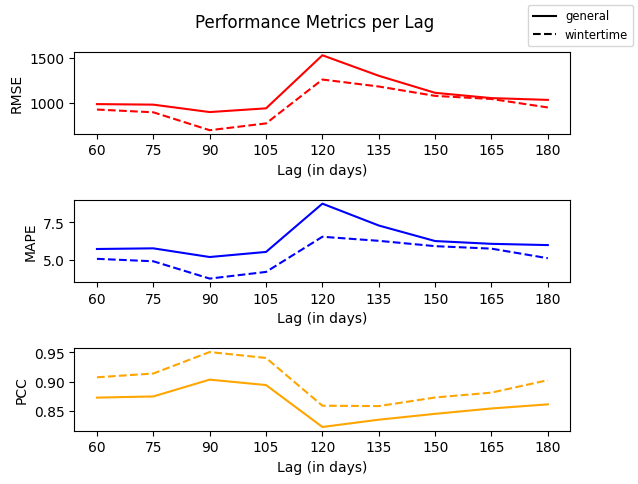

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

nbr_days_lag = [i for i in range(60, 195, 15)]

fig, axs = plt.subplots(3)
fig.suptitle('Performance Metrics per Lag')

axs[0].plot(nbr_days_lag, rmse_list, color="red", linestyle='-', label='general')
axs[0].plot(nbr_days_lag, wintertime_rmse_list, color="red", linestyle='--', label='wintertime')
axs[0].set_ylabel('RMSE')
axs[0].set_xlabel('Lag (in days)')
axs[0].set_xticks(nbr_days_lag)

axs[1].plot(nbr_days_lag, mape_list, color="blue", linestyle='-', label='general')
axs[1].plot(nbr_days_lag, wintertime_mape_list, color="blue", linestyle='--', label='wintertime')
axs[1].set_ylabel('MAPE')
axs[1].set_xlabel('Lag (in days)')
axs[1].set_xticks(nbr_days_lag)

axs[2].plot(nbr_days_lag, corr_list, color="orange", linestyle='-', label='general')
axs[2].plot(nbr_days_lag, wintertime_corr_list, color="orange", linestyle='--', label='wintertime')
axs[2].set_ylabel('PCC')
axs[2].set_xlabel('Lag (in days)')
axs[2].set_xticks(nbr_days_lag)

from matplotlib.lines import Line2D

general_line = Line2D([0], [0], color='black', linestyle='-')
wintertime_line = Line2D([0], [0], color='black', linestyle='--')

fig.legend([general_line, wintertime_line], ['general', 'wintertime'], loc='upper right', fontsize='small')

plt.subplots_adjust(hspace=0.8, top=0.9)

plt.show()

# Visualizations

In [ ]:
df = read_processed_data()
df['datetime'] = pd.to_datetime(df['datetime'])

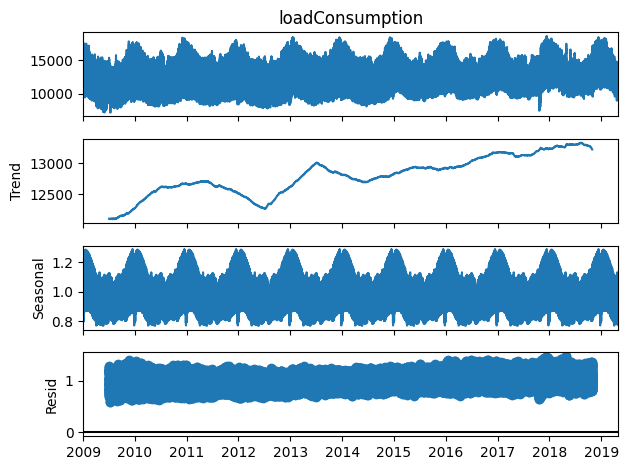

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_additive = seasonal_decompose(df['loadConsumption'], model='multiplicative', period=365*24)
decomposition_additive.plot()
plt.show()

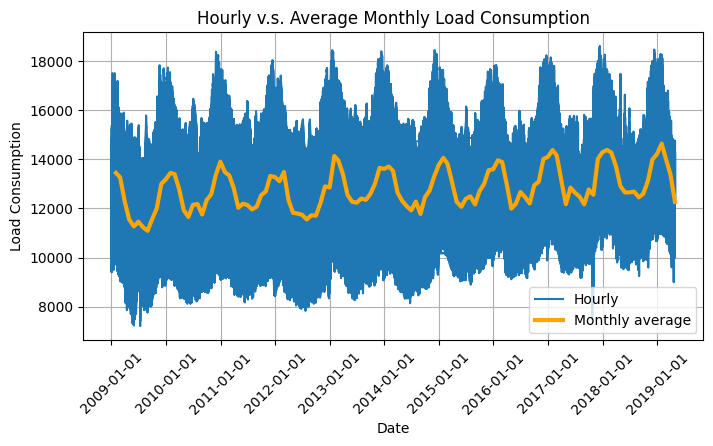

In [ ]:
df.set_index('datetime', inplace=True)

fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(df.index, df['loadConsumption'], label='Hourly')
# plt.plot(df['loadConsumption'].resample('D').mean())
plt.plot(df['loadConsumption'].resample('M').mean(), label='Monthly average', color='orange', linewidth=3)

plt.title("Hourly v.s. Average Monthly Load Consumption")
plt.xlabel("Date")
plt.ylabel("Load Consumption")
plt.legend()
plt.grid()
plt.xticks(pd.date_range(start=df.index.min(), end=df.index.max(), freq='YS'), rotation=45)
plt.show()

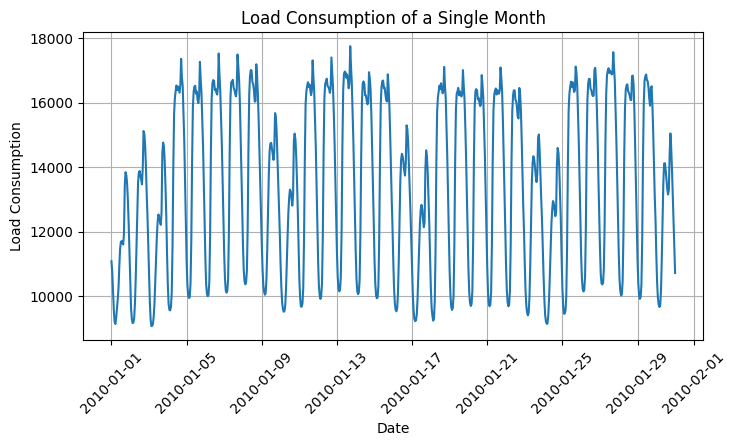

In [ ]:
df.reset_index(inplace=True)
single_month = df[(df['datetime'] >= '2010-01-01') & (df['datetime'] <= '2010-01-31')]
single_month.reset_index(inplace=True, drop=True)
single_month.sort_values('datetime', inplace=True)
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(single_month['datetime'], single_month['loadConsumption'])

plt.title("Load Consumption of a Single Month")
plt.xlabel("Date")
plt.ylabel("Load Consumption")
plt.grid()
plt.xticks(rotation=45)
plt.show()

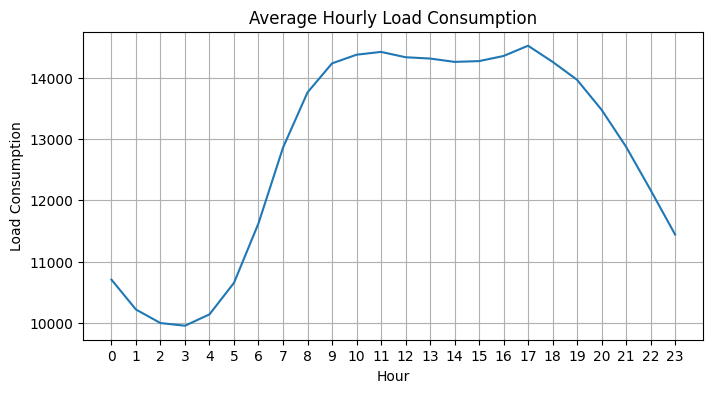

In [ ]:
df = read_processed_data()
df['datetime'] = pd.to_datetime(df['datetime'])
df['hour'] = df['datetime'].dt.hour

hourly_avg = df.groupby('hour')['loadConsumption'].mean()

fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(hourly_avg.index, hourly_avg.values)

plt.title("Average Hourly Load Consumption")
plt.xlabel("Hour")
plt.ylabel("Load Consumption")
plt.grid()
plt.xticks([i for i in range(0, 24, 1)])
plt.show()

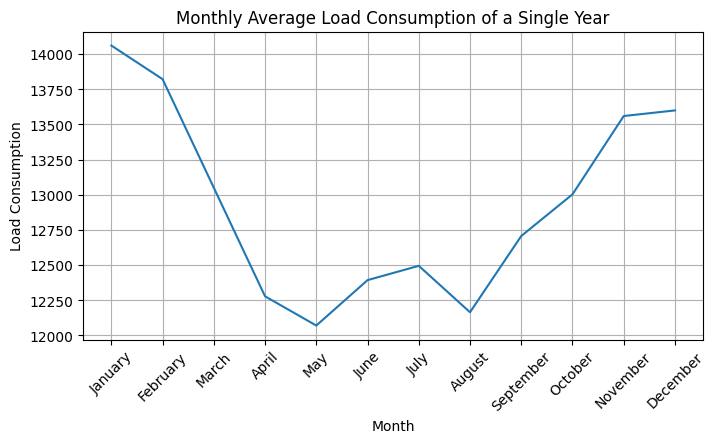

In [ ]:
from calendar import month_name

df['year'] = df['datetime'].dt.year
single_year = df[(df['year'] == 2015)]
single_year.sort_values('datetime', inplace=True)

single_year_mean = single_year.groupby('Month')['loadConsumption'].mean()

month_names = [month_name[i] for i in single_year_mean.index]

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(month_names, single_year_mean.values)

plt.title("Monthly Average Load Consumption of a Single Year")
plt.xlabel("Month")
plt.ylabel("Load Consumption")
plt.grid()
plt.xticks(rotation=45)

plt.show()